# 0.0. IMPORTS

In [4]:
# Biblioteca para Manipulação de Tabelas
import pandas as pd

# Biblioteca para trabalhar com vetores e arrays
import numpy as np

# Biblioteca para alterar nome das colunas de Kamel Case para Snake Case
import inflection

# Biblioteca para armazenar objetos/entidades de dados
import pickle

## Biblioteca para construir interfaces(app) Web em Python para construir API´s
from flask import Flask, request

# Bibliotecas para trabalhar com Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Biblioteca para configurar layout tela Jupyter
from IPython.core.display import HTML

# Biblioteca para inserir imagem (upload) externa
from IPython.display import Image 

# Bilioteca para criar tabelas manuais
from tabulate import tabulate

# Biblioteca para tipo de dados de data
import datetime

# Biblioteca para realizar operação aleatória
import random

# Biblioteca para cálculos estatísticos e matemáticos
from scipy import stats
import math

# Bibliotecas de Machine Learnig
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb 
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## 0.1. Helper Functions

Seção para construção de funções auxiliares para o projeto

In [2]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) ) # Raíz quadrada do erro quadrático médio
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae,
                           'MAPE':mape,
                           'RMSE':rmse }, index = [0] )

def cramer_v( x, y ):
    
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 10
    plt.tight_layout(w_pad= 2., h_pad= 5.) # w_pad: espaçamento em relação a largura. h_pad: espaçamento em relação a altura. 
    display( HTML( '<style>.container { width:97% !important; }</style>') )
    pd.options.display.max_columns = 50
    pd.options.display.max_rows = 50
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    
    return None


def cross_validation(training, kfold, model_name, model, verbose = False):
    
    # Listas para guardar resultados algoritmos para cada pedaço do dataset de treino em validação
    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed( range( 1 , kfold + 1) ):

        #  1. MOSTRADOR DE EVOLUÇÃO DO PROCESSO
        if verbose:
            print(f"\nKFold Number {(kfold + 1) - k}")

        ## 2. DEFINIÇÃO PERÍODO INICIAL E FINAL DOS DADOS DE VALIDAÇÃO PARA CADA FOLD    

        # Período inicial de dados de validação
        validation_start = training["date"].max() - datetime.timedelta(days = k*6*7)

        # Período final de dados de validação
        validation_end = training["date"].max() - datetime.timedelta(days = (k-1)*6*7)

        ## 3. TREINO E VALIDAÇÃO  

        ## Filtrando apenas Dados de treino
        x_training = training[training['date'] < validation_start]
        y_training = x_training['sales']

        ## Filtrando apenas Dados de validação
        x_validation = training[ (training['date'] >= validation_start) & (training['date'] <= validation_end)]
        y_validation = x_validation['sales']

        ## Excluir colunas date e sales dos dados de treino e validação
        x_training = x_training.drop( columns = ['date','sales'] )
        x_validation = x_validation.drop( columns = ['date','sales'] )


        ## 4. TREINANDO MODELOS

        # model - Generalizando para todos os modelos
        m = model.fit( x_training, y_training ) 

        # prediction
        yhat = m.predict( x_validation )

        # performance
        # np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
        m_result = ml_error( model_name, np.expm1( y_validation ), np.expm1( yhat ) )

        # Adiciono os resultados de performances de modelos para cada Fold(iteração)  
        mae_list.append(m_result['MAE']) 
        mape_list.append(m_result['MAPE']) 
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame(     { 'Model Name': model_name, 
                               'MAE CV': str( np.round( np.mean(mae_list), 2 ) ) + " +/- " + str( np.round( np.std(mae_list), 2)  ) ,
                               'MAPE CV':str( np.round( np.mean(mape_list), 2 ) ) + " +/- " + str( np.round( np.std(mape_list), 2)  ) ,
                               'RMSE CV':str( np.round( np.mean(rmse_list), 2 ) ) + " +/- " + str( np.round( np.std(rmse_list), 2)  ) }, 
                                index = [0] )

In [3]:
jupyter_settings()

<Figure size 2000x1000 with 0 Axes>

## 0.2. Loading Data

Carregamento dos dados - Extração

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# merge 
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store' )

In [4]:
df_sales_raw.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [5]:
df_store_raw.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [6]:
df_raw.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

# 1.0. DESCRIÇÃO DOS DADOS

In [5]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df1 = df_raw.copy()

In [ ]:
## FARIA AQUI: Significado das colunas 

## 1.1. Rename Columns

Ter o nome das colunas de maneira mais intuitiva para trabalhar com ciência de dados

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

## Utiliza função lambda para encapsular a função que transforma para snake_case os atributos
snakecase = lambda x: inflection.underscore( x )

## Map - Mapeia cada valor dentro da estrutura de dado passada e aplica a função snakecase
cols_new = list( map( snakecase, cols_old ) )

## rename 
df1.columns = cols_new

In [7]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [9]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

#print( 'Number of Rows: {}'.format( df1.shape[0] ) )
#print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [7]:
## Arrumar para a coluna date ficar com o tipo de dado correto
df1['date'] = pd.to_datetime( df1['date'] )


In [10]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [15]:
# MÉTODO .isna() vai varrer o dataset indicando para cada valor de linha e coluna se possui valor ou está NA e indicar com 
# True ou False 
# .sum() para somar os valores True nas colunas e dar dimensão de dados faltantes por coluna

df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [8]:
#competition_distance    

# Assumptions: o valor NA ocorre quando a loja em questão não possui competidor próximo ou esse é tão longe que não é 
# considerado competidor próximo

# Action: substituir os NA´s por um valor maior que o valor máximo existente para outras lojas

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x)

In [9]:
#competition_open_since_month   

# Assumptions: se a loja não possui competidor próximo, até faz sentido essa coluna ser 0 ou NA, porque não existe data de 
# abertura se não existe loja, mas a questão é que existe mais faltante nessa coluna que na coluna de distância de competidor
# próximo. 

# Action: substituir os NA´s pelo valor do mês da data de venda do histórico de vendas da loja. (sem muita lógica)

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                else x['competition_open_since_month'], axis = 1)

In [10]:
#competition_open_since_year     

# Assumptions: se a loja não possui competidor próximo, até faz sentido essa coluna ser 0 ou NA, porque não existe data de 
# abertura se não existe loja, mas a questão é que existe mais faltante nessa coluna que na coluna de distância de competidor
# próximo. 

# Action: substituir os NA´s pelo valor do ano da data de venda do histórico de vendas da loja. (sem muita lógica)


df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                else x['competition_open_since_year'], axis = 1)

In [11]:
#promo2_since_week               

# Assumptions: os NA´s ocorrem em lojas que não participam da promo2, pois não existe semana de início da promo2 se a loja
# decidiu não participar. 

# Action: substituir os NA´s pelo valor da semana da data de venda do histórico de vendas da loja. (sem muita lógica)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                                else x['promo2_since_week'], axis = 1)

In [12]:
#promo2_since_year               

# Assumptions: os NA´s ocorrem em lojas que não participam da promo2, pois não existe ano de início da promo2 se a loja
# decidiu não participar. 

# Action: substituir os NA´s pelo valor do ano da data de venda do histórico de vendas da loja. (sem muita lógica)

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                                else x['promo2_since_year'], axis = 1)

In [13]:
#promo_interval

# Assumptions: épocas de promoção 2 são conjuntos de meses que caracterizam o início de promoções 2. O NA nessa coluna 
# caracteriza que a loja referida não realizou promoções em nenhum mês do ano da referente data. 

# Action: substituir os NA´s por 0 pois significa que não tem época de promoção naquele ano. 
# Criar coluna extra ('is_promo') para indicar se mês de venda da loja vigente é o mês de promo2 consecutiva. 

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

#month_map é a abreviação do mês de mensuração de venda
df1['month_map'] = df1['date'].dt.month.map( month_map )

# atributo que diz se o mês de venda é o mês em que se realiza promoção periodicamente
df1['is_promo'] = df1[['month_map','promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if 
                                                            x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)

In [ ]:
## Análise: Teria que integrar o promo2 para indicar se a loja está participando da promo2 e não somente ir comparando o mês atual com o 
## promo_interval

## 1.6. Change Types

Após seção de manipulação, criação de colunas é interessante novamente organizar os tipos de dados

In [38]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [14]:
### Mudar nº de mês, ano e semana de float64 para int64

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

## 1.7. Descriptive Statistical

In [37]:
## FARIA AQUI: Separação em atributos relacionados a datas
## Separar atributos/colunas em numéricas e categóricas

num_attributes = df1.select_dtypes( include = ['int64','float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )

### 1.7.1. Numerical Attributes

In [16]:
# Option 1

# Central Tendency - mean, median

ct1 = pd.DataFrame( num_attributes.apply( np.mean ) )
ct2 = pd.DataFrame( num_attributes.apply( np.median ) )

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) )
d2 = pd.DataFrame( num_attributes.apply( min ) )
d3 = pd.DataFrame( num_attributes.apply( max ) )
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) )
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) )
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) )

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6], axis = 1 ).reset_index()

m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']

# Option 2

## Min, Max, Range, Mean, Median, Std, Skew, Kurtosis
num_attributes.agg(['min', 'max', 'ptp', 'mean', 'median', 'std', 'skew', 'kurtosis']).T.reset_index().rename(columns={'index': 'attributes', 'ptp': 'range'})

attributes     min       max     range         mean  median           std       skew    kurtosis
0                          store     1.0    1115.0    1114.0   558.429727   558.0    321.908651  -0.000955   -1.200524
1                    day_of_week     1.0       7.0       6.0     3.998341     4.0      1.997391   0.001593   -1.246873
2                          sales     0.0   41551.0   41551.0  5773.818972  5744.0   3849.926175   0.641460    1.778375
3                      customers     0.0    7388.0    7388.0   633.145946   609.0    464.411734   1.598650    7.091773
4                           open     0.0       1.0       1.0     0.830107     1.0      0.375539  -1.758045    1.090723
5                          promo     0.0       1.0       1.0     0.381515     0.0      0.485759   0.487838   -1.762018
6                 school_holiday     0.0       1.0       1.0     0.178647     0.0      0.383056   1.677842    0.815154
7           competition_distance    20.0  200000.0  199980.0  5935.442677  2330.0  12547.652996  10.242344  147.789712
8   competition_open_since_month     1.0      12.0      11.0     6.786849     7.0      3.311087  -0.042076   -1.232607
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840  2012.0      5.515593  -7.235657  124.071304
10                        promo2     0.0       1.0       1.0     0.500564     1.0      0.500000  -0.002255   -1.999999
11             promo2_since_week     1.0      52.0      51.0    23.619033    22.0     14.310064   0.178723   -1.184046
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297  2013.0      1.662658  -0.784436   -0.210075
13                      is_promo     0.0       1.0       1.0     0.171835     0.0      0.377237   1.739838    1.027039

C:\Users\alanc\AppData\Local\Temp\ipykernel_12928\710812770.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales'])


<AxesSubplot:xlabel='sales', ylabel='Density'>

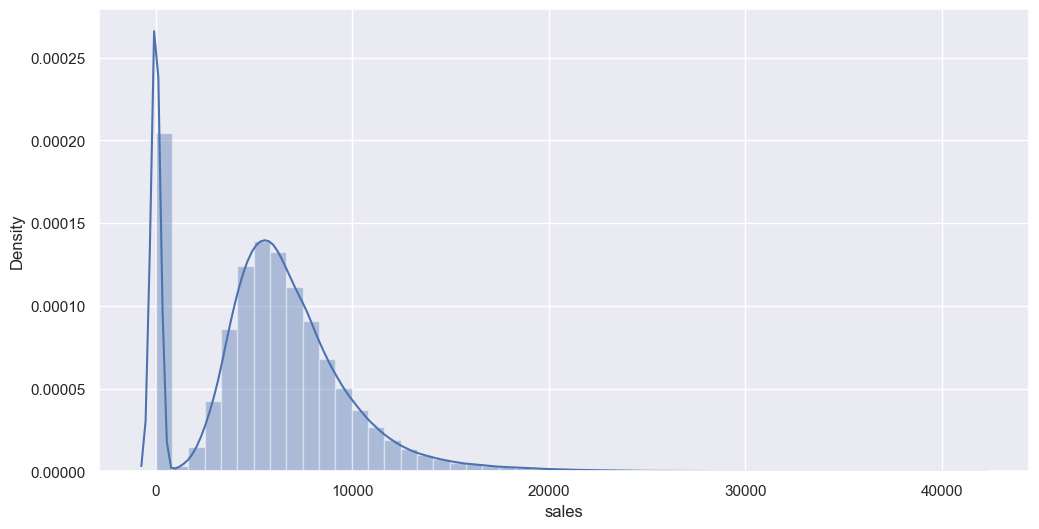

In [33]:
sns.distplot(df1['sales'])

C:\Users\alanc\AppData\Local\Temp\ipykernel_12928\3380288980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['competition_distance'])


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

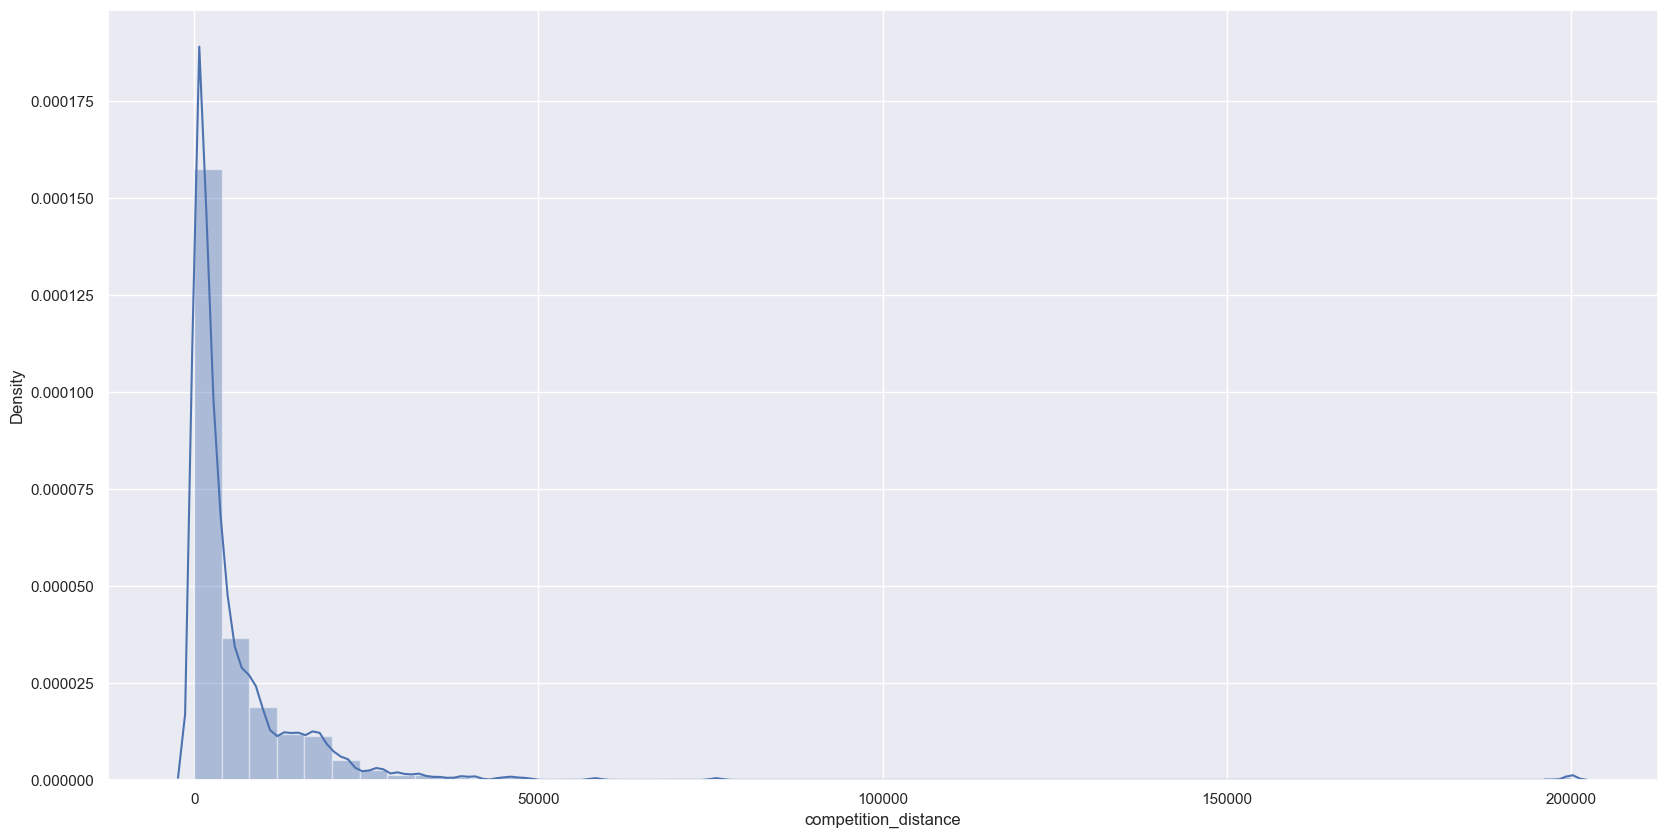

In [44]:
sns.distplot(df1['competition_distance'])

### 1.7.2. Categorical Attributes

In [21]:
# Valores únicos de cada uma das categorias 

cat_attributes.apply( lambda x: x.nunique() )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

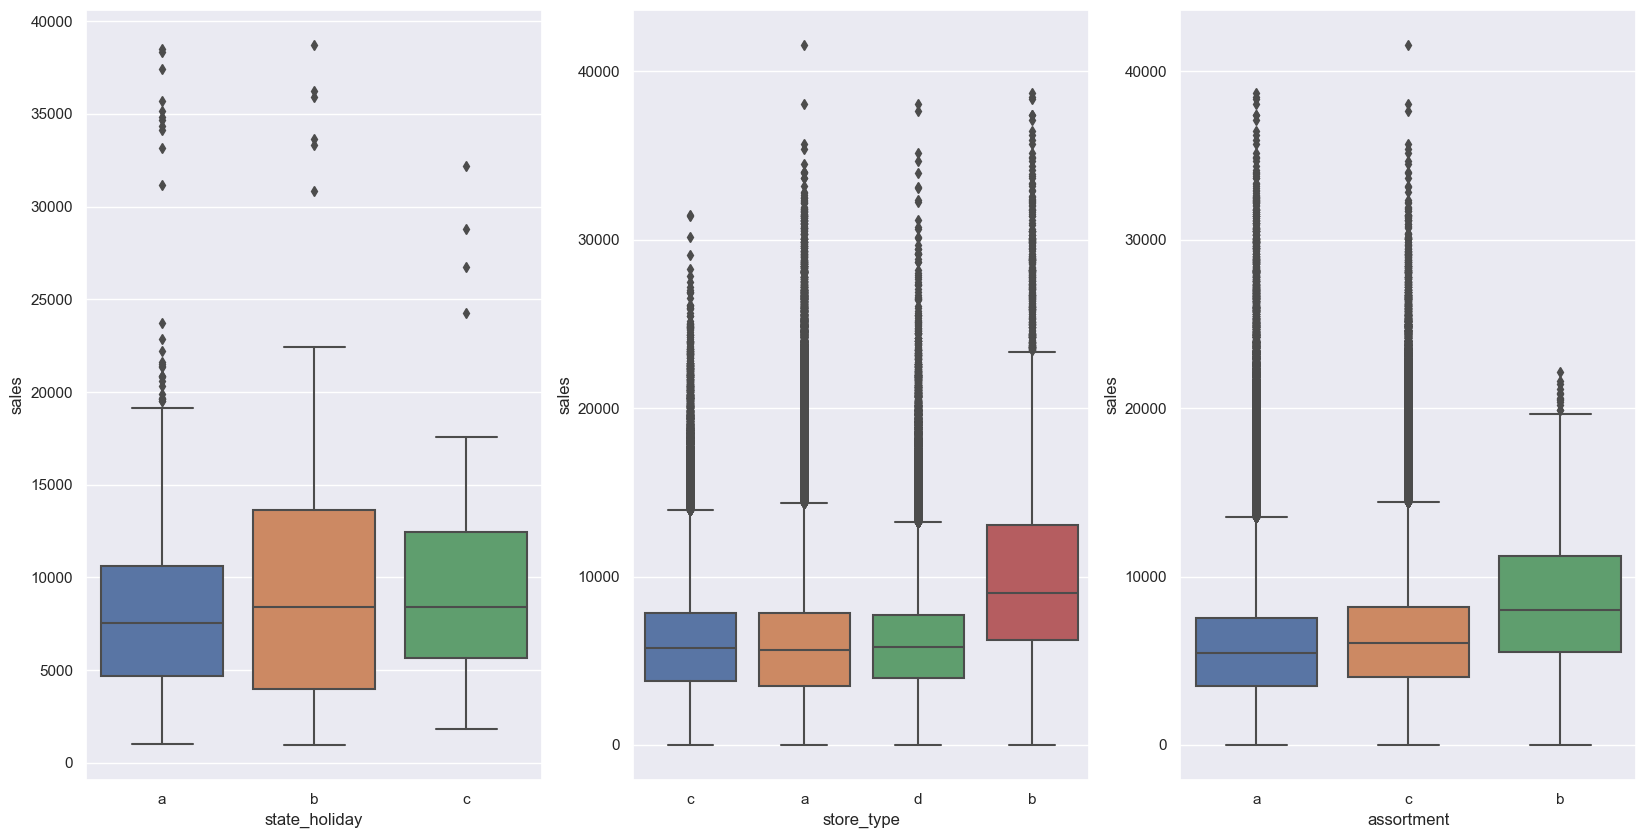

In [42]:
# Filtrar para enxergar melhor situação de loja aberta (vendas > 0) em feriados ('state_holiday' != '0') 
aux1 = df1[ (df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Performance Vendas nos Feriados
plt.subplot( 1, 3, 1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1 )

# Performance Vendas por tipo de loja
plt.subplot( 1, 3, 2)
sns.boxplot(x = 'store_type', y = 'sales', data = df1 )

# Performance Vendas por sortimento de produtos
plt.subplot( 1, 3, 3)
sns.boxplot(x = 'assortment', y = 'sales', data = df1 )

<AxesSubplot:xlabel='month_map', ylabel='sales'>

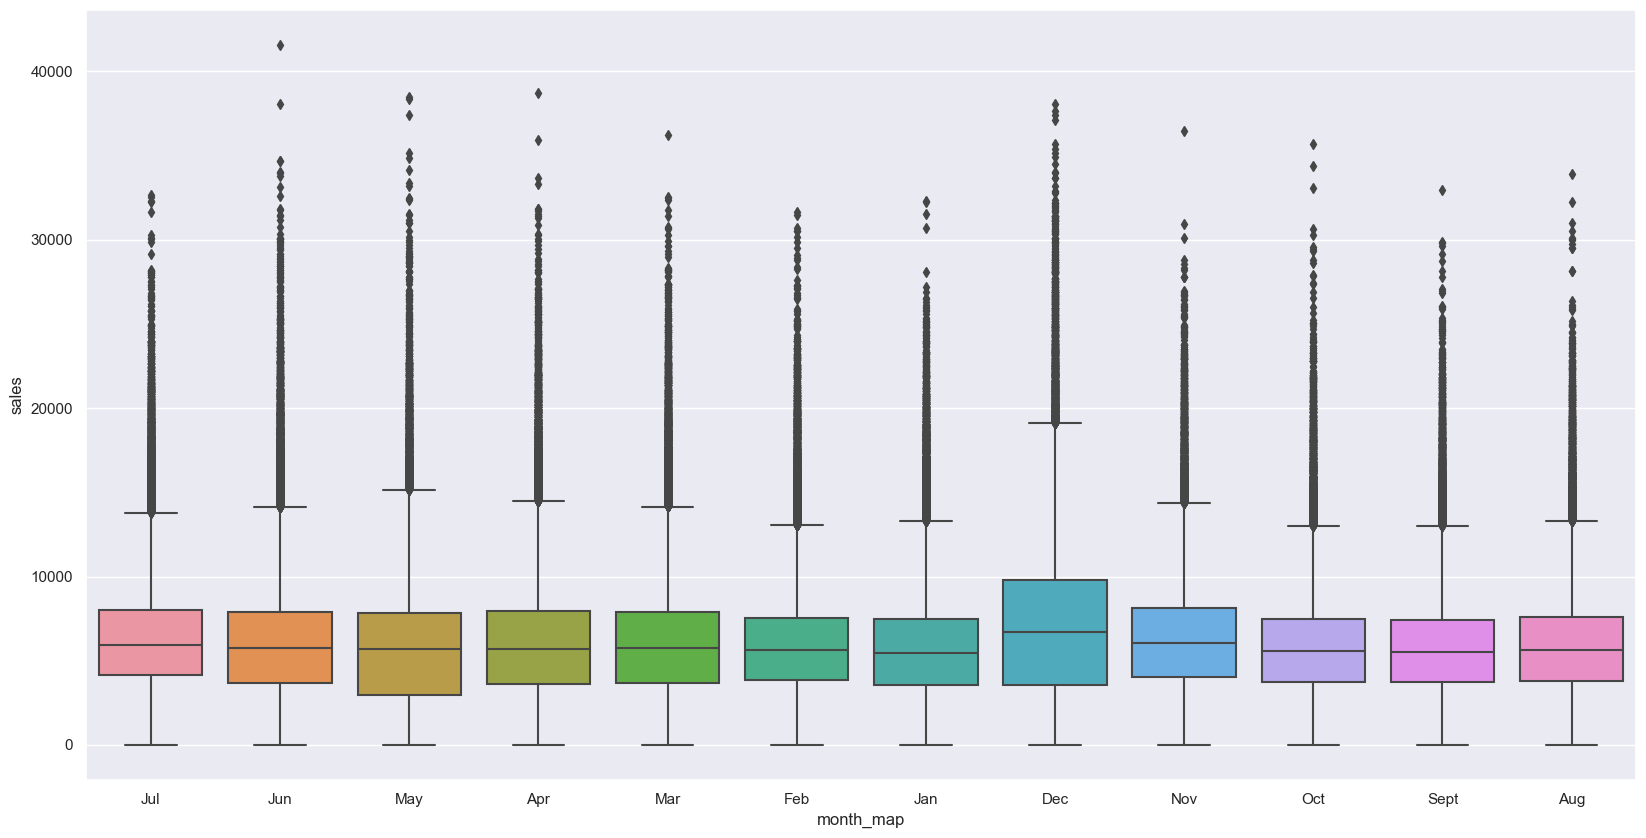

In [43]:
# Quantidade de vendas por mês

sns.boxplot(x = 'month_map', y = 'sales', data = df1 )

# 2.0. FEATURE ENGINEERING

In [15]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

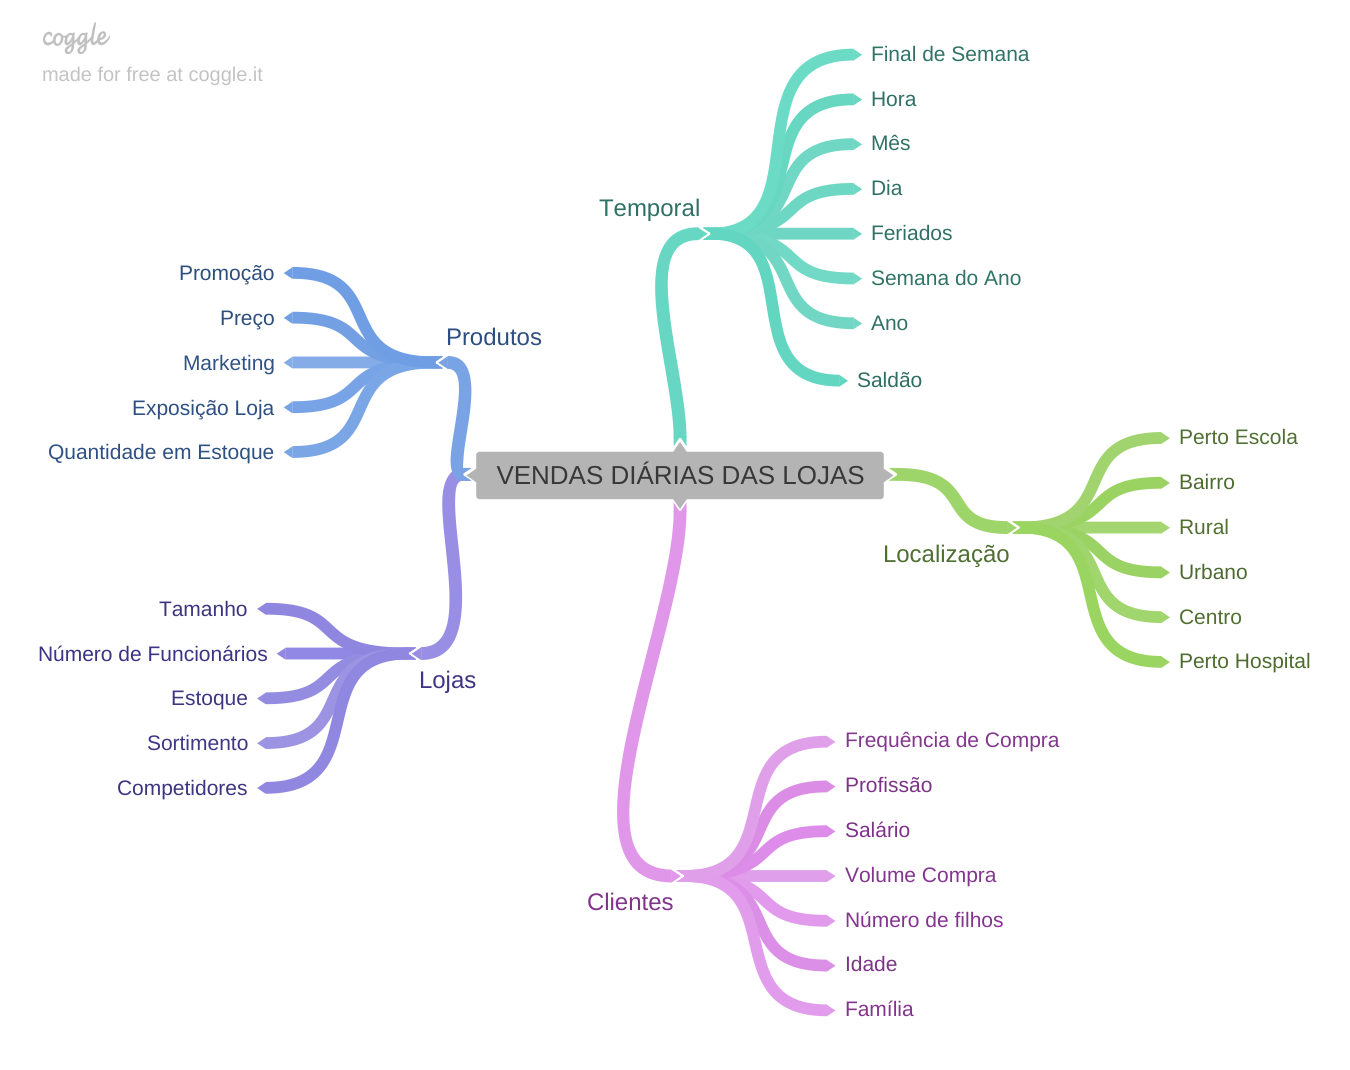

In [4]:
Image('img/VENDAS_DIARIAS_DAS_LOJAS.png')

## 2.2. Criação de Hipóteses

### 2.2.1. Hipóteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais

### 2.2.2. Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipóteses Temporal

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.


**2.** Lojas deveriam vender mais ao longo dos anos.


**3.** Lojas deveriam vender mais no segundo semestre do ano.


**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.


**5.** Lojas deveriam vender menos aos finais de semana.


**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.


**2.** Lojas com competidores mais próximos deveriam vender menos.


**3.** Lojas com competidores à mais tempo deveriam vendem mais.


**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.


**5.** Lojas com mais dias de promoção deveriam vender mais.


**6.** Lojas com mais promoções consecutivas deveriam vender mais.


**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.


**8.** Lojas deveriam vender mais ao longo dos anos.


**9.** Lojas deveriam vender mais no segundo semestre do ano.


**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.


**11.** Lojas deveriam vender menos aos finais de semana.


**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

Criação de features ou ajuste de valores features já existentes.

**Questionamento:** Quais variáveis/atributos/carac. preciso ajustar ou criar para validar as hipóteses de negócio levantadas? 

### 2.4.1. Da variável 'date'

In [16]:
# year - extrair apenas o ano de vendas daquela loja

df2['year'] = df2['date'].dt.year

# month - extrair apenas o mês de vendas daquela loja

df2['month'] = df2['date'].dt.month

# day - extrair apenas o dia de vendas daquela loja

df2['day'] = df2['date'].dt.day

# week of year - extrair apenas a semana de vendas do ano daquela loja

df2['week_of_year'] = df2['date'].dt.isocalendar().week
# (year-week) - Formatar a data para em string aparecer o ano e a semana do ano das vendas daquela loja

df2['year_week'] = df2['date'].dt.strftime("%Y-%W")



In [36]:
df2.head()

store  day_of_week       date  sales  customers  open  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year   promo_interval month_map  is_promo  year  month  day  week_of_year year_week  promo_since
0      1            5 2015-07-31   5263        555     1      1   regular_day               1          c      basic               1270.00                          9.00                      2008.00       0              31.00            2015.00                0       Jul         0  2015      7   31            31   2015-30  2015.0-31.0
1      2            5 2015-07-31   6064        625     1      1   regular_day               1          a      basic                570.00                         11.00                      2007.00       1              13.00            2010.00  Jan,Apr,Jul,Oct       Jul         1  2015      7   31            31   2015-30  2010.0-13.0
2      3            5 2015-07-31   8314        821     1      1   regular_day               1          a      basic              14130.00                         12.00                      2006.00       1              14.00            2011.00  Jan,Apr,Jul,Oct       Jul         1  2015      7   31            31   2015-30  2011.0-14.0
3      4            5 2015-07-31  13995       1498     1      1   regular_day               1          c   extended                620.00                          9.00                      2009.00       0              31.00            2015.00                0       Jul         0  2015      7   31            31   2015-30  2015.0-31.0
4      5            5 2015-07-31   4822        559     1      1   regular_day               1          a      basic              29910.00                          4.00                      2015.00       0              31.00            2015.00                0       Jul         0  2015      7   31            31   2015-30  2015.0-31.0

### 2.4.2. Das variáveis 'competition_open_since_month' e 'competition_open_since_year'

In [17]:
# competition since  

# Actions: - Juntar em um coluna só e que seja do tipo datetime a data de abertura do competidor mais próximo, como não tenho exatamente o dia, usar 1 para todos


df2['competition_since'] = df2[['competition_open_since_year','competition_open_since_month']].apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'] , day = 1 ), axis = 1)

In [18]:
# competition time month - Calculo de período entre datas

# Actions: - Criar uma nova coluna com o período (em dias) que existe competidor a partir da data de registro de venda e da abertura do competidor (date - competition since)
##         - Deve div\ 30 pois a base de comparação entre as datas possui apenas ano e mês exato(competition_since), assim, considera-se apenas a subtração de mês e ano nas datas.


df2['competition_time_month'] =( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

### 2.4.3. Das variáveis ''promo2_since_week'' e 'promo2_since_year'

In [19]:
# promo since 

# Actions: - Juntar em um coluna só a data de início da promo2, como não tenho exatamente o dia, mês e ano. Juntar ano e semana do ano como string format.
#          - Passar para datetime a coluna criada

df2['promo_since'] =  df2['promo2_since_year'].astype( str ) + "-" + df2['promo2_since_week'].astype( str )

# datetime
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7) )


In [20]:
# promo time week - - Calculo de período entre datas

# Actions: - Criar uma nova coluna com o período (em dias) que existe promoção 2 a partir da data de registro de venda e data da semana que começou a promoção (date - promo since)
##         - Deve div\ 7 pois a base de comparação entre as datas possui apenas ano e semana exato(promo_since), assim, considera-se apenas a subtração de semana e ano nas datas.

df2['promo_time_week'] =( (df2['date'] - df2['promo_since']) / 7 ).apply(lambda x: x.days ).astype( 'int64' )

### 2.4.4. Da variável 'assortment'

In [21]:
# assortment

# Actions: colocar o que significa cada sortimento de loja a, b e c. Basicamente é mudar o valor da coluna de algo categórico para sua explicação.

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

### 2.4.5. Da variável 'state_holiday'

In [22]:
# state holiday

# Actions: colocar o que significa cada feriado estadual a, b e c. Basicamente é mudar o valor da coluna de algo categórico para sua explicação.


df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. FILTRAGEM DE VARIÁVEIS

In [23]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [24]:
#'open' != 0 ,pois quero fazer previsão de vendas da loja e só terá variação de vendas se a loja está aberta caso contrário, ela terá venda zero sempre. 
# 'sales' > 0, pois quero ver nas condições onde houve venda significativa e não quando a loja não vendeu.

# Próximos módulos para testar rodar com 'sales' > 0

df3 = df3[ df3['open'] != 0 ]

## 3.2. Seleção das Colunas

In [26]:
## COLUNAS EXCLUÍDAS:

# 'customers' -> não terei ela no momento da previsão pois não tenho como saber de antemão ou seja, para as próximas seis semanas a quantidade de clientes que entrarão na loja. Variável muito momentânea. 
# Se quisesse utilizar, teria que fazer um projeto em paralelo de análise e previsão dos clientes na loja para as próximas 6 semanas para ser usado para previsão de vendas.

# open -> como ela considerara apenas condições em que a loja estará aberta, posso tirar 

# promo_interval | month_map -> variáveis auxiliares que foram utilizadas para desenvolver a coluna que analisa se a data atual de registro de venda da loja está em promoção

In [25]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop( cols_drop, axis = 1 )

# 4.0. ANÁLISE EXPLORATÓRIA DOS DADOS

In [26]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df4 = df3.copy()

# Mudando tipo de dado week_of_year para int64

df4["week_of_year"] = df4["week_of_year"].astype('int64') 

## 4.1. Análise Univariada

In [27]:
## Separar atributos/colunas em numéricas e categóricas

num_attributes_eda = df4.select_dtypes( include = ['int64','float64'] )
cat_attributes_eda = df4.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )

### 4.1.1. Response Variable

<AxesSubplot:xlabel='sales', ylabel='Count'>

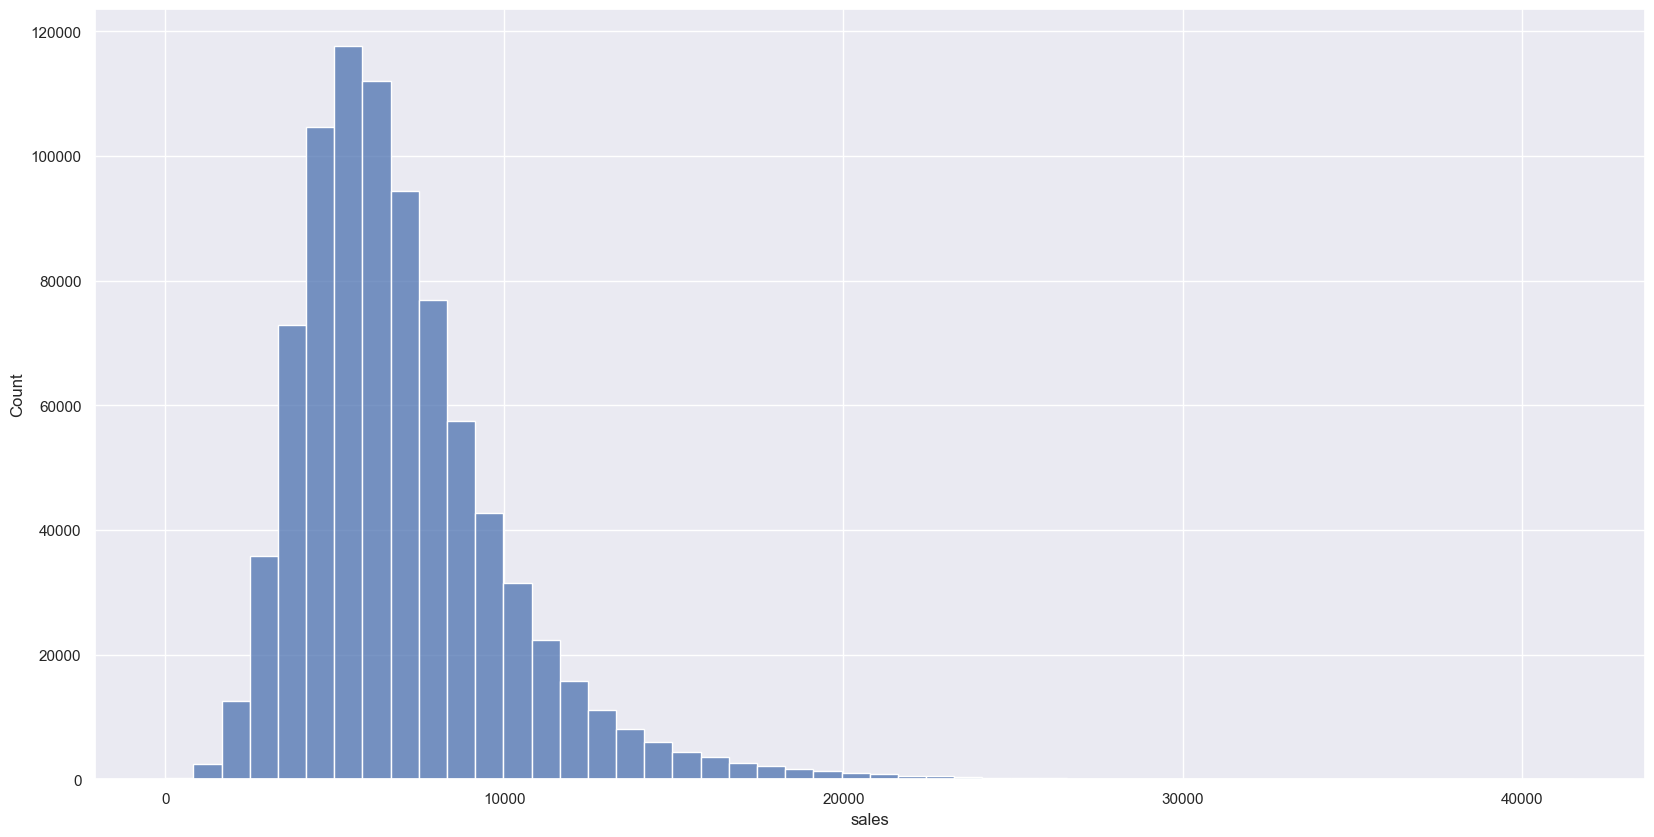

In [35]:
sns.histplot (df4['sales'], bins = 50)

In [ ]:
## Observações:

## Skew positiva, maioria de vendas(volume-frequência) mais próximo de valores menores do range, média é maior que a mediana. Vendas bastante concentradas em 600 a 700 vendas.

### 4.1.2. Numerical Variable

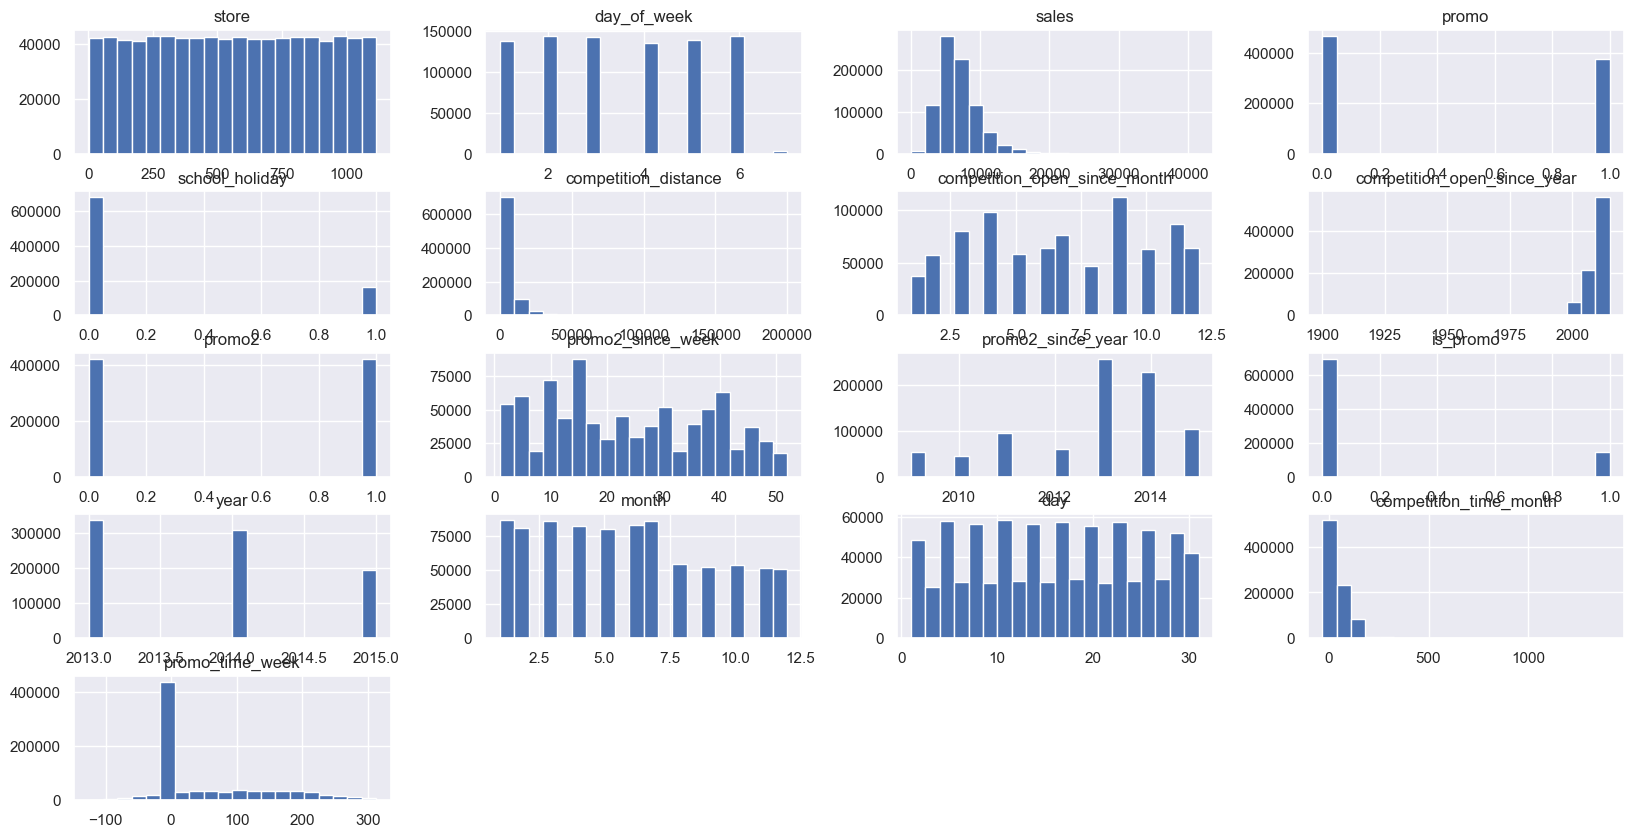

In [48]:
num_attributes_eda.hist( bins = 25 );

In [ ]:
## Observações

## Competition Distance

### Maior frequência/volume de valores(registros de vendas) menores, o que significa que grande parte das lojas possuem competidores bem próximos.

## store

### bem linear pois é um diferente do outro.-bem semelhante a frequencia de cada loja no histórico

## day_of_week

### Dias bem parelhos em termos de frequência no dataset. Dia 7 com bem menos volume de registro, talvez porque era dia da loja estar fechada.

## promo 

### Existem um pouco mais de registros no dataset de dias de vendas nas lojas sem promoção do que com.

## school_holiday 

### Existem mais registros no dataset de dias de vendas nas lojas sem feriado escolar do que com feriado, mas ainda possui registros com o feriado da escola.

### 4.1.3. Categorical Variable

In [44]:
# Valores únicos de cada uma das categorias 

cat_attributes_eda.apply( lambda x: x.nunique() )

state_holiday      4
store_type         4
assortment         3
week_of_year      52
year_week        137
dtype: int64

#### 4.1.3.1. state_holiday

<AxesSubplot:xlabel='state_holiday', ylabel='Count'>

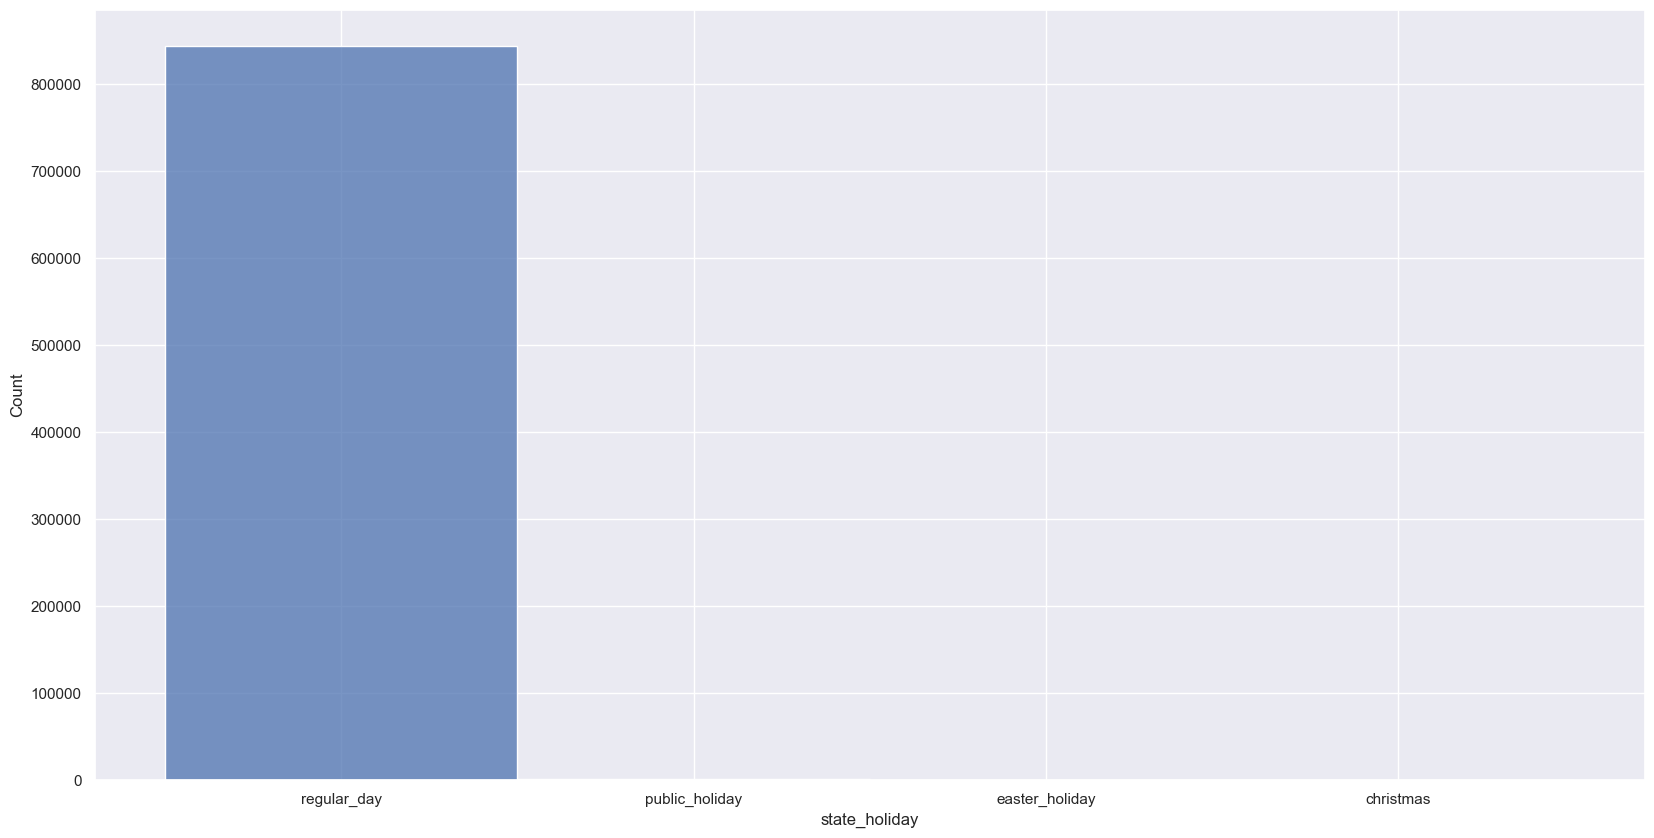

In [45]:
sns.histplot(df4['state_holiday'])

In [ ]:
## State Holiday

### Maior frequência/volume de valores(registros de vendas) ocorre em dias regulares. > 800k ocorrências contra faixa de 700 de outros dias

<AxesSubplot:xlabel='sales', ylabel='Density'>

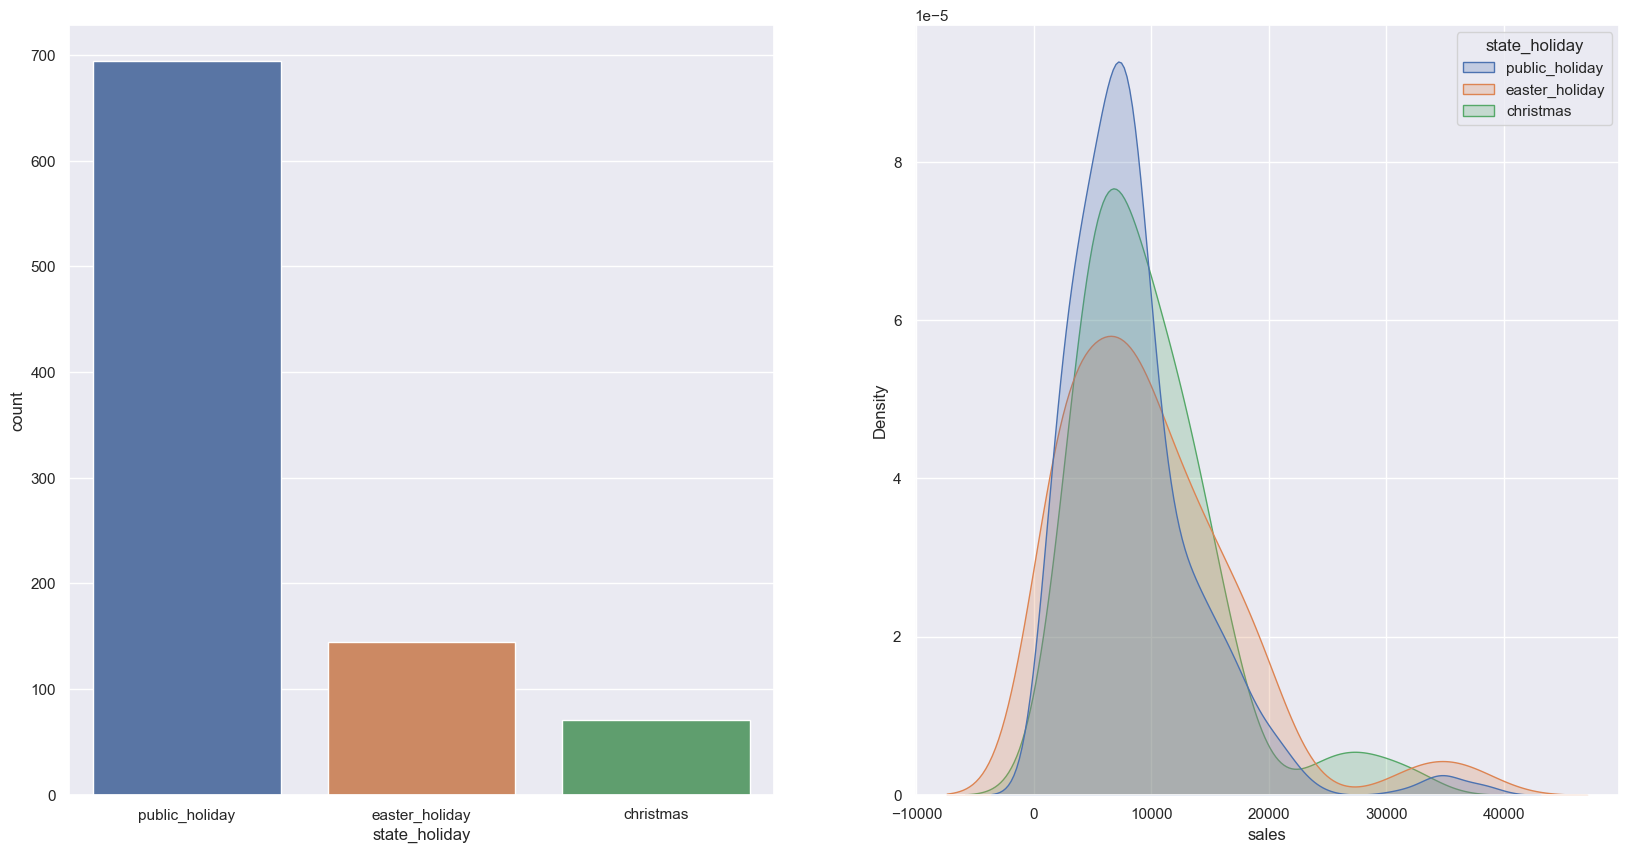

In [68]:
# Retirando os regular_day para verificar apenas dias em que são feriados e a loja abriu

a = df4[ df4['state_holiday'] != 'regular_day' ]
plt.subplot( 1, 2, 1 )
sns.countplot(x = a['state_holiday'])

plt.subplot( 1, 2, 2 )
sns.kdeplot(data=a , x='sales', hue='state_holiday', fill=True, common_norm=False )

In [ ]:
### Maior frequência/volume de valores(registros de vendas) ocorre em feriados públicos > páscoa > natal. Aparentemente pelo gráfico de distribuição de vendas por feriado, as médias de vendas no natal e páscoa são
### maiores que as de feriados públicos

#### 4.1.3.2. store_type

<AxesSubplot:xlabel='sales', ylabel='Density'>

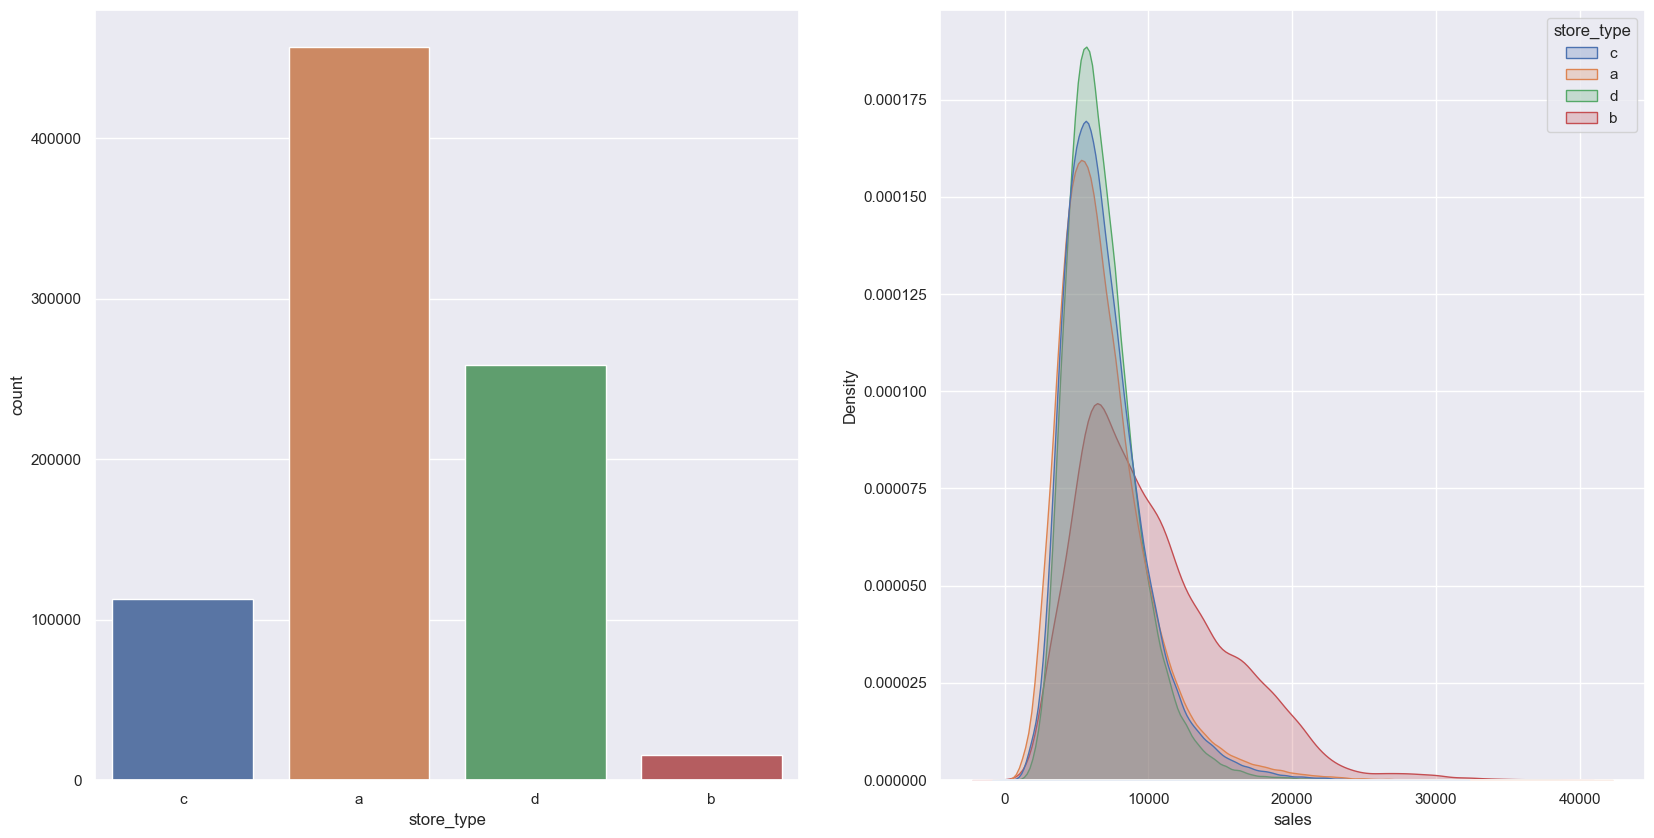

In [70]:
plt.subplot( 1, 2, 1 )
sns.countplot(x = df4['store_type'])

plt.subplot( 1, 2, 2 )
sns.kdeplot(data= df4 , x='sales', hue='store_type', fill=True, common_norm=False )

In [ ]:
### Maior frequência/volume de valores(registros de vendas) ocorre em tipos de lojas a >> d >> c >> b. Aparentemente pelo gráfico de distribuição de vendas por tipo de loja, a média de vendas no tipo de loja b é 
### maior que a média de vendas em outros tipos de loja que possuem distribuição mais similares entre si. 

## VARIÁVEL APARENTEMENTE RELEVANTE PARA O MODELO

#### 4.1.3.3. assortment

<AxesSubplot:xlabel='sales', ylabel='Density'>

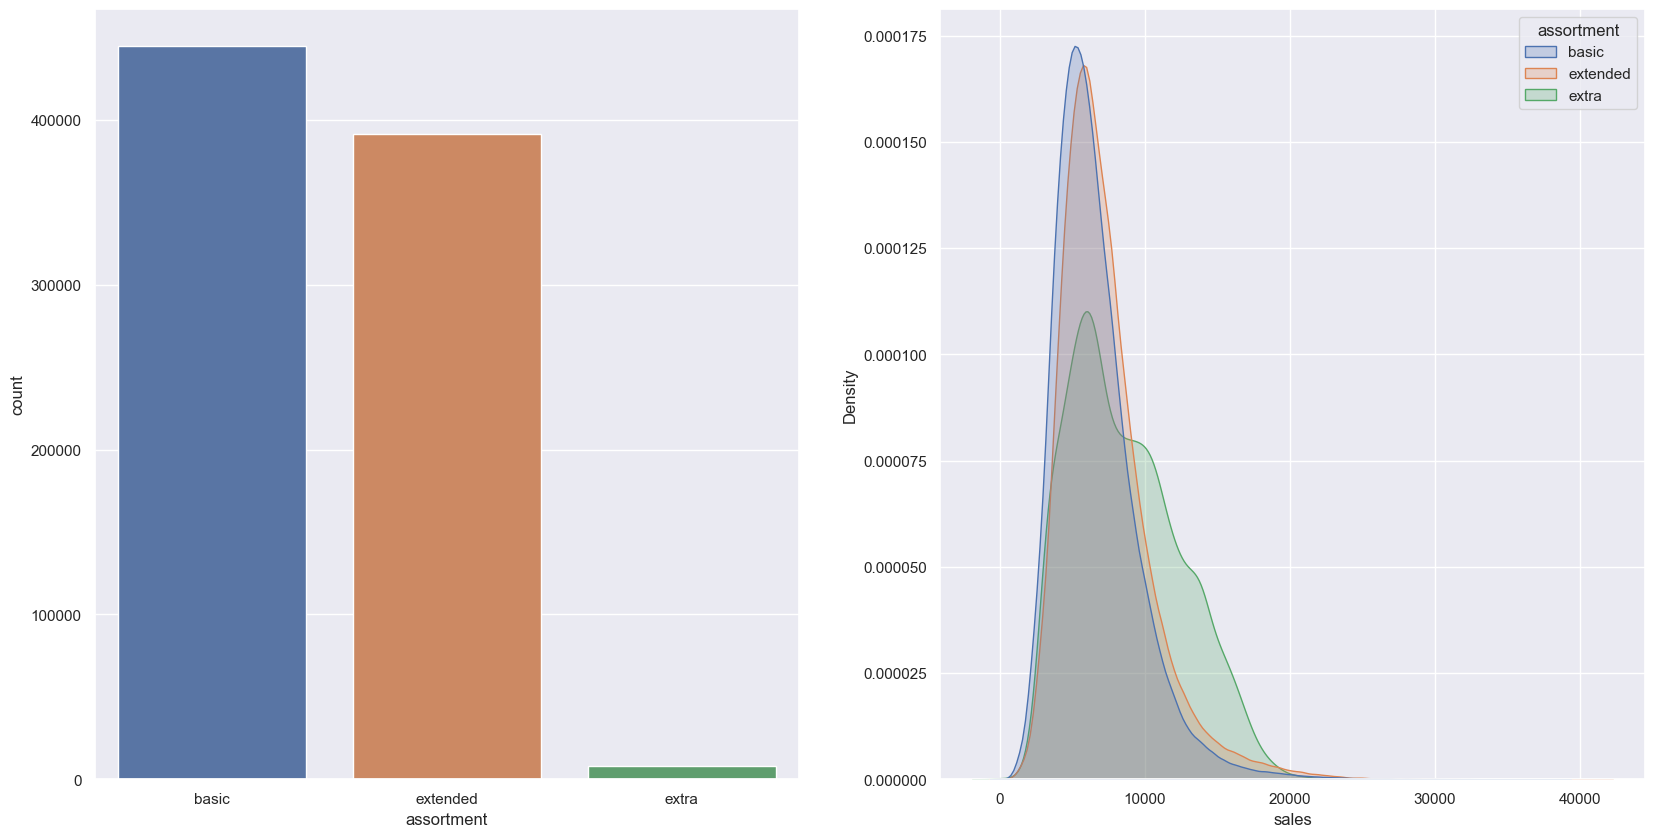

In [73]:
plt.subplot( 1, 2, 1 )
sns.countplot(x = df4['assortment'])

plt.subplot( 1, 2, 2 )
sns.kdeplot(data= df4 , x='sales', hue='assortment', fill=True, common_norm=False )

In [ ]:
### Maior frequência/volume de valores(registros de vendas) ocorre em lojas com sortimento de produtos basic >= extended >>> extra. Aparentemente pelo gráfico de distribuição de vendas por sortimento de produtos 
## das lojas, a média de vendas em lojas extra é maior que a média de vendas em outros tipos de loja que possuem distribuição mais similares entre si. 

## VARIÁVEL APARENTEMENTE RELEVANTE PARA O MODELO

#### 4.1.3.4. week_of_year

C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\seaborn\distributions.py:497: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\seaborn\distributions.py:498: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


<AxesSubplot:xlabel='week_of_year', ylabel='Count'>

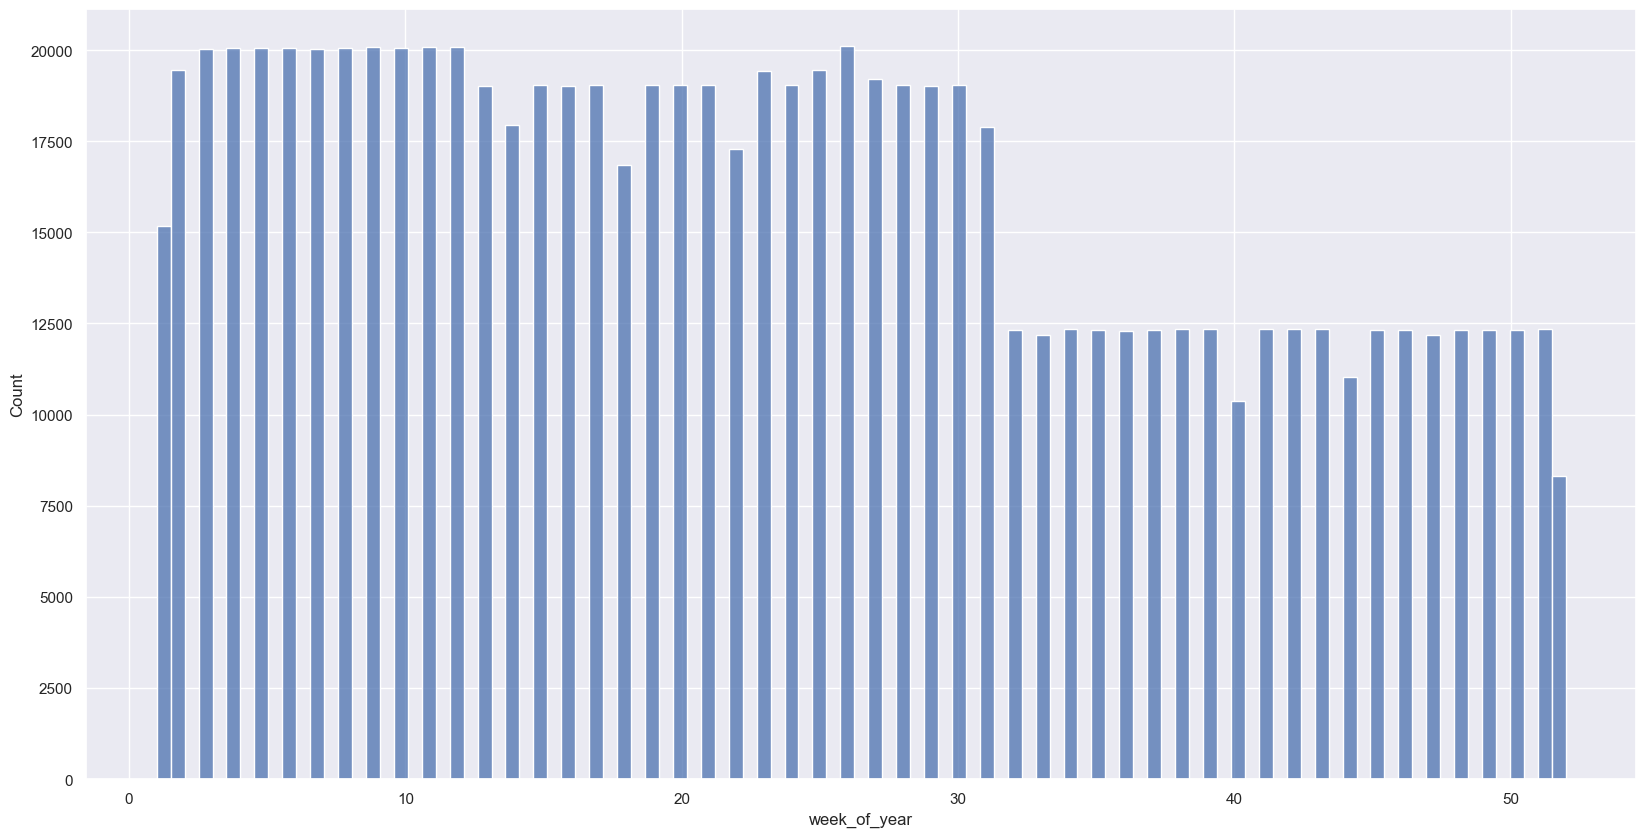

In [75]:
sns.histplot(x = df4['week_of_year'])

#### 4.1.3.5. year_week

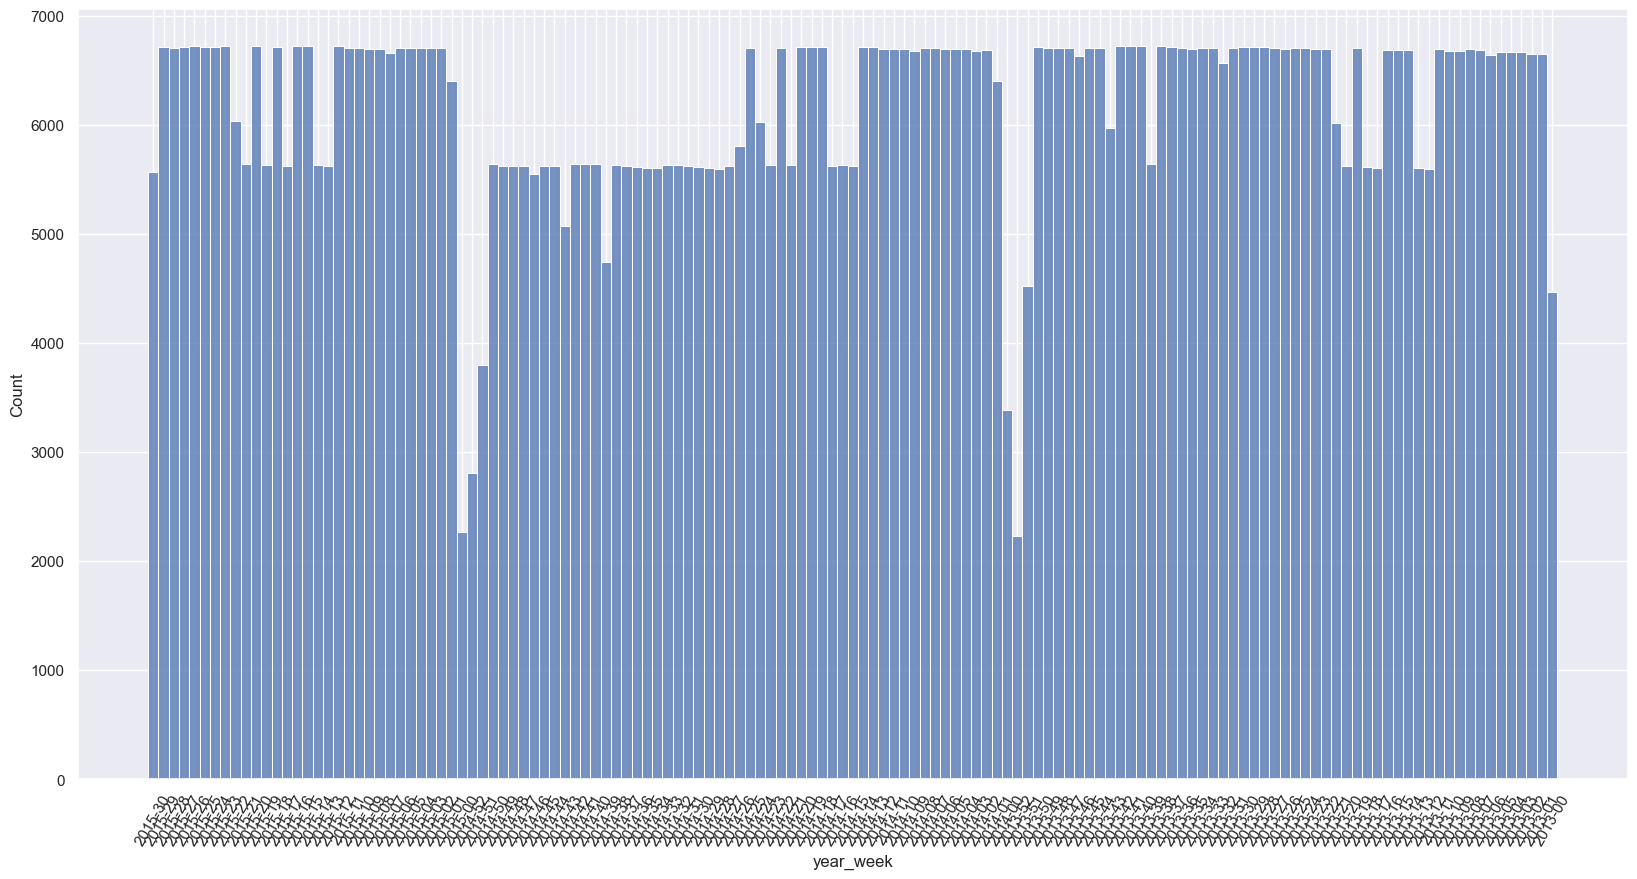

In [62]:
sns.histplot(df4['year_week']);
plt.xticks(rotation=60);

## 4.2. Análise Bivariada

Validação das Hipóteses

### 4.2.1.  H1. Lojas com maior sortimentos deveriam vender mais, em média. VERDADEIRO

**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

In [ ]:
### Assumindo:

## 1. Ordem de grandeza de sortimento por classificação: extra > extended > basic

In [56]:
## Média de vendas das lojas por classificação de sortimento de produtos 

aux1 = df4[['sales','assortment']].groupby("assortment").mean().reset_index()
df4[['sales','assortment']].groupby("assortment").mean()

sales
assortment        
basic      6621.02
extended   7300.53
extra      8639.35

Text(0.5, 1.0, 'Mean Sales per Store Assortment')

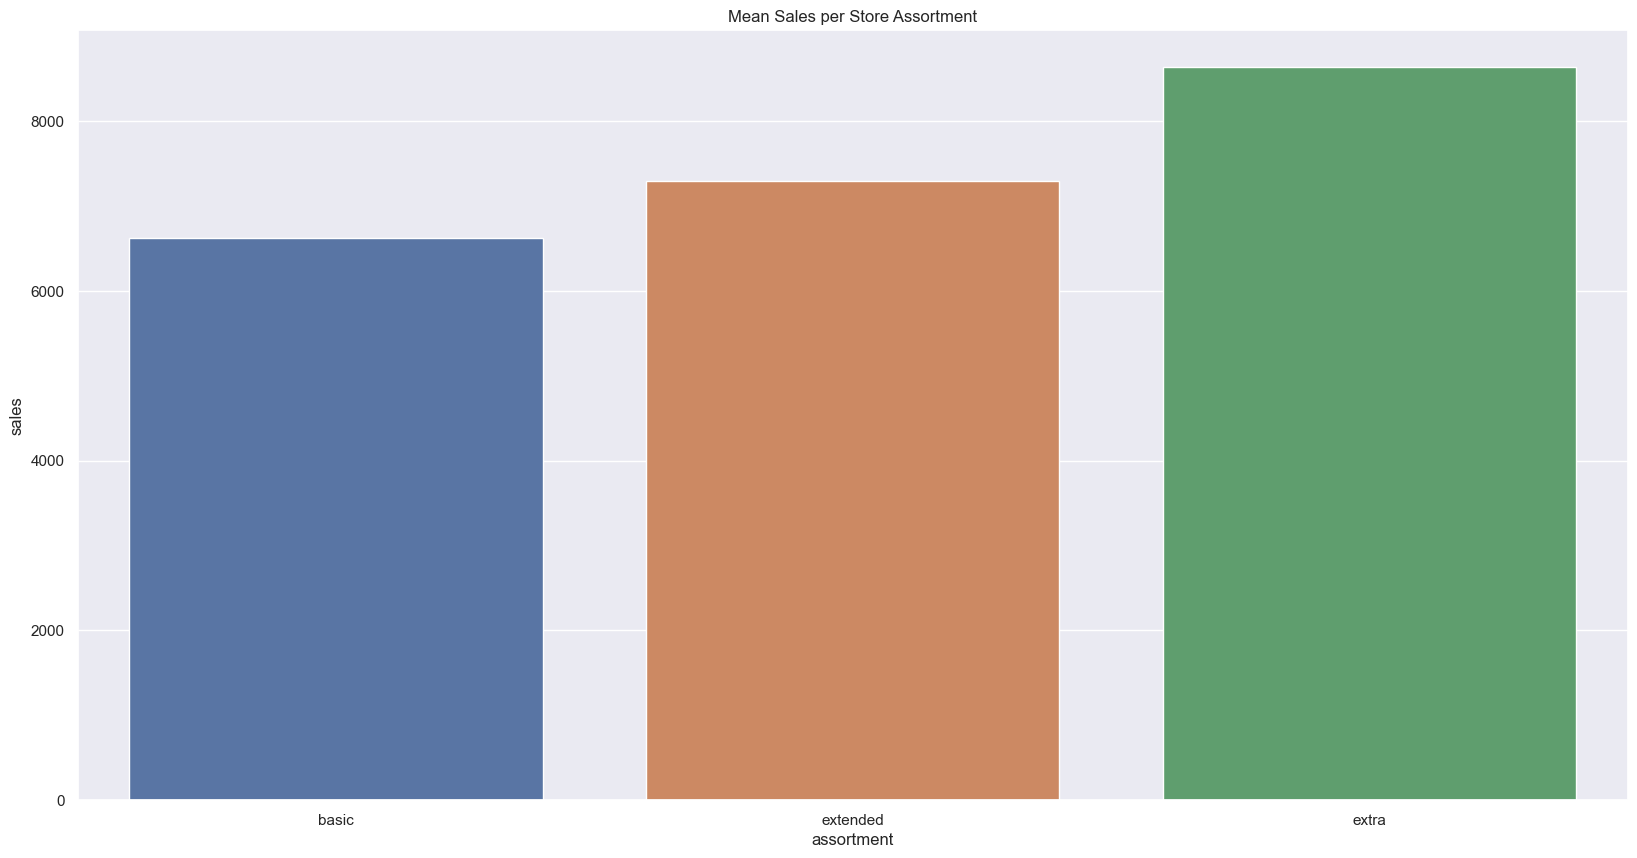

In [98]:
sns.barplot(data = aux1 , x = 'assortment' , y = 'sales').set_title("Mean Sales per Store Assortment")


In [105]:
### Média de vendas de lojas por semana do ano por sortimento - (Investigando além)

aux2 = df4[['sales','assortment','year_week']].groupby(['year_week',"assortment"]).mean().reset_index()
df4[['sales','assortment','year_week']].groupby(['year_week',"assortment"]).mean()

sales
year_week assortment        
2013-00   basic      5642.28
          extended   6094.00
          extra      5282.43
2013-01   basic      7307.46
          extended   7553.62
...                      ...
2015-29   extended   6327.46
          extra      9111.43
2015-30   basic      7950.07
          extended   9084.51
          extra      9704.20

[411 rows x 1 columns]

Text(0.5, 1.0, 'Mean Sales per Week of Year per Store Assortment')

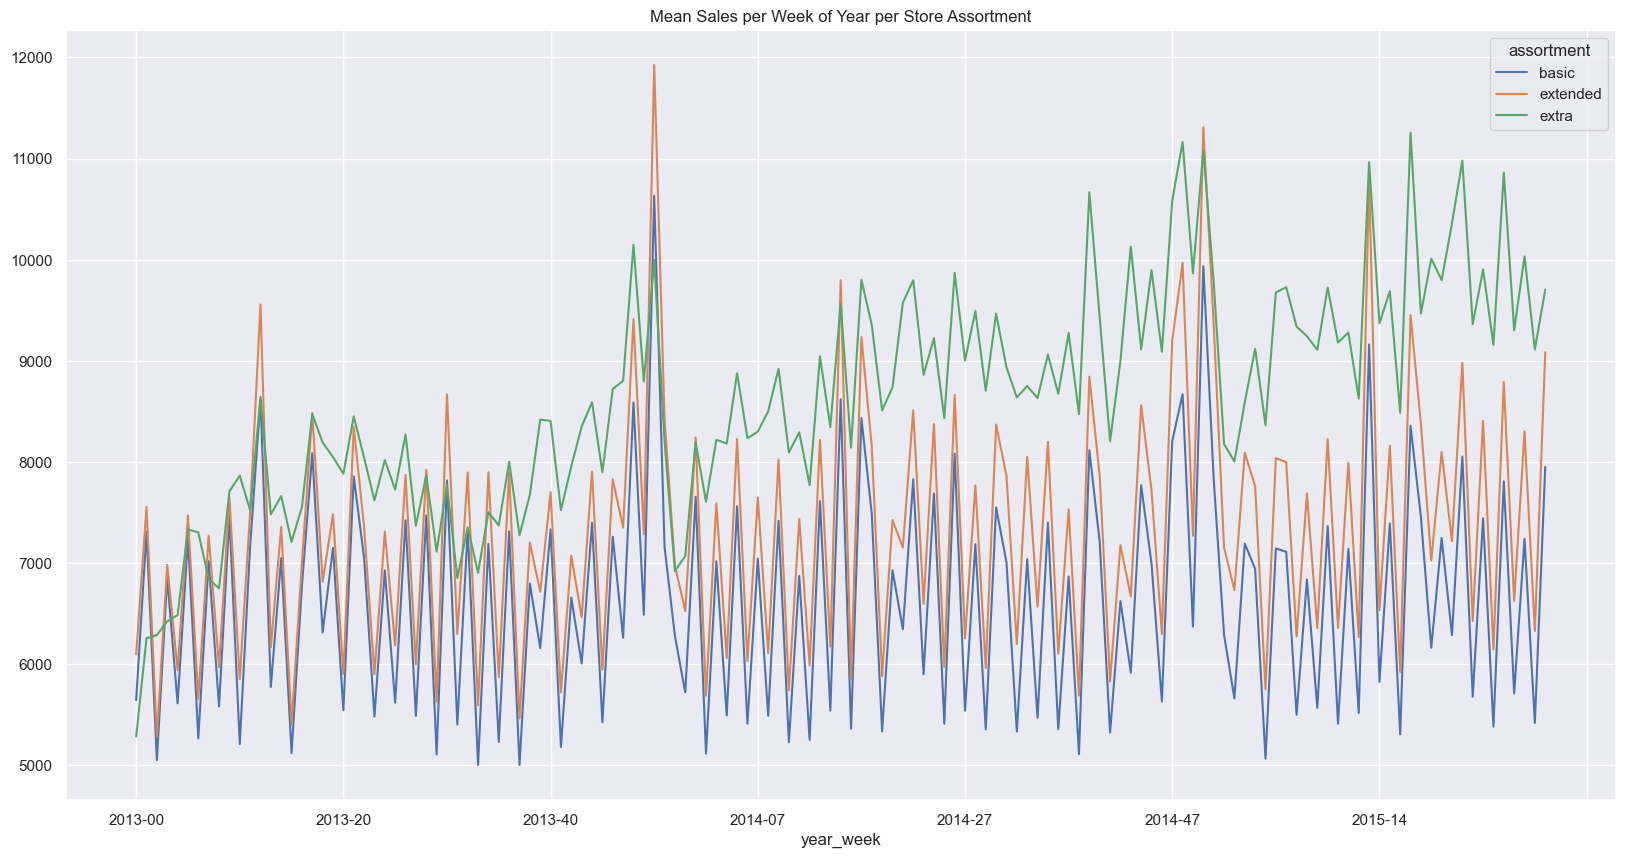

In [106]:
aux2.pivot_table(index = 'year_week', columns = 'assortment', values = 'sales').plot().set_title("Mean Sales per Week of Year per Store Assortment")

#### 4.2.1.1. Período de registros de venda (date)

In [77]:
# 01/01/2013

df4['date'].min()

Timestamp('2013-01-01 00:00:00')

In [78]:
# 31/07/2015

df4['date'].max()

Timestamp('2015-07-31 00:00:00')

In [ ]:
## Existem 1017209 combinações (registros) de datas com lojas referentes a quantidade de vendas

#### 4.2.1.2. Quantidade de Lojas únicas 

In [80]:
df4['store'].nunique()

1115

In [81]:
# Quais?

df4['store'].sort_values().unique()


array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

#### 4.2.1.3. Quantidade de Lojas únicas por sortimento

In [85]:
df4[['store','assortment']].groupby('assortment').nunique()

store
assortment       
basic         593
extended      513
extra           9

#### 4.2.1.4. Datas únicas em registro

In [86]:
df4['date'].nunique()

942

#### 4.2.1.5. Quantidade de lojas distintas abertas por data 

In [89]:
df4[['store','date']].groupby('date').nunique().head(40)

store
date             
2013-01-01     17
2013-01-02   1111
2013-01-03   1109
2013-01-04   1108
2013-01-05   1107
2013-01-06     19
2013-01-07   1106
2013-01-08   1105
2013-01-09   1105
2013-01-10   1105
2013-01-11   1105
2013-01-12   1105
2013-01-13     18
2013-01-14   1105
2013-01-15   1105
2013-01-16   1105
2013-01-17   1107
2013-01-18   1106
2013-01-19   1107
2013-01-20     19
2013-01-21   1107
2013-01-22   1107
2013-01-23   1107
2013-01-24   1108
2013-01-25   1108
2013-01-26   1108
2013-01-27     20
2013-01-28   1107
2013-01-29   1107
2013-01-30   1108
2013-01-31   1108
2013-02-01   1109
2013-02-02   1109
2013-02-03     19
2013-02-04   1109
2013-02-05   1109
2013-02-06   1109
2013-02-07   1108
2013-02-08   1109
2013-02-09   1109

<AxesSubplot:xlabel='date'>

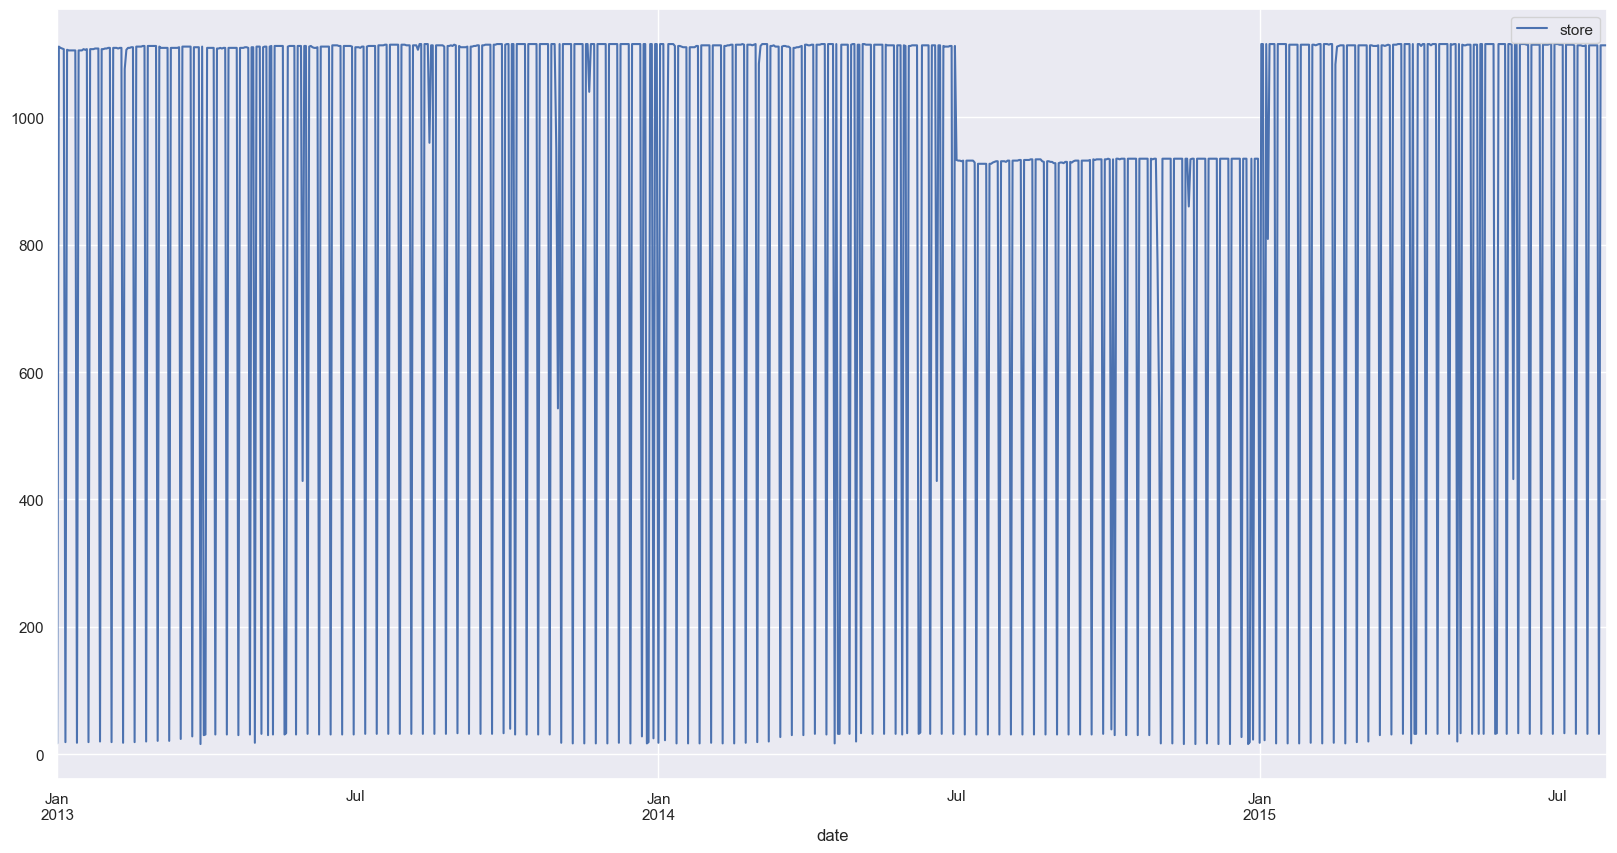

In [88]:
df4[['store','date']].groupby('date').nunique().plot()

#### 4.2.1.5. Quantidade de lojas distintas que abriram ao menos um dia da semana por semana de ano 

In [90]:
df4[['store','year_week']].groupby('year_week').nunique().head(40)

store
year_week       
2013-00     1111
2013-01     1106
2013-02     1107
2013-03     1108
2013-04     1109
2013-05     1110
2013-06     1111
2013-07     1112
2013-08     1112
2013-09     1111
2013-10     1110
2013-11     1111
2013-12     1111
2013-13     1109
2013-14     1110
2013-15     1109
2013-16     1111
2013-17     1111
2013-18     1112
2013-19     1112
2013-20     1112
2013-21     1112
2013-22     1113
2013-23     1111
2013-24     1113
2013-25     1113
2013-26     1112
2013-27     1112
2013-28     1114
2013-29     1115
2013-30     1114
2013-31     1115
2013-32     1115
2013-33     1113
2013-34     1114
2013-35     1113
2013-36     1113
2013-37     1114
2013-38     1115
2013-39     1115

<AxesSubplot:xlabel='year_week'>

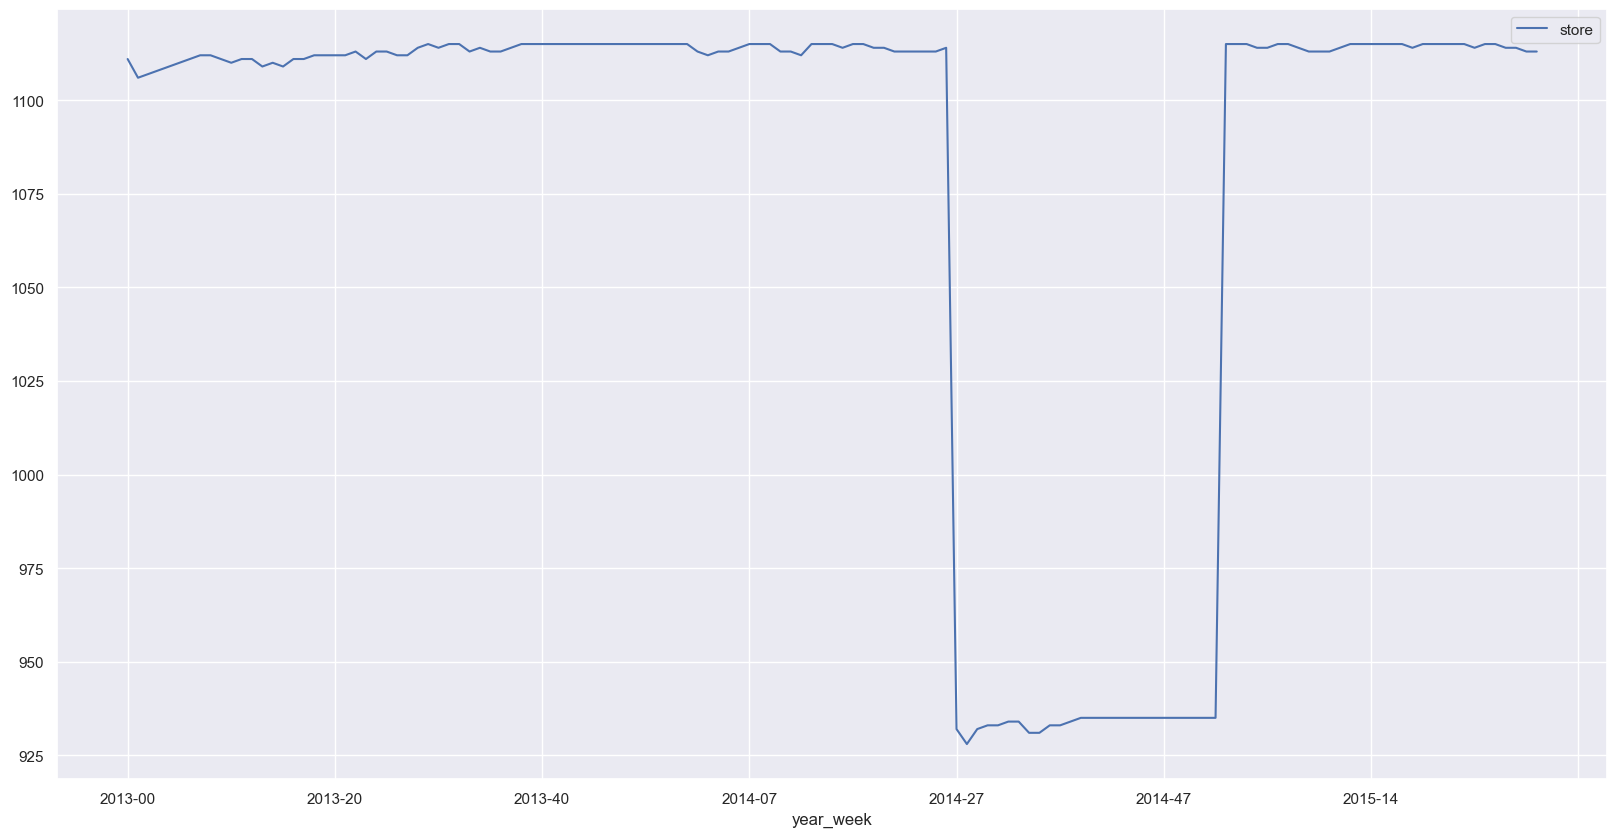

In [91]:
df4[['store','year_week']].groupby('year_week').nunique().plot()

#### 4.2.1.6. Quantidade de lojas distintas abertas por semana do ano por sortimento 

In [100]:
df4[['store','year_week','assortment']].groupby(['year_week','assortment']).nunique().head(40)

store
year_week assortment       
2013-00   basic         592
          extended      510
          extra           9
2013-01   basic         592
          extended      506
          extra           8
2013-02   basic         592
          extended      506
          extra           9
2013-03   basic         592
          extended      507
          extra           9
2013-04   basic         592
          extended      509
          extra           8
2013-05   basic         592
          extended      509
          extra           9
2013-06   basic         592
          extended      510
          extra           9
2013-07   basic         592
          extended      511
          extra           9
2013-08   basic         592
          extended      511
          extra           9
2013-09   basic         592
          extended      510
          extra           9
2013-10   basic         592
          extended      510
          extra           8
2013-11   basic         592
          extended      511
          extra           8
2013-12   basic         592
          extended      510
          extra           9
2013-13   basic         592

<AxesSubplot:xlabel='year_week'>

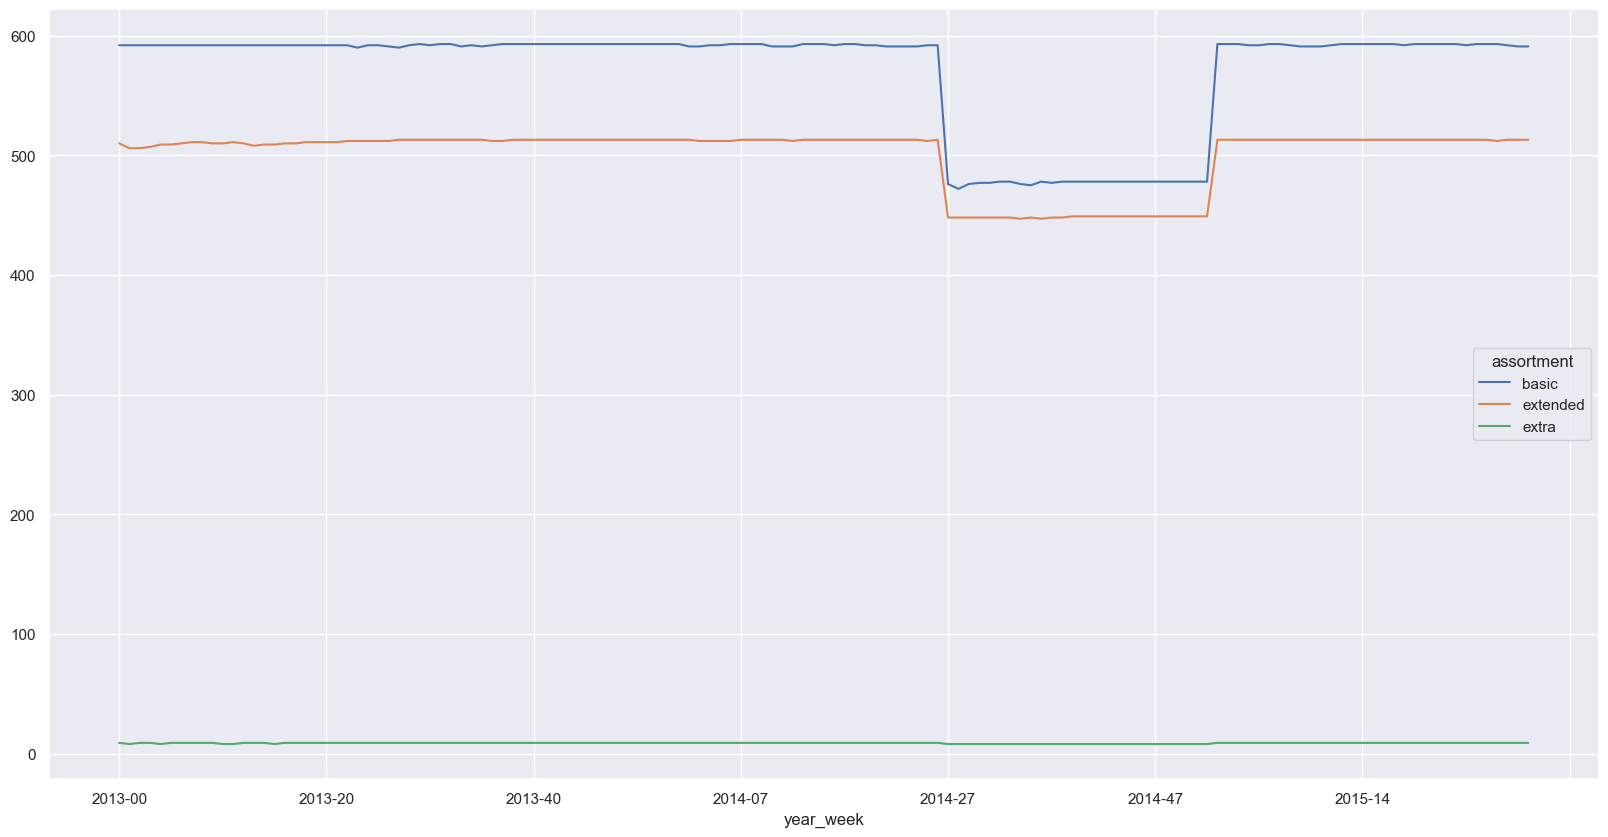

In [104]:
aux3 = df4[['store','year_week','assortment']].groupby(['year_week','assortment']).nunique().reset_index()
aux3.pivot_table(index = 'year_week', columns = 'assortment', values = 'store').plot()

### 4.2.2. H2. Lojas com competidores mais próximos deveriam vender menos, em média. 
**FALSO:** Lojas com competidores mais próximos não vendem menos, mas também não vendem mais. 

Venda não tem proporcionalidade com a distância do competidor.

**Conclusão:**

Gera Insight ? Sim, gera surpresa e desfaz crença.


Pode ser relevante para o modelo? Não

#### 4.2.2.1. Distribuição das distância de competidores no dataset

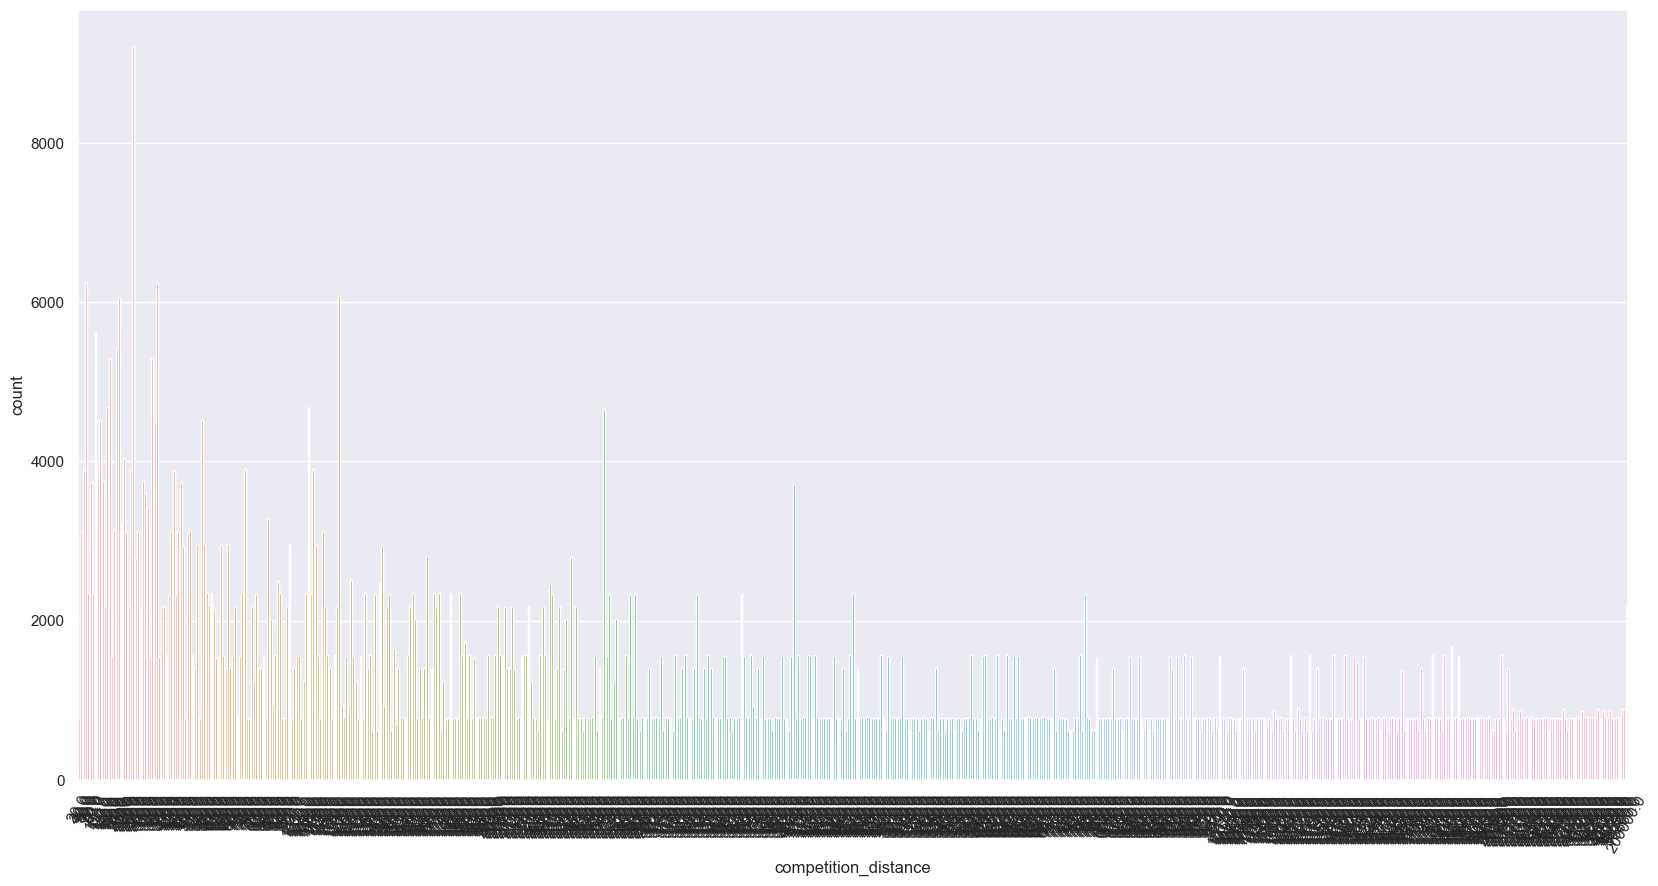

In [37]:
sns.countplot(x = df4['competition_distance'])
plt.xticks(rotation=60);

#### 4.2.2.2. Desenvolvimento 

In [28]:
aux4 = df4[['sales','competition_distance']].groupby('competition_distance').mean().reset_index()
df4[['sales','competition_distance']].groupby('competition_distance').mean()

sales
competition_distance        
20.00                5879.08
30.00                5633.08
40.00                7522.27
50.00                9735.29
60.00                9431.41
...                      ...
46590.00             4534.43
48330.00             4845.23
58260.00             6462.01
75860.00             7775.45
200000.00            5482.08

[655 rows x 1 columns]

<AxesSubplot:xlabel='competition_distance', ylabel='sales'>

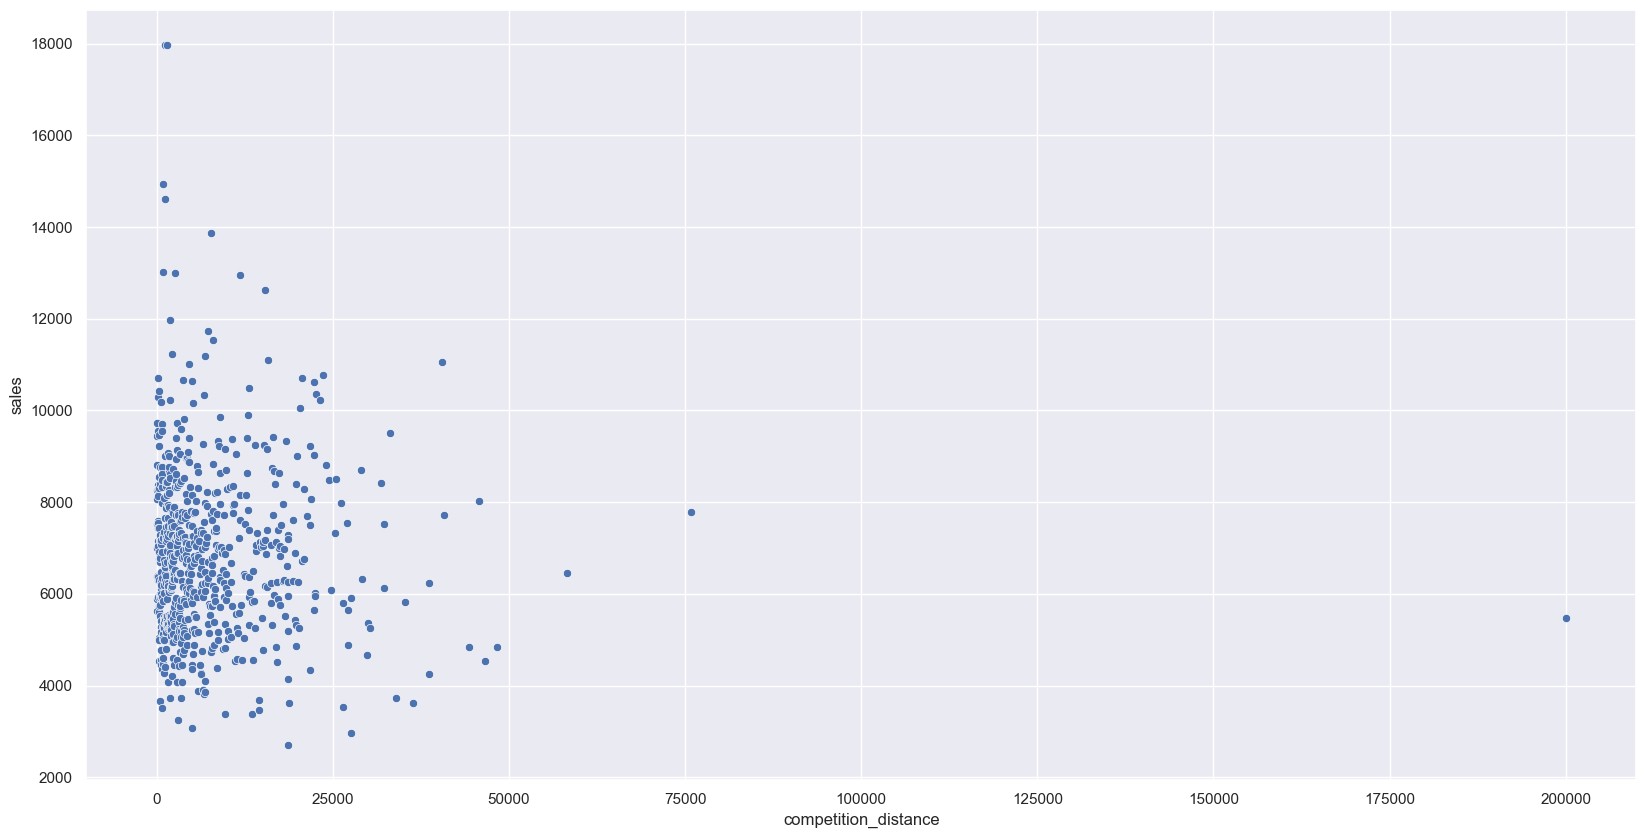

In [109]:
## Quando tenho duas variáveis numéricas bem granulares

sns.scatterplot(data= aux4, x="competition_distance", y="sales")


In [45]:
## Criando variável categórica quantitativa para juntar as distâncias

bins = list(np.arange(0, 200001, 10000))

aux4["competition_distance_grouped"] = pd.cut( aux4["competition_distance"] , bins = bins )

In [46]:
## Agrupando datataset por distância do competidor agrupada

aux5 = aux4[['sales','competition_distance_grouped']].groupby("competition_distance_grouped").mean().reset_index()
aux4[['sales','competition_distance_grouped']].groupby("competition_distance_grouped").mean()

sales
competition_distance_grouped        
(0, 10000]                   6848.64
(10000, 20000]               6794.68
(20000, 30000]               7296.10
(30000, 40000]               5986.79
(40000, 50000]               6833.15
(50000, 60000]               6462.01
(60000, 70000]                   NaN
(70000, 80000]               7775.45
(80000, 90000]                   NaN
(90000, 100000]                  NaN
(100000, 110000]                 NaN
(110000, 120000]                 NaN
(120000, 130000]                 NaN
(130000, 140000]                 NaN
(140000, 150000]                 NaN
(150000, 160000]                 NaN
(160000, 170000]                 NaN
(170000, 180000]                 NaN
(180000, 190000]                 NaN
(190000, 200000]             5482.08

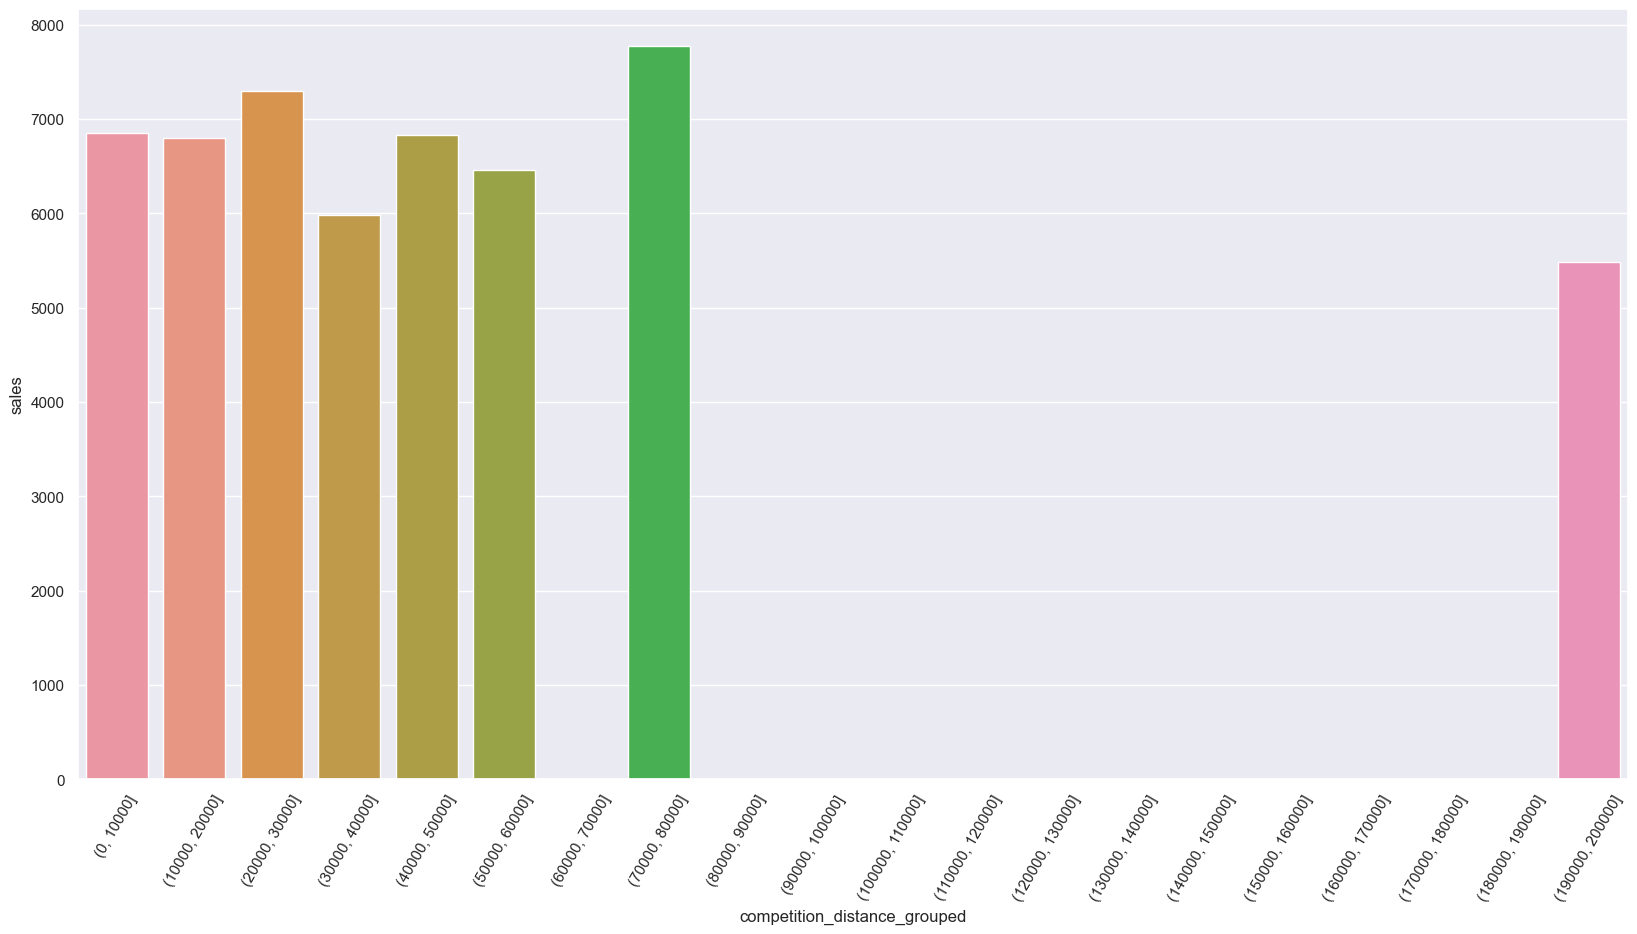

In [49]:
## Gráfico de Barras para analisar a venda média por grupos de lojas com distância de competidor próximas

sns.barplot(x = 'competition_distance_grouped' , y = 'sales' , data = aux5);
plt.xticks(rotation = 60);

In [ ]:
## Correlação entre as variáveis

<AxesSubplot:>

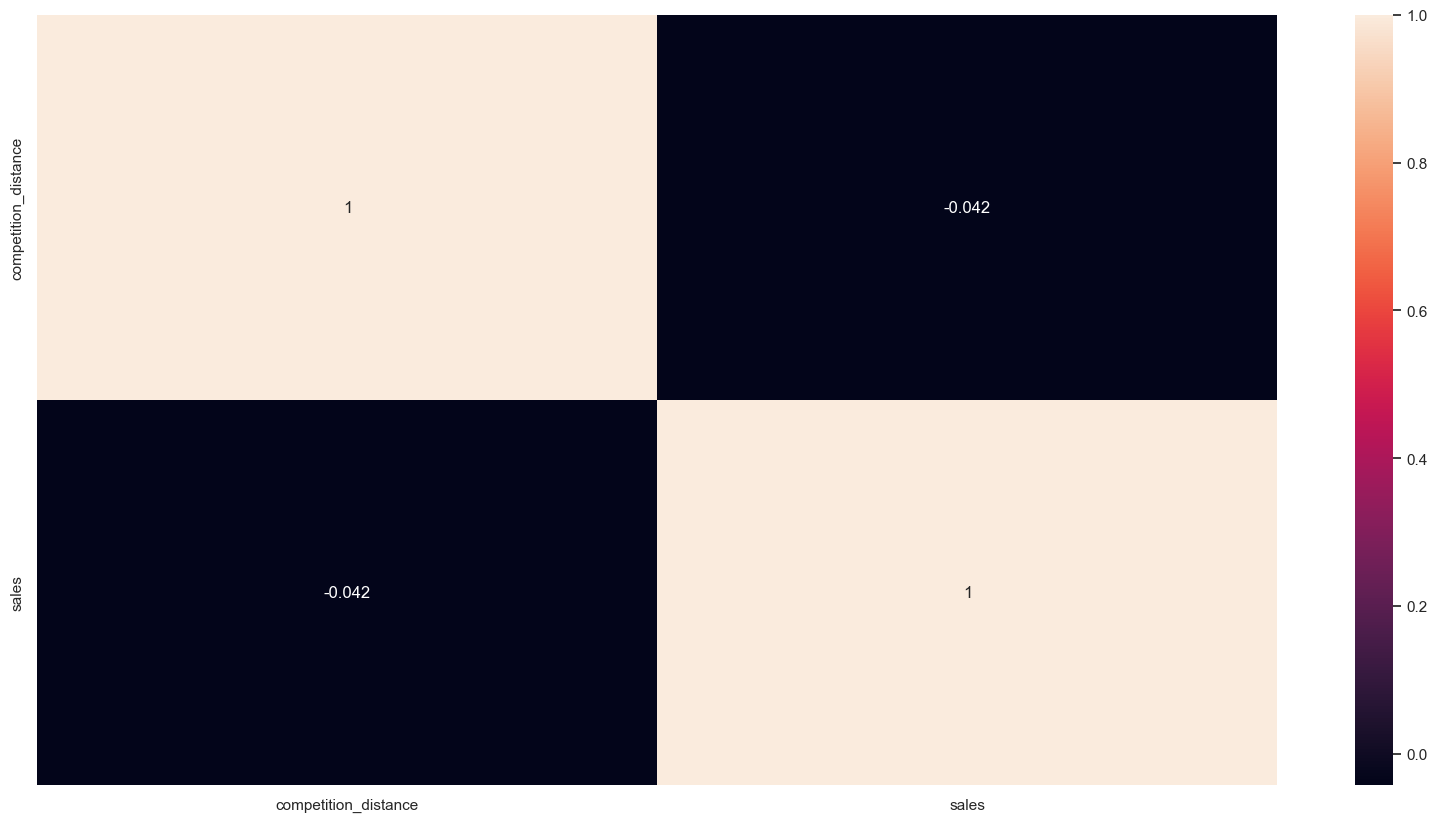

In [53]:
sns.heatmap( df4[['competition_distance','sales']].corr( method = 'pearson' ), annot = True )

#### 4.2.2.3. Dashboard 

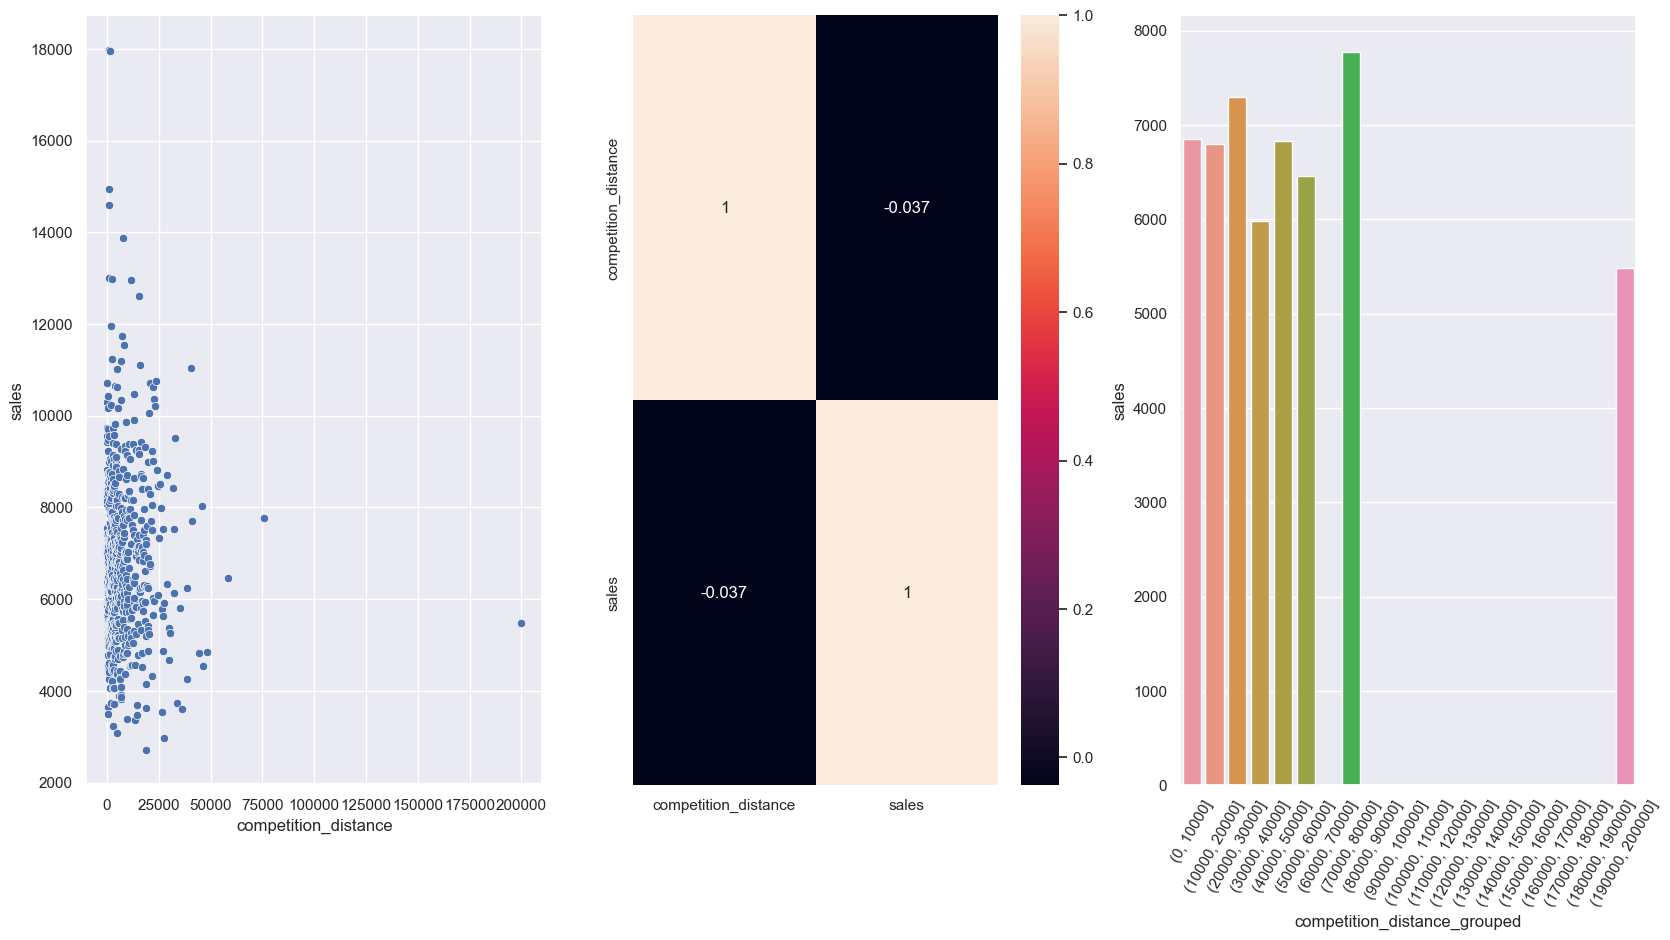

In [54]:
# 1

aux4 = df4[['sales','competition_distance']].groupby('competition_distance').mean().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot(data= aux4, x="competition_distance", y="sales")

# 2

plt.subplot( 1, 3, 2)
sns.heatmap( aux4.corr( method = 'pearson' ), annot = True )

# 3

bins = list(np.arange(0, 200001, 10000))

aux4["competition_distance_grouped"] = pd.cut( aux4["competition_distance"] , bins = bins )

aux5 = aux4[['sales','competition_distance_grouped']].groupby("competition_distance_grouped").mean().reset_index()

plt.subplot( 1, 3, 3)
sns.barplot(x = 'competition_distance_grouped' , y = 'sales' , data = aux5);
plt.xticks(rotation = 60);


### 4.2.3. H3. Lojas com competidores à mais tempo deveriam vender mais em média. VERDADEIRO

Boa correlação entre as variáveis sales e tempo de competidor existente

**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

#### 4.2.3.1. Análise Univariada 'competition_time_month'

<AxesSubplot:xlabel='competition_time_month', ylabel='Count'>

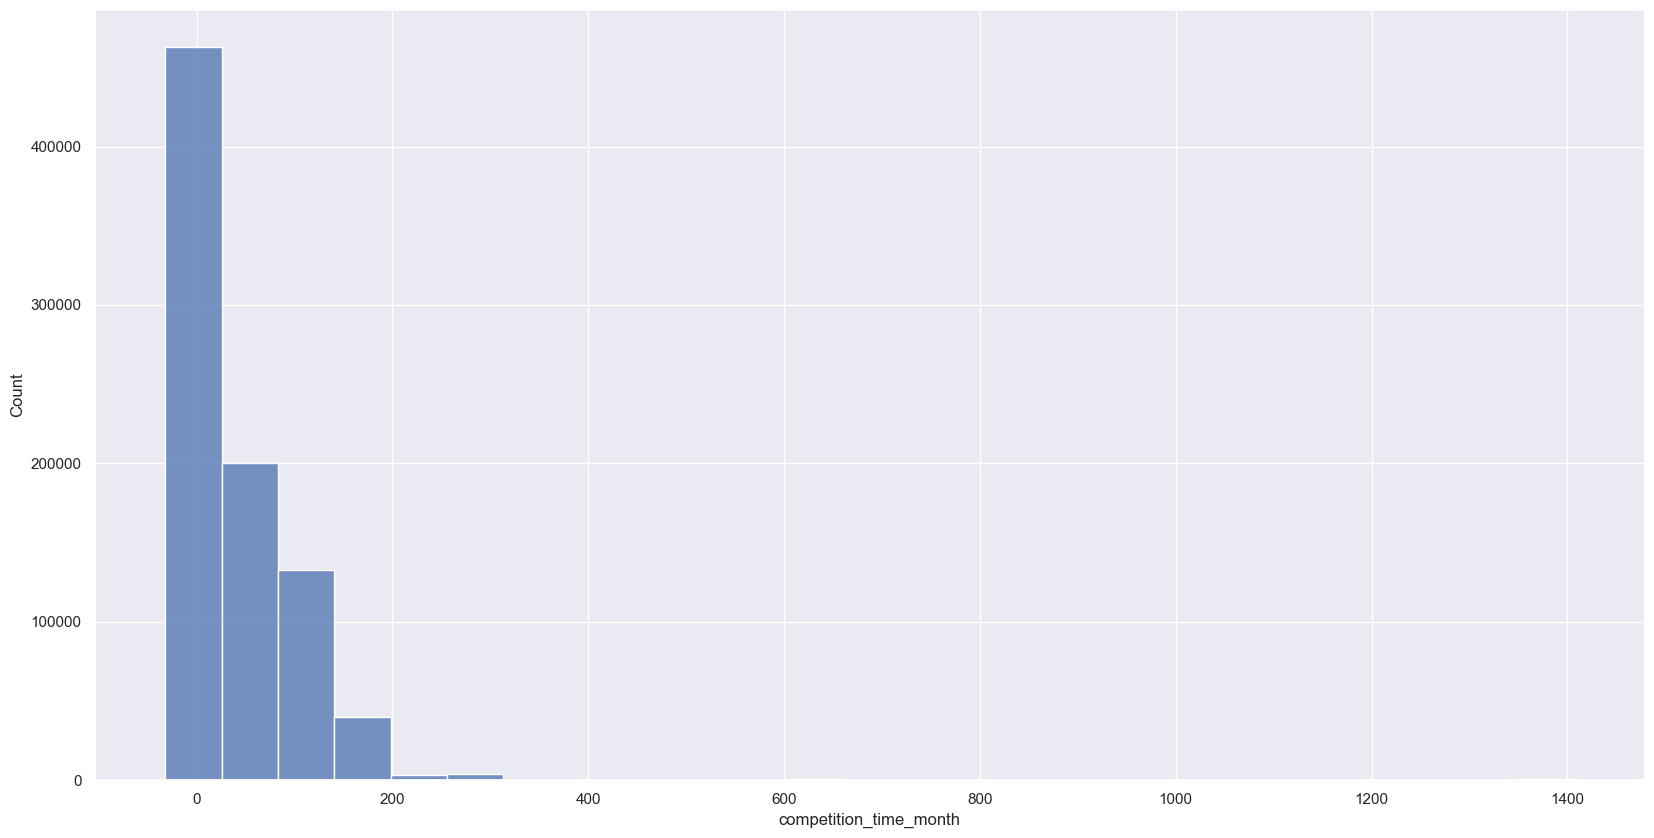

In [62]:
## Comportamento da variável tempo de loja com competidor 

sns.histplot (df4['competition_time_month'], bins = 25)

In [63]:
df4['competition_time_month'].sort_values().unique()

array([ -32,  -31,  -30,  -29,  -28,  -27,  -26,  -25,  -24,  -23,  -22,
        -21,  -20,  -19,  -18,  -17,  -16,  -15,  -14,  -13,  -12,  -11,
        -10,   -9,   -8,   -7,   -6,   -5,   -4,   -3,   -2,   -1,    0,
          1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   31,   32,   33,
         34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97,   98,   99,
        100,  101,  102,  103,  104,  105,  106,  107,  108,  109,  110,
        111,  112,  113,  114,  115,  116,  117,  1

#### 4.2.3.2. Desenvolvimento 

In [64]:
### Média de vendas por tempo de competidor próximo da loja existente

aux6 = df4[['sales','competition_time_month']].groupby('competition_time_month').mean().reset_index()
df4[['sales','competition_time_month']].groupby('competition_time_month').mean()

sales
competition_time_month        
-32                    6606.67
-31                    6759.61
-30                    6912.34
-29                    7136.69
-28                    7011.01
...                        ...
 1403                  6655.39
 1404                  6752.22
 1405                  6180.52
 1406                  6328.20
 1407                  7776.40

[376 rows x 1 columns]

<AxesSubplot:xlabel='competition_time_month', ylabel='sales'>

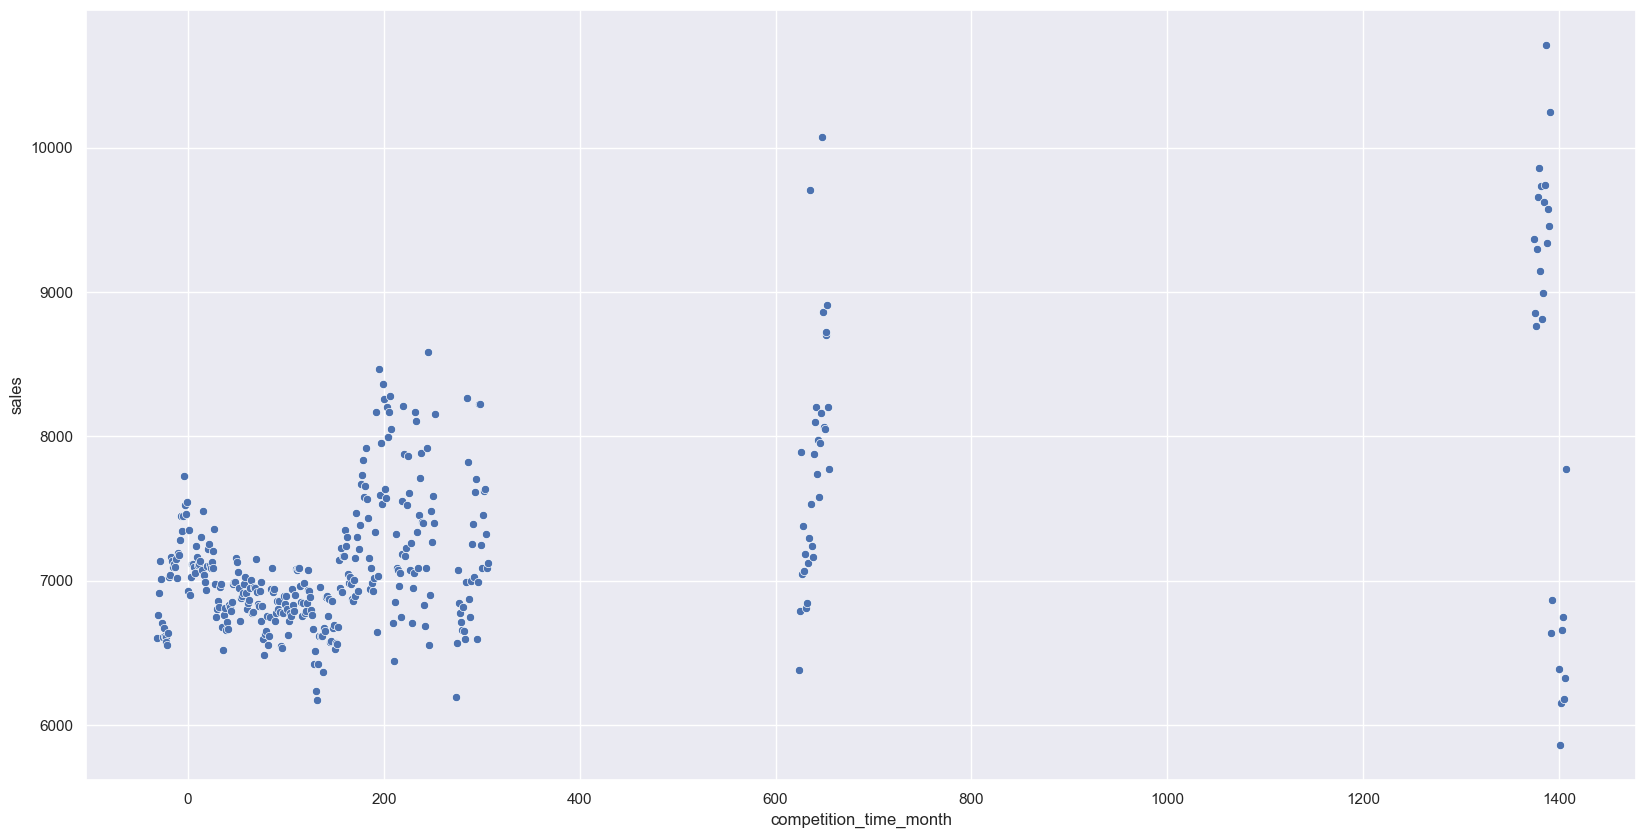

In [65]:
## scatter plot 

sns.scatterplot(x = 'competition_time_month', y = 'sales', data = aux6 )

<AxesSubplot:>

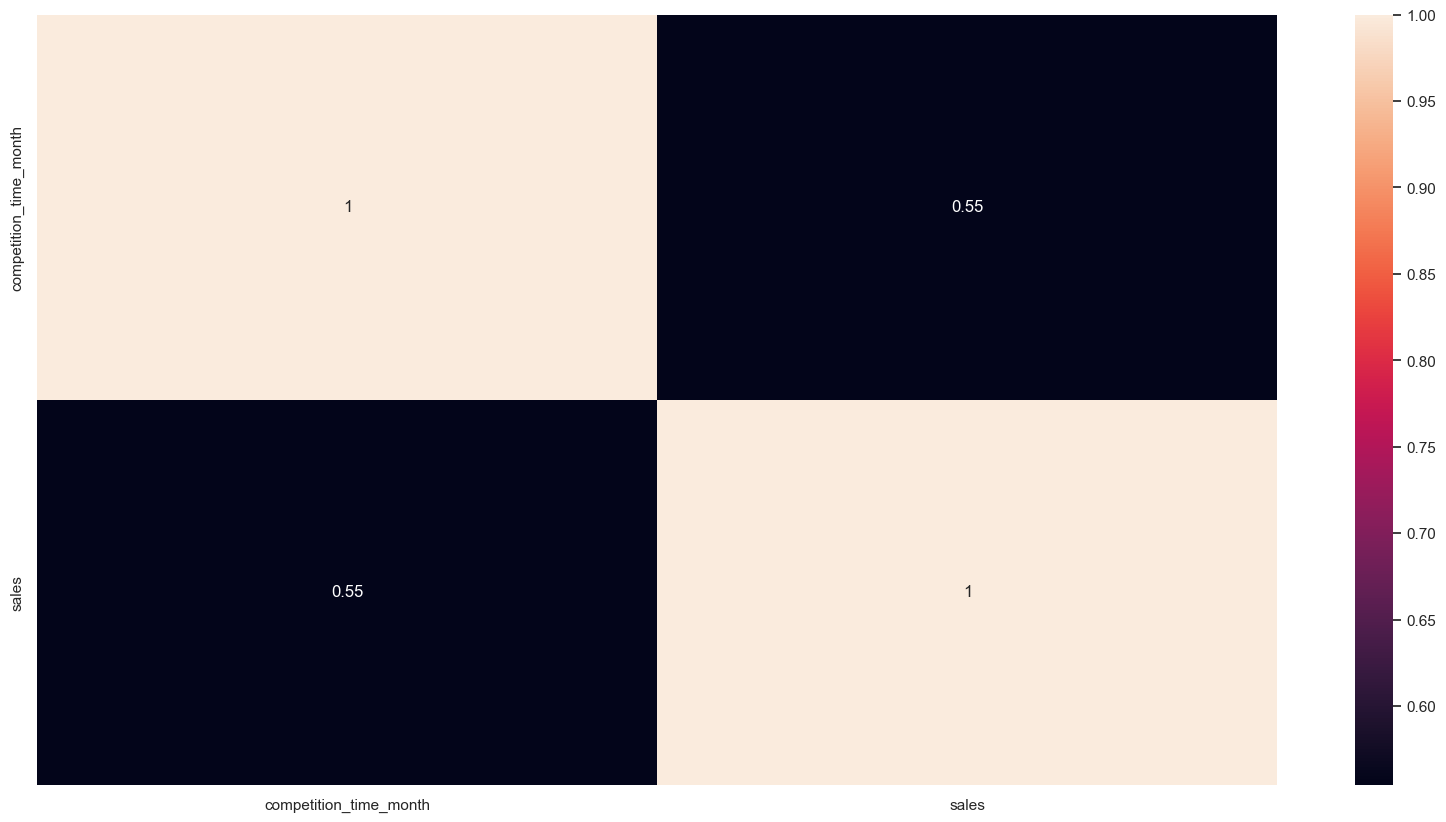

In [66]:
## correlação

sns.heatmap( aux6.corr(method = 'pearson') , annot = True)

In [68]:
bins = list( np.arange(-33, 1408, 30) )

aux6['competition_time_month_grouped'] = pd.cut( aux6['competition_time_month'], bins = bins)

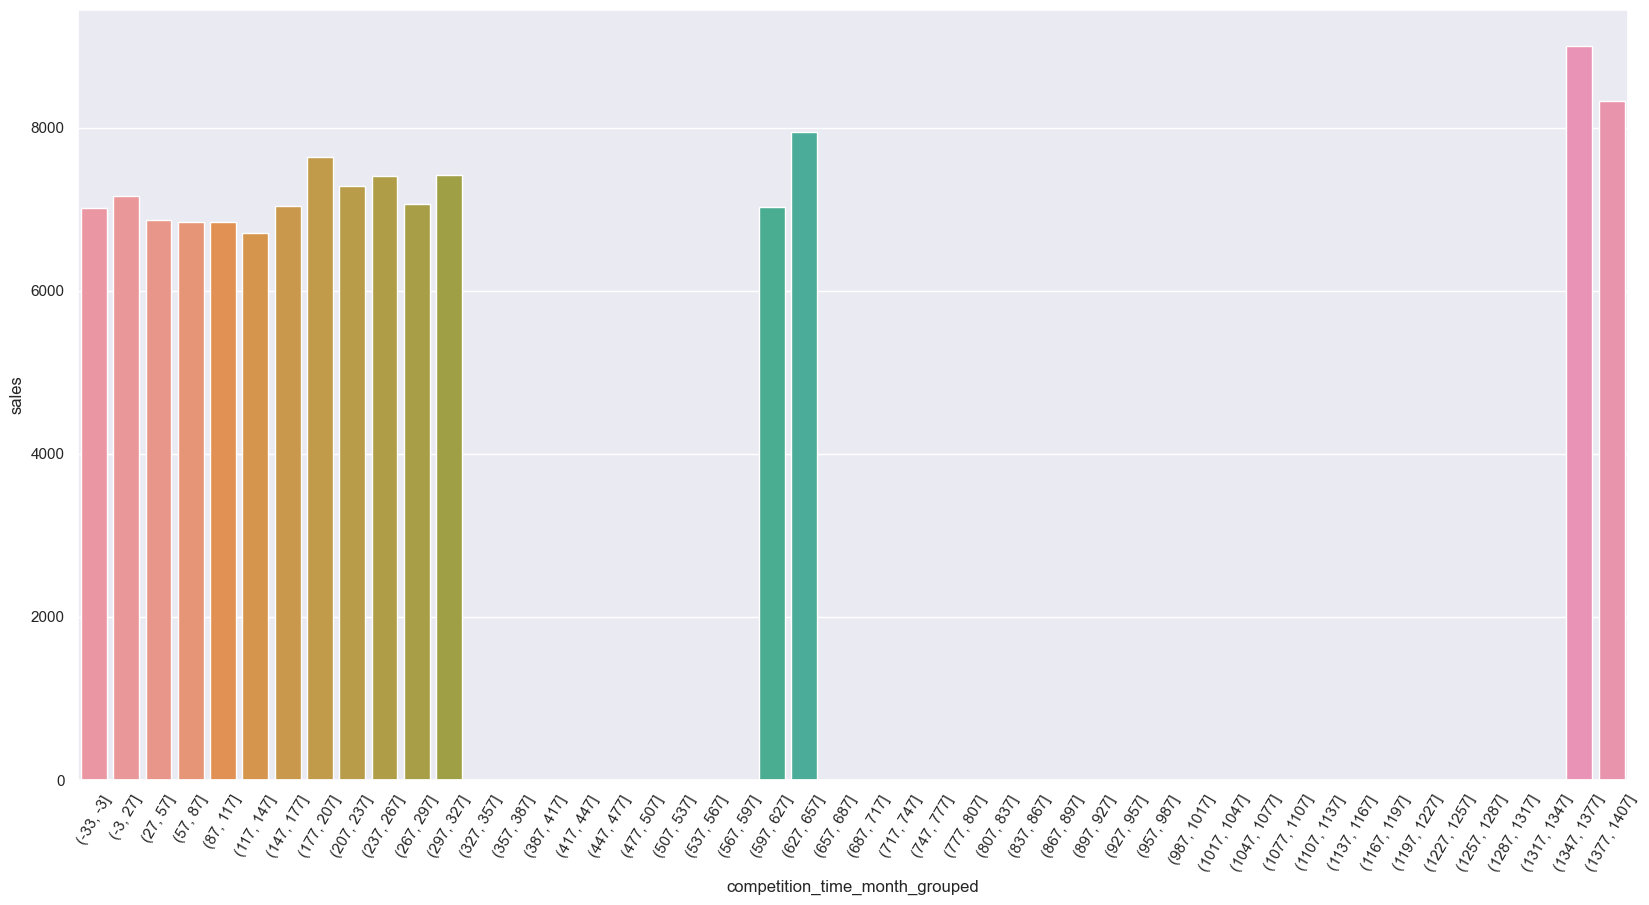

In [72]:
aux7 = aux6[['sales','competition_time_month_grouped']].groupby("competition_time_month_grouped").mean().reset_index()


sns.barplot(x = 'competition_time_month_grouped' , y = 'sales' , data= aux7);
plt.xticks(rotation = 60);

#### 4.2.3.3. Dashboard

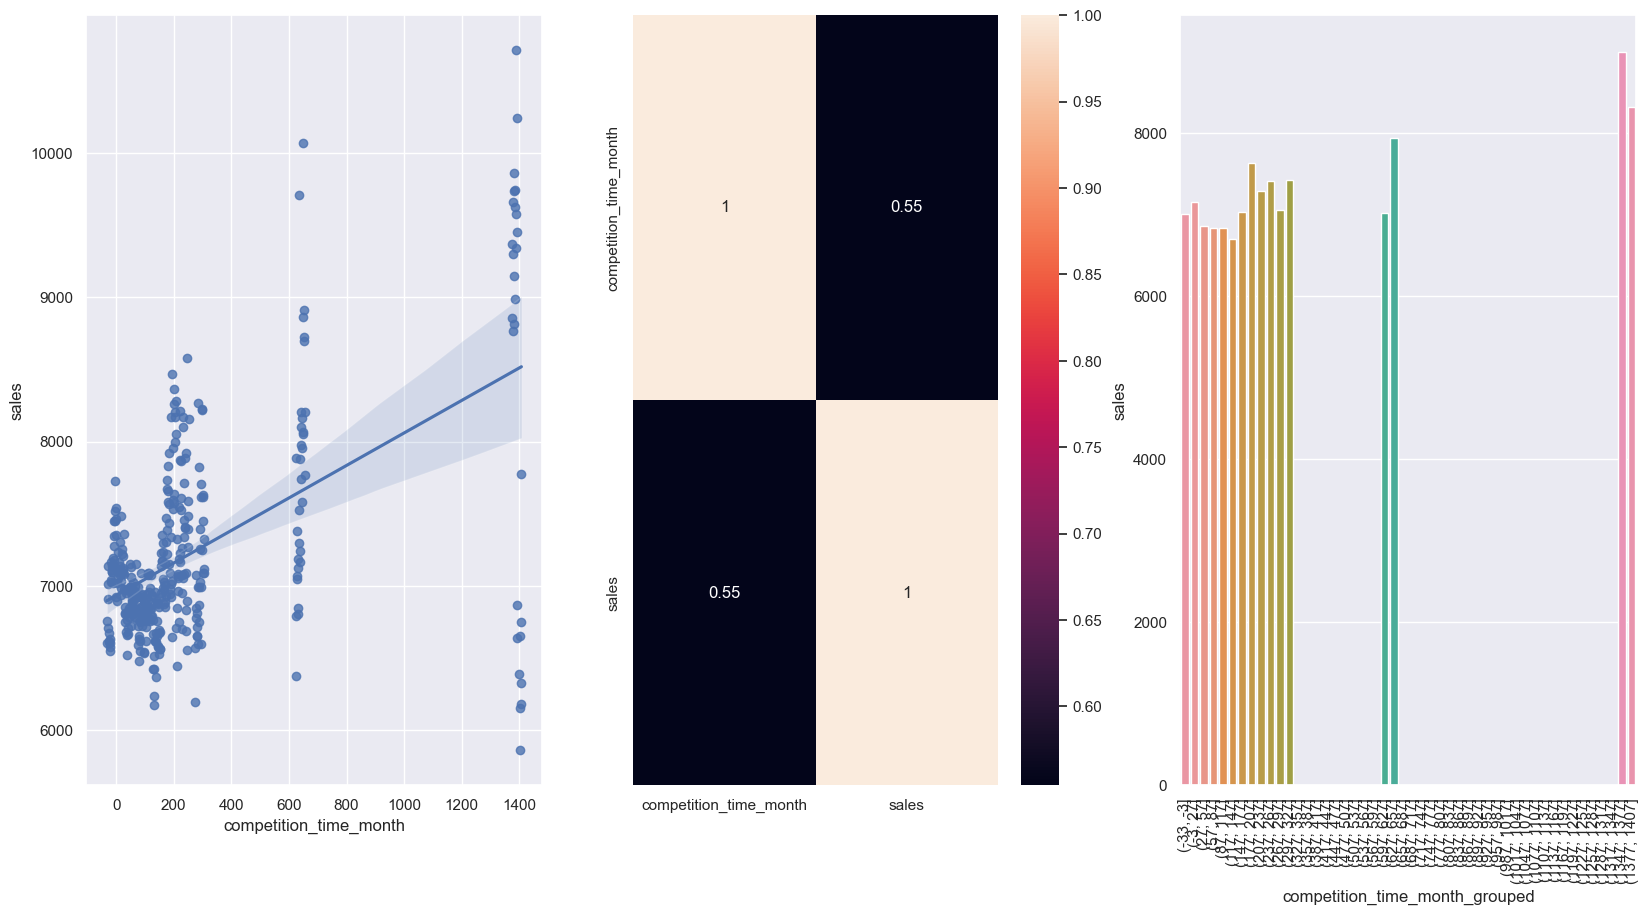

In [75]:
# 1 

aux6 = df4[['sales','competition_time_month']].groupby('competition_time_month').mean().reset_index()

plt.subplot(1,3,1)
# É um gráfico de tendência do scatter plot
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux6 )

# 2 

plt.subplot(1,3,2)
sns.heatmap( aux6.corr(method = 'pearson') , annot = True)

# 3

bins = list( np.arange(-33, 1408, 30) )

aux6['competition_time_month_grouped'] = pd.cut( aux6['competition_time_month'], bins = bins)

aux7 = aux6[['sales','competition_time_month_grouped']].groupby("competition_time_month_grouped").mean().reset_index()

plt.subplot(1,3,3)

sns.barplot(x = 'competition_time_month_grouped' , y = 'sales' , data= aux7);
plt.xticks(rotation = 90);

### 4.2.4. H4. Lojas com promoções 2 ativas por mais tempo deveriam vender mais. VERDADEIRO

Correlação é baixa(0,24)

**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Não Pode

#### 4.2.4.1. Dashboard

<AxesSubplot:>

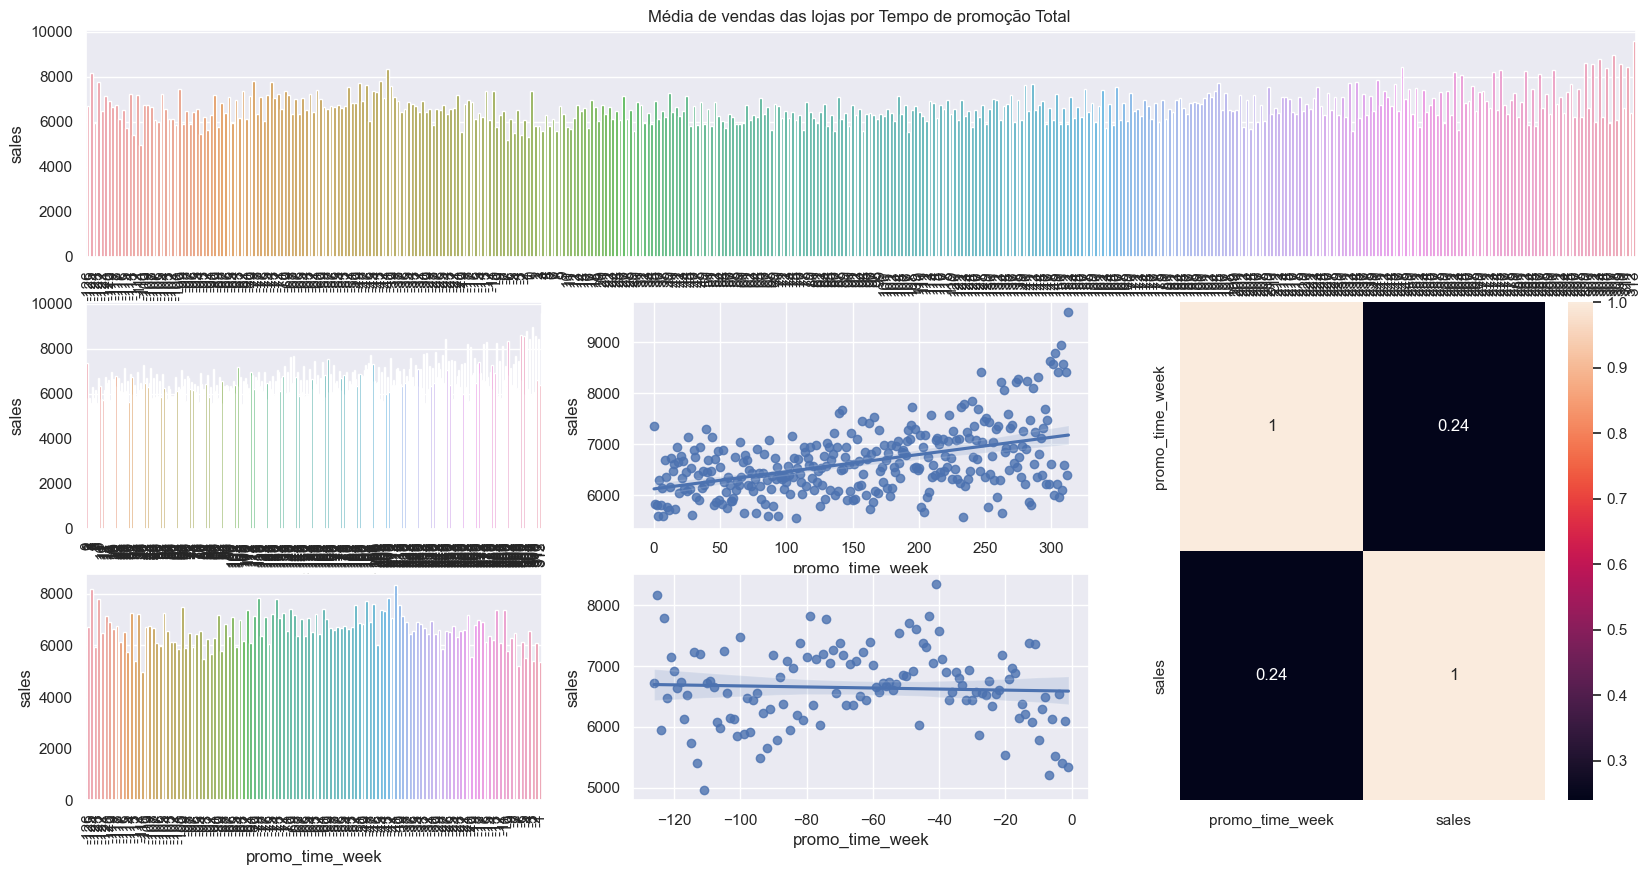

In [42]:
## Média de vendas das lojas por tempo de promoção extendida das lojas
aux1 = df4[['sales','promo_time_week']].groupby('promo_time_week').mean().reset_index()


grid = GridSpec( 3, 3)

plt.subplot( grid[0,:] ) # primeira linha e todas as colunas
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux1).set_title("Média de vendas das lojas por Tempo de promoção Total ");
plt.xticks(rotation = 90);

## Como ficou difícil tirar conclusões devido a aleatoriedade do comportamento e a quantidade elevada de tempos de promoção extendida por loja
## então cortamos a base de dados para olhar tempos de promoção distintos

aux2 = aux1[aux1['promo_time_week'] >= 0] # Data de venda está depois do início da promoção estendida
plt.subplot( grid[1,0] )
sns.barplot(x = 'promo_time_week', y = 'sales' , data = aux2 )
plt.xticks(rotation = 90);

plt.subplot( grid[1,1] )
sns.regplot(x = 'promo_time_week', y = 'sales' , data = aux2 ) # Gráfico de dispersão com linha de tendência

aux3 = aux1[aux1['promo_time_week'] < 0] # Data de venda é antes do início da promoção estendida

plt.subplot( grid[2,0] )
sns.barplot(x = 'promo_time_week', y = 'sales' , data = aux3 )
plt.xticks(rotation = 90);

plt.subplot( grid[2,1] )
sns.regplot(x = 'promo_time_week', y = 'sales' , data = aux3 ) # Gráfico de dispersão com linha de tendência

# Correlação de tempo de programação extendida com as vendas
plt.subplot( grid[1:,2] )
sns.heatmap( aux1.corr( method = 'pearson' ) , annot = True )





### 4.2.5. <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s> 

Próximo ciclo CRISP

### 4.2.6. H6. Lojas com mais promoções consecutivas deveriam vender mais. VERDADEIRO

**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

In [45]:
# Média de vendas quando as lojas estão em promoção  

df4[["sales","promo","promo2"]].groupby(["promo","promo2"]).mean()

sales
promo promo2        
0     0      6327.97
      1      5528.97
1     0      8618.13
      1      7836.09

In [ ]:
#Análise

## Promo impacta mais na venda média das lojas do que a promo2 

<AxesSubplot:xlabel='year_week'>

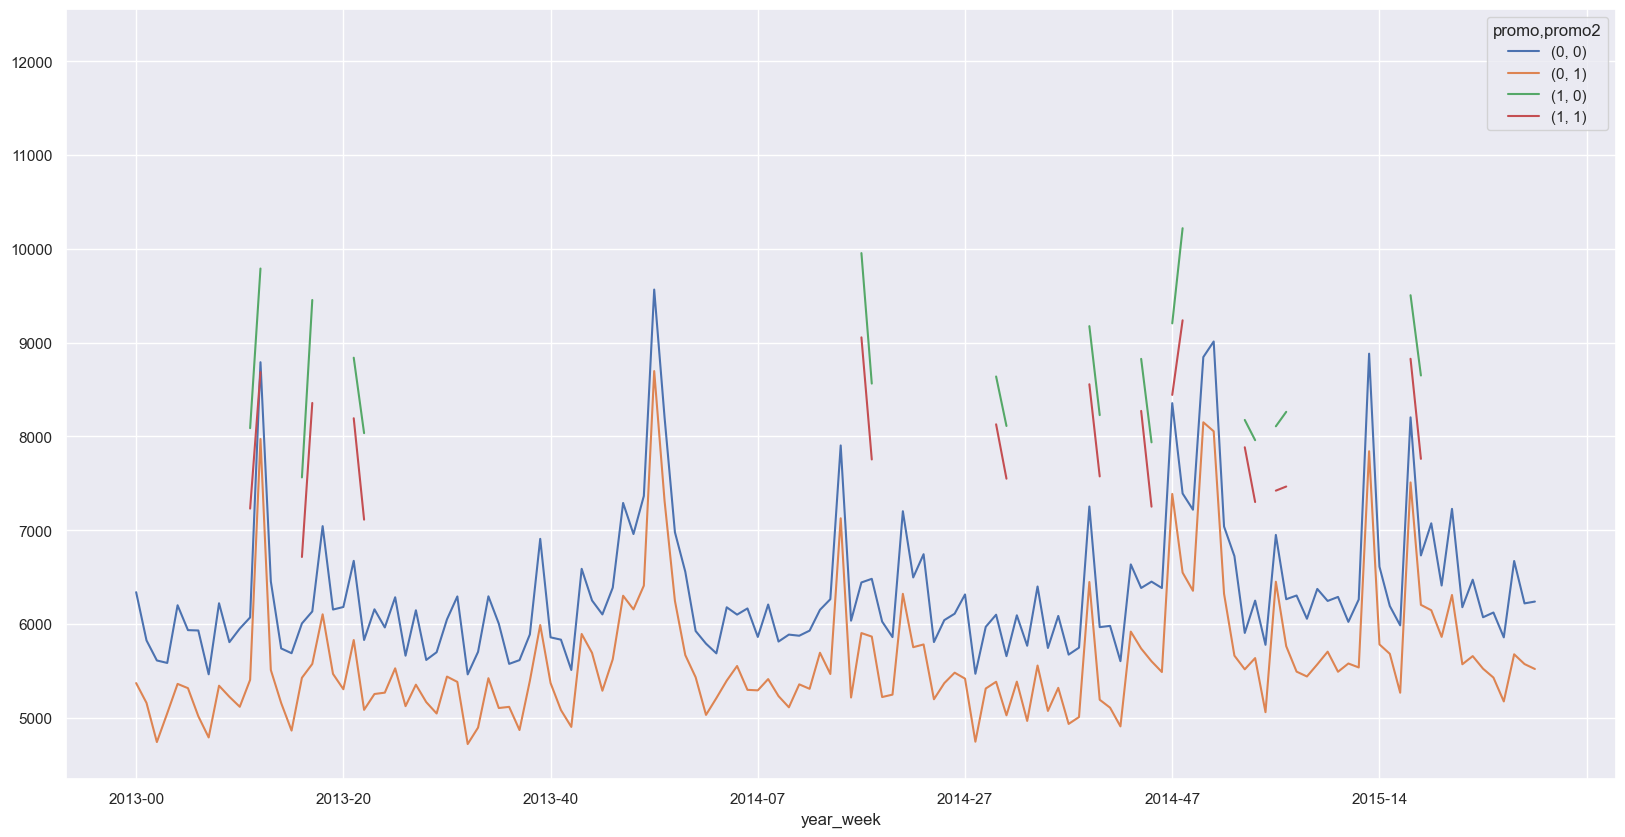

In [48]:
# Média de vendas das lojas com fenômeno de promoção tradicional(promo) e promoção extendida (promo2)

aux1 = df4[["year_week","sales","promo","promo2"]].groupby(["year_week","promo","promo2"]).mean().reset_index() 

aux1.pivot_table(index = "year_week", columns = ["promo","promo2"], values = 'sales').plot()

### 4.2.7. H7. Lojas abertas durante o feriado de Natal deveriam vender mais, em média. FALSO

Lojas abertas durante o feriado de Páscoa vendem mais, em média,(pouco a frente do Natal) considerando até mesmo dias regulares sem feriado.

Contudo, no ano de 2014, a média de vendas de Natal superou a Páscoa e ficou em 1ª.

**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

In [51]:
## Quantidade de lojas que abriram em datas feriados ou dias normais repetidas vezes ao longo do tempo

df4[["state_holiday","store"]].groupby("state_holiday").count()

store
state_holiday         
christmas           71
easter_holiday     145
public_holiday     694
regular_day     843482

In [53]:
# Média de vendas de lojas em dias regulares e feriados

aux = df4[["state_holiday","sales"]].groupby("state_holiday").mean().reset_index()
df4[["state_holiday","sales"]].groupby("state_holiday").mean()

sales
state_holiday         
christmas      9743.75
easter_holiday 9887.89
public_holiday 8487.47
regular_day    6953.52

<AxesSubplot:xlabel='year', ylabel='sales'>

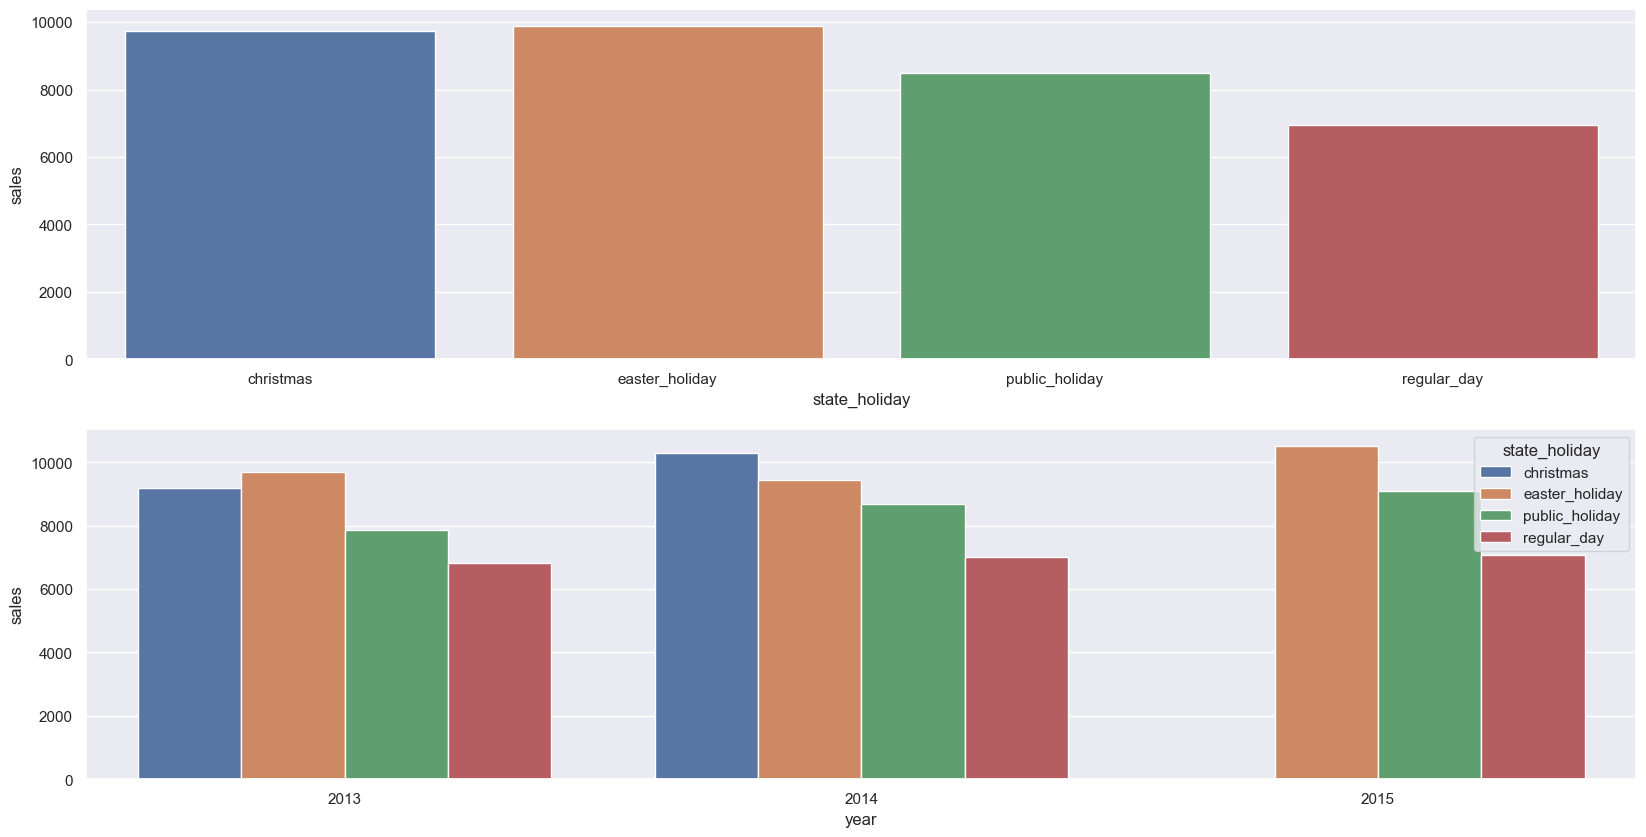

In [55]:
plt.subplot( 2,1,1 )
sns.barplot(x = "state_holiday", y= "sales", data= aux)

aux1 = df4[["state_holiday","sales","year"]].groupby(["year","state_holiday"]).mean().reset_index()

plt.subplot( 2,1,2 )
sns.barplot(x = "year", y= "sales", hue = "state_holiday", data= aux1)

### 4.2.8. H8. Lojas deveriam vender mais, em média, ao longo dos anos. VERDADEIRO

Mesmo com histórico até metade de 2015, as vendas médias das lojas em 2015 > 2014 > 2013. 

Alta Correlação - sales | year

**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

<AxesSubplot:xlabel='year'>

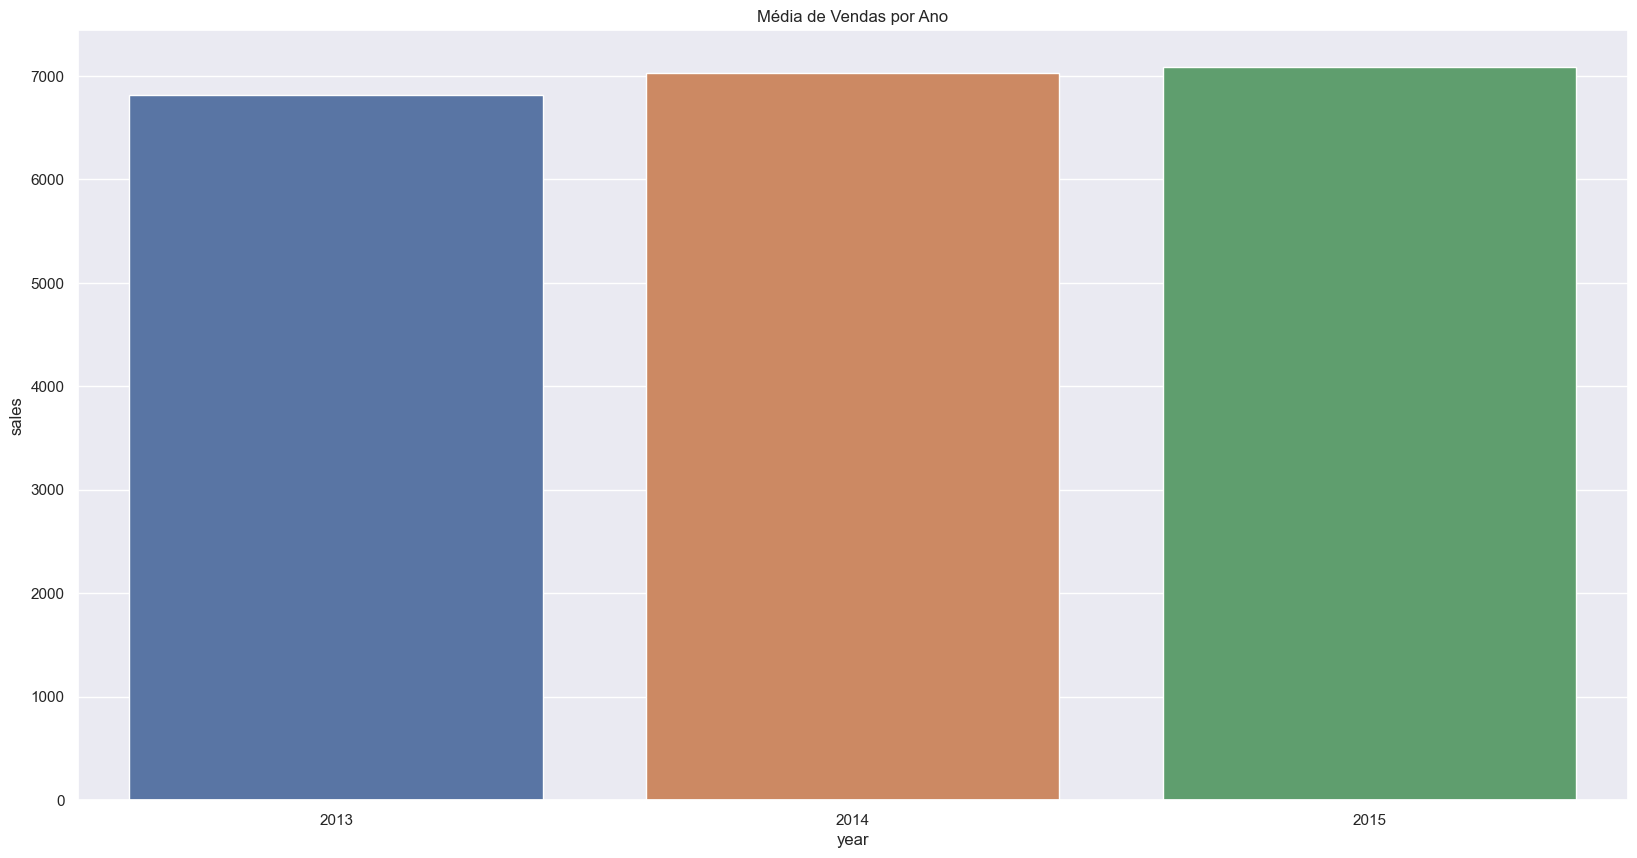

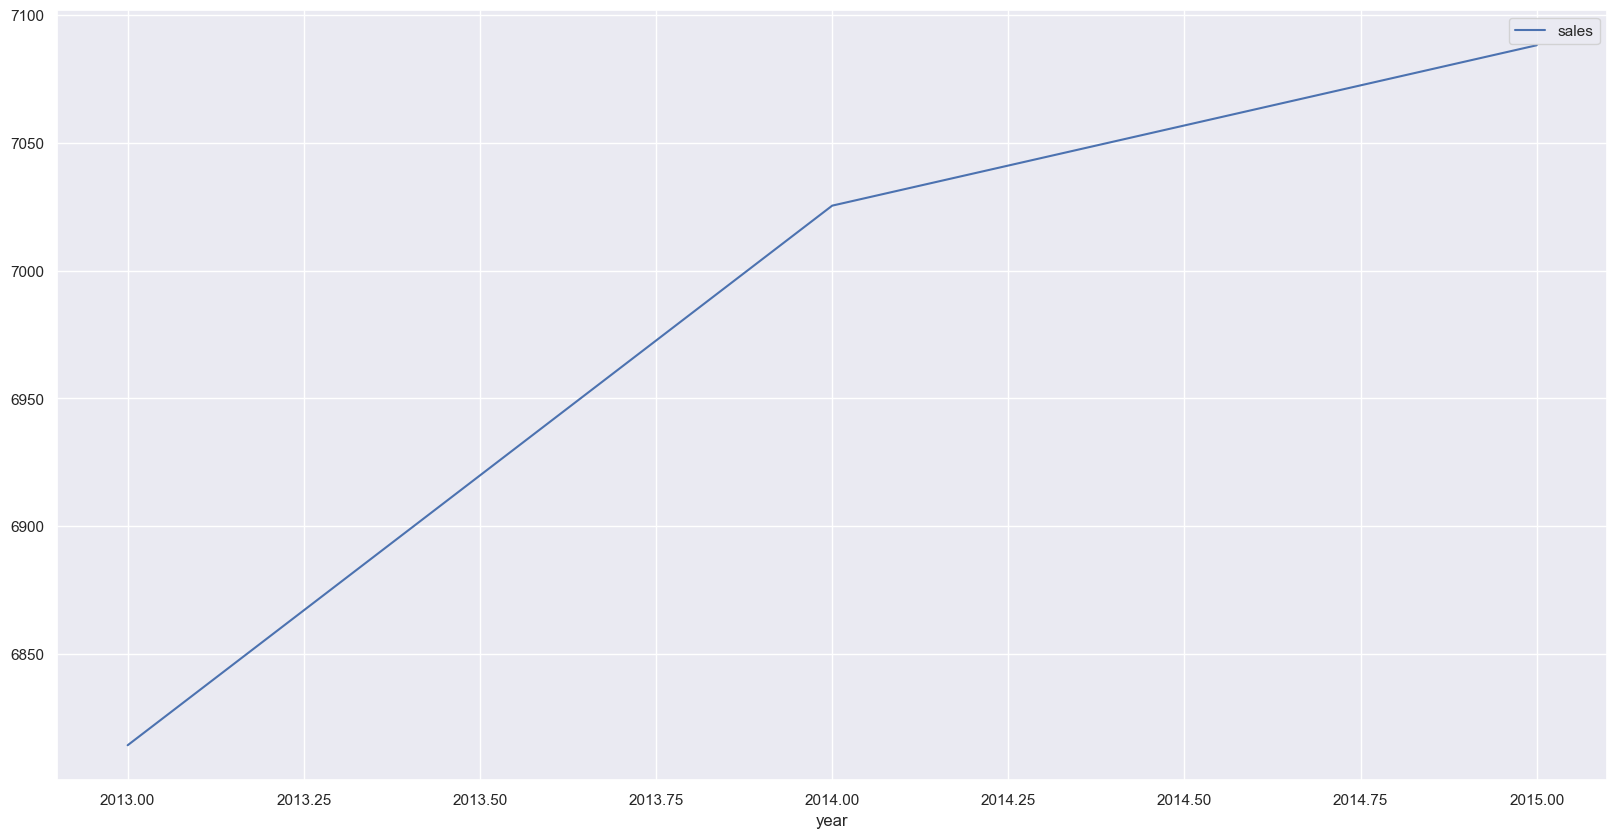

In [68]:
aux = df4[["sales","year"]].groupby("year").mean().reset_index()


sns.barplot(x = "year", y = "sales", data = aux).set_title("Média de Vendas por Ano")

aux1.plot()

<AxesSubplot:>

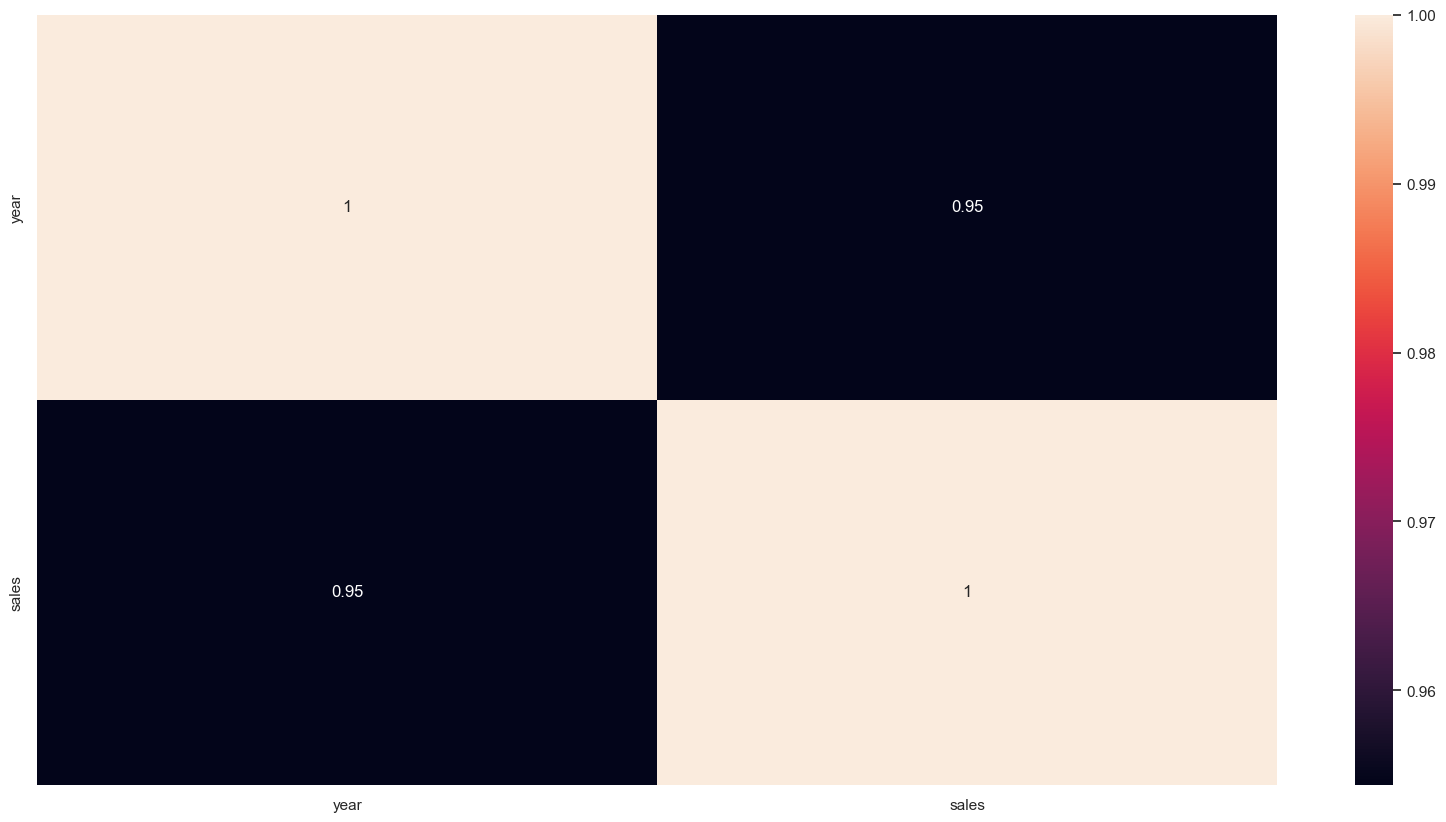

In [69]:
## Correlação 

sns.heatmap(aux.corr(method = 'pearson'), annot = True)

### 4.2.9. H9. Lojas deveriam vender mais, em média, no segundo semestre do ano. VERDADEIRO

Média de vendas maiores nos meses de dezembro >> novembro.

Correlação 0,48 -> month | sales

**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Pode

In [31]:
## Quantidade de registros de vendas em lojas por mês

df4[["month","store"]].groupby("month").count()

store
month       
1      86343
2      80243
3      85980
4      81731
5      80103
6      82576
7      85587
8      54413
9      52330
10     53292
11     51401
12     50393

<AxesSubplot:>

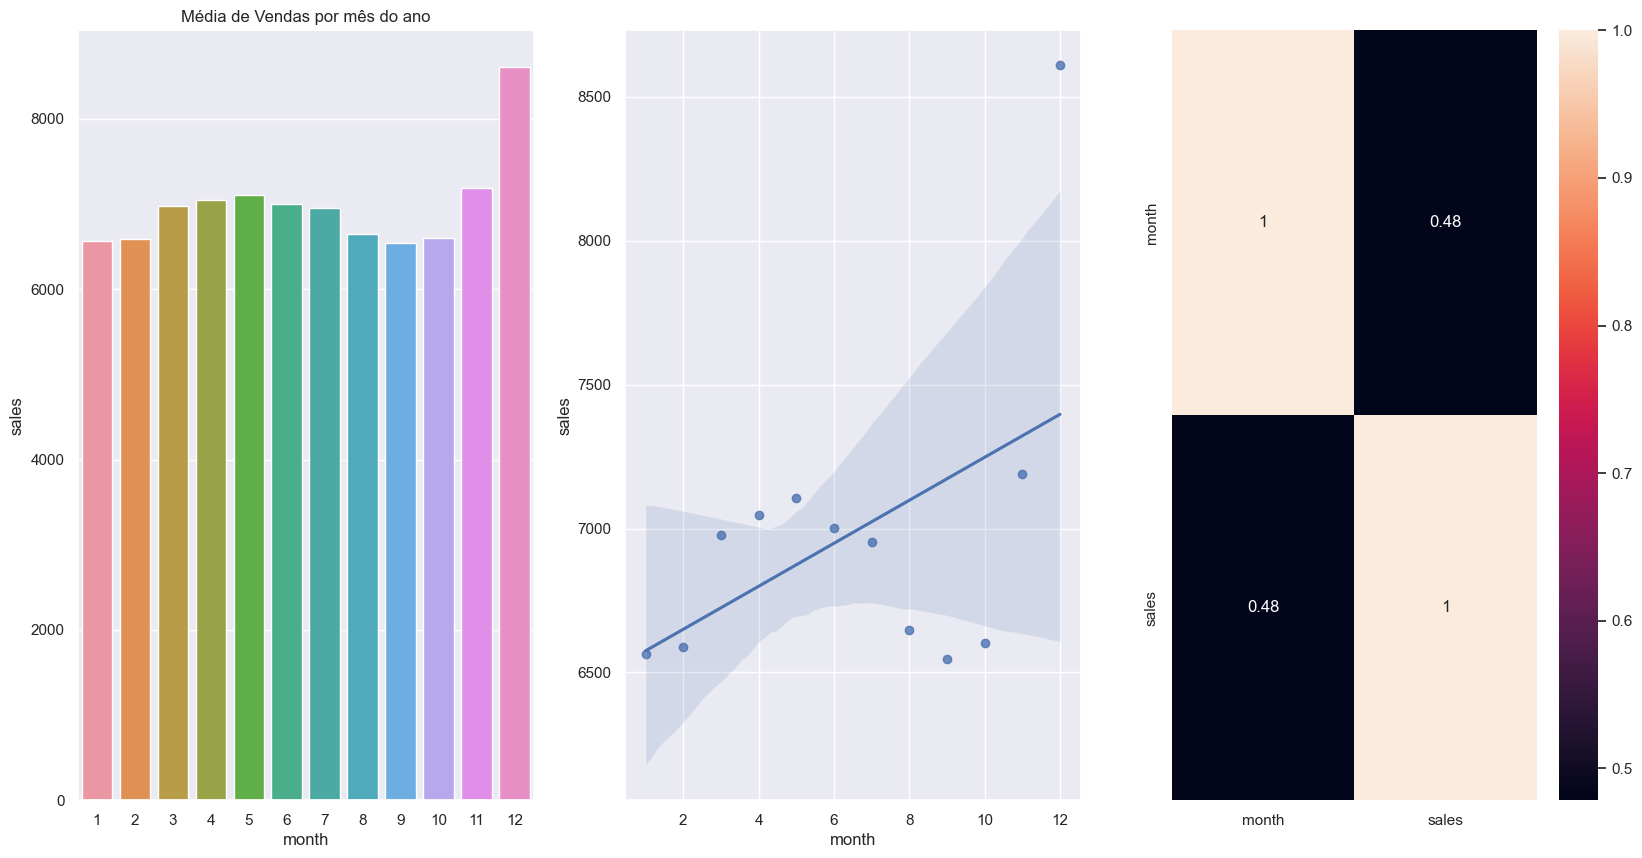

In [28]:
aux = df4[["month","sales"]].groupby("month").mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x ="month", y = "sales", data = aux).set_title("Média de Vendas por mês do ano")

plt.subplot(1,3,2)
sns.regplot(x ="month", y = "sales", data = aux)

plt.subplot(1,3,3)
sns.heatmap( aux.corr(method = 'pearson') , annot = True )

<AxesSubplot:xlabel='month'>

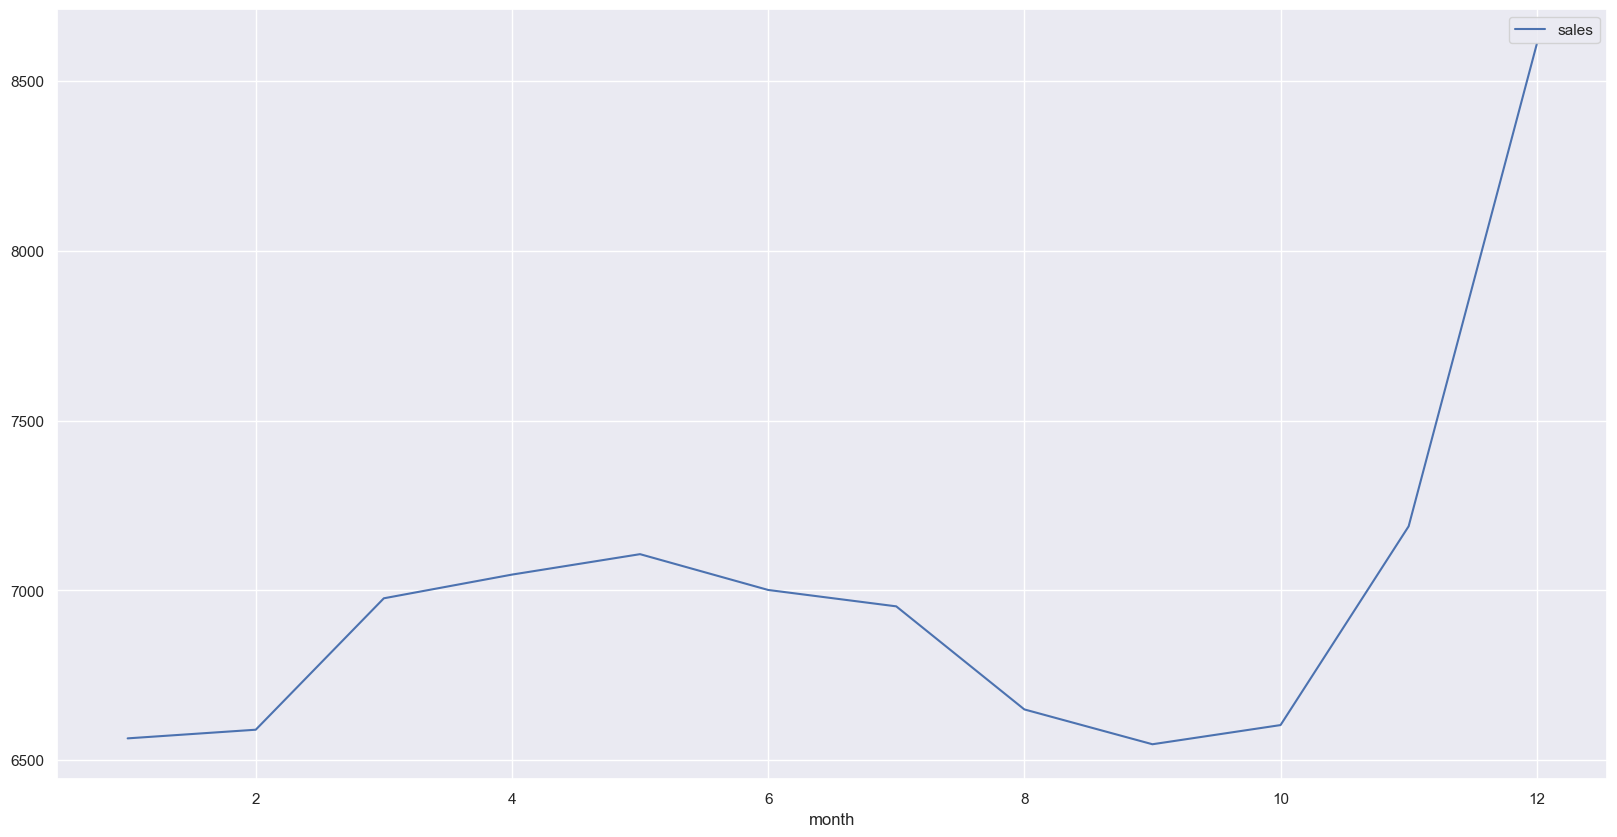

In [30]:
df4[["month","sales"]].groupby("month").mean().plot()

### 4.2.10. H10. Lojas deveriam vender mais depois do dia 10 de cada mês.

Média de Vendas diminuem a medida que o dia do mês aumenta. Correlação -0,24 -> sales | day

**FALSO:** Lojas vendem menos, em média, depois do dia 10 de cada mês.

**Conclusão:**

Gera Insight ? Gera surpresa e desfaz crença.


Pode ser relevante para o modelo? Não

In [40]:
## Quantidade de registros de vendas em lojas por dia do mês 

df4[["day","date"]].groupby("day").count()

date
day       
1    19368
2    29235
3    25058
4    29474
5    28176
6    27566
7    28359
8    27961
9    27068
10   28159
11   30121
12   28167
13   29262
14   27273
15   27821
16   29203
17   28154
18   29060
19   27420
20   28116
21   27284
22   27988
23   29241
24   28163
25   27065
26   26168
27   29270
28   28367
29   23575
30   26326
31   15924

Text(0.5, 1.0, 'Média de Vendas antes do dia 10 e depois')

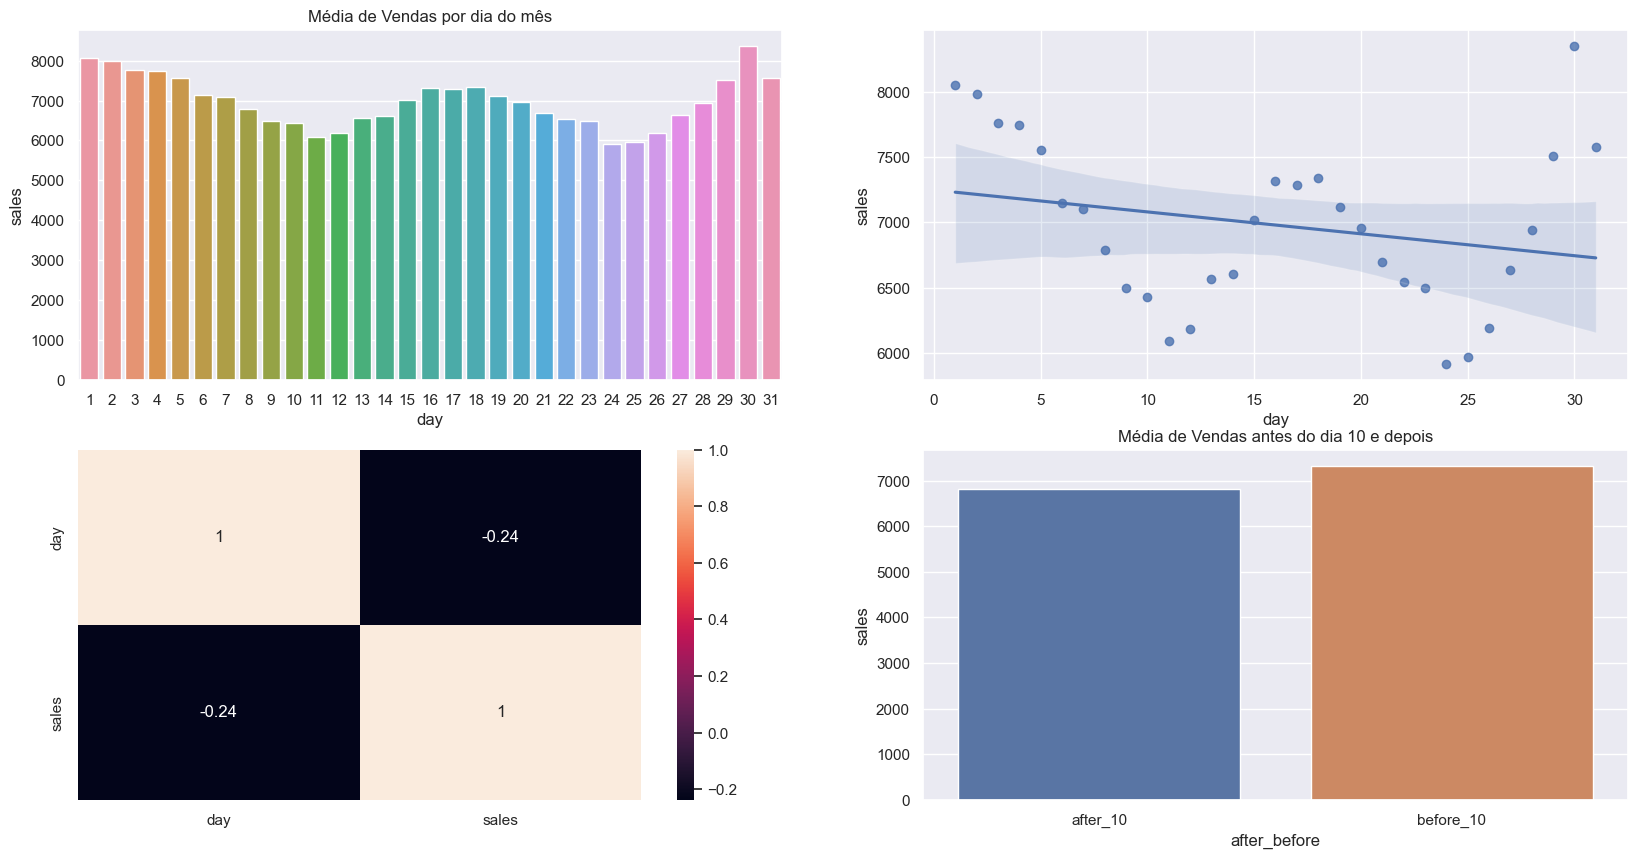

In [43]:
aux1 = df4[["day","sales"]].groupby("day").mean().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = "day", y = "sales", data = aux1).set_title("Média de Vendas por dia do mês")

plt.subplot(2,2,2)
sns.regplot(x = "day", y = "sales", data = aux1)

plt.subplot(2,2,3)
sns.heatmap( aux1.corr(method = 'pearson'), annot = True )

## Dividir os dias do mês antes de 10 e depois de 10 para analisar a média de vendas
aux1["after_before"] = aux1["day"].apply(lambda x: "before_10" if x <= 10 else "after_10")

aux2 = aux1[["after_before","sales"]].groupby("after_before").mean().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = "after_before", y = "sales", data = aux2).set_title("Média de Vendas antes do dia 10 e depois")

### 4.2.11. H11. Lojas deveriam vender menos aos finais de semana. VERDADEIRO

Baixa correlação -> -0,19 sales | day_of_week

**Conclusão:**

Gera Insight ? Gera surpresa e desfaz crença.


Pode ser relevante para o modelo? Não

In [45]:
# Quantidade de registros de vendas por dia da semana

df4[["day_of_week","store"]].groupby("day_of_week").count()

store
day_of_week        
1            137560
2            143961
3            141936
4            134644
5            138640
6            144058
7              3593

Dia 7 que hipoteticamente aparenta ser domingo, tenho menos registros pela maioria das lojas estarem fechadas. Então devo analisar pela média
de vendas.

Text(0.5, 1.0, 'Média de Vendas durante a semana')

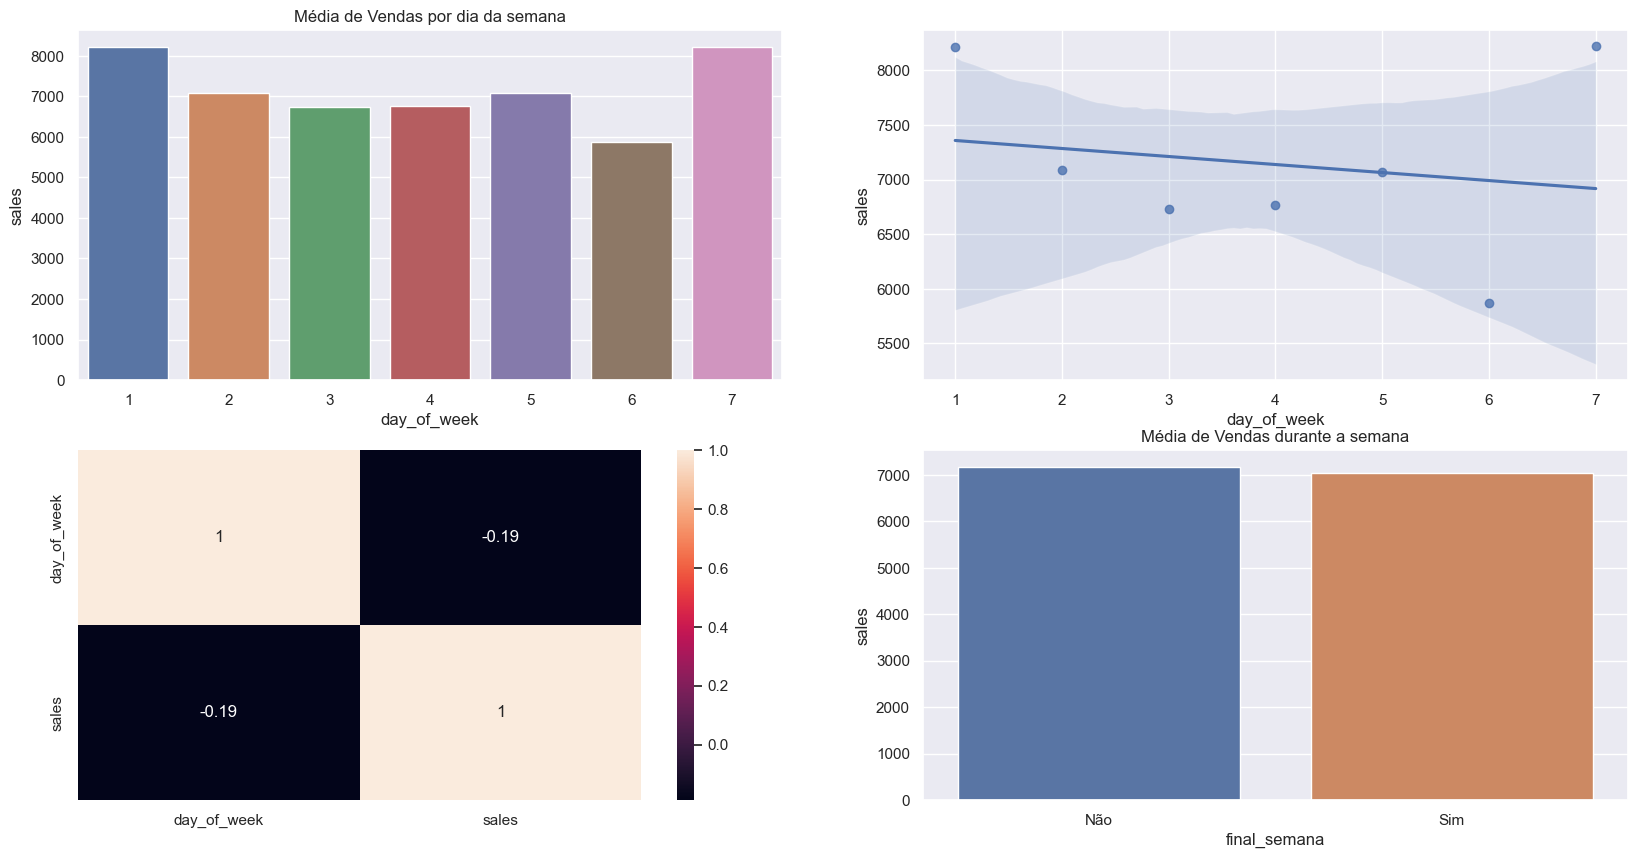

In [47]:
aux = df4[["day_of_week","sales"]].groupby("day_of_week").mean().reset_index()

plt.subplot(2,2,1)
sns.barplot(x="day_of_week",y= "sales",data = aux ).set_title("Média de Vendas por dia da semana")

plt.subplot(2,2,2)
sns.regplot(x="day_of_week",y= "sales",data = aux )

plt.subplot(2,2,3)
sns.heatmap(aux.corr(method = 'pearson'), annot = True)

aux["final_semana"] = aux["day_of_week"].apply(lambda x: "Sim" if x >= 6 else "Não")

aux1 = aux[["final_semana","sales"]].groupby("final_semana").mean().reset_index()

plt.subplot(2,2,4)
sns.barplot(x="final_semana",y= "sales",data = aux1 ).set_title("Média de Vendas durante a semana")


### 4.2.12. H12. Lojas deveriam vender menos, em média, durante os feriados escolares.

**FALSO:** Lojas vendem mais, em média, durante os feriados escolares.

- Apenas nos meses de dezembro e setembro a média de vendas em dias sem feriados escolares supera a com feriados escolares.

**Conclusão:**

Gera Insight ? Não gera tanta surpresa e não desfaz crença.


Pode ser relevante para o modelo? Não

In [49]:
## Quantidade de registros com Feriado escolar (1) afetando as vendas das lojas e sem (0) 

df4["school_holiday"].value_counts()

0    680935
1    163457
Name: school_holiday, dtype: int64

In [56]:
# Quantidade de registros de vendas por mês segmentado por feriados escolares e sem

df4[["school_holiday","store","month"]].groupby(["month" , "school_holiday"]).count()

store
month school_holiday       
1     0               75606
      1               10737
2     0               72858
      1                7385
3     0               78093
      1                7887
4     0               61863
      1               19868
5     0               73768
      1                6335
6     0               76844
      1                5732
7     0               47593
      1               37994
8     0               20400
      1               34013
9     0               48020
      1                4310
10    0               35908
      1               17384
11    0               51177
      1                 224
12    0               38805
      1               11588

**Conclusão:** Não podemos somar para comparar devido a quantidade de registros por atributo ser discrepante, com isso, a média trará realmente 
o impacto da variável/atributo/carac nas vendas

Text(0.5, 1.0, 'Média de Vendas por mês com e sem feriado escolar')

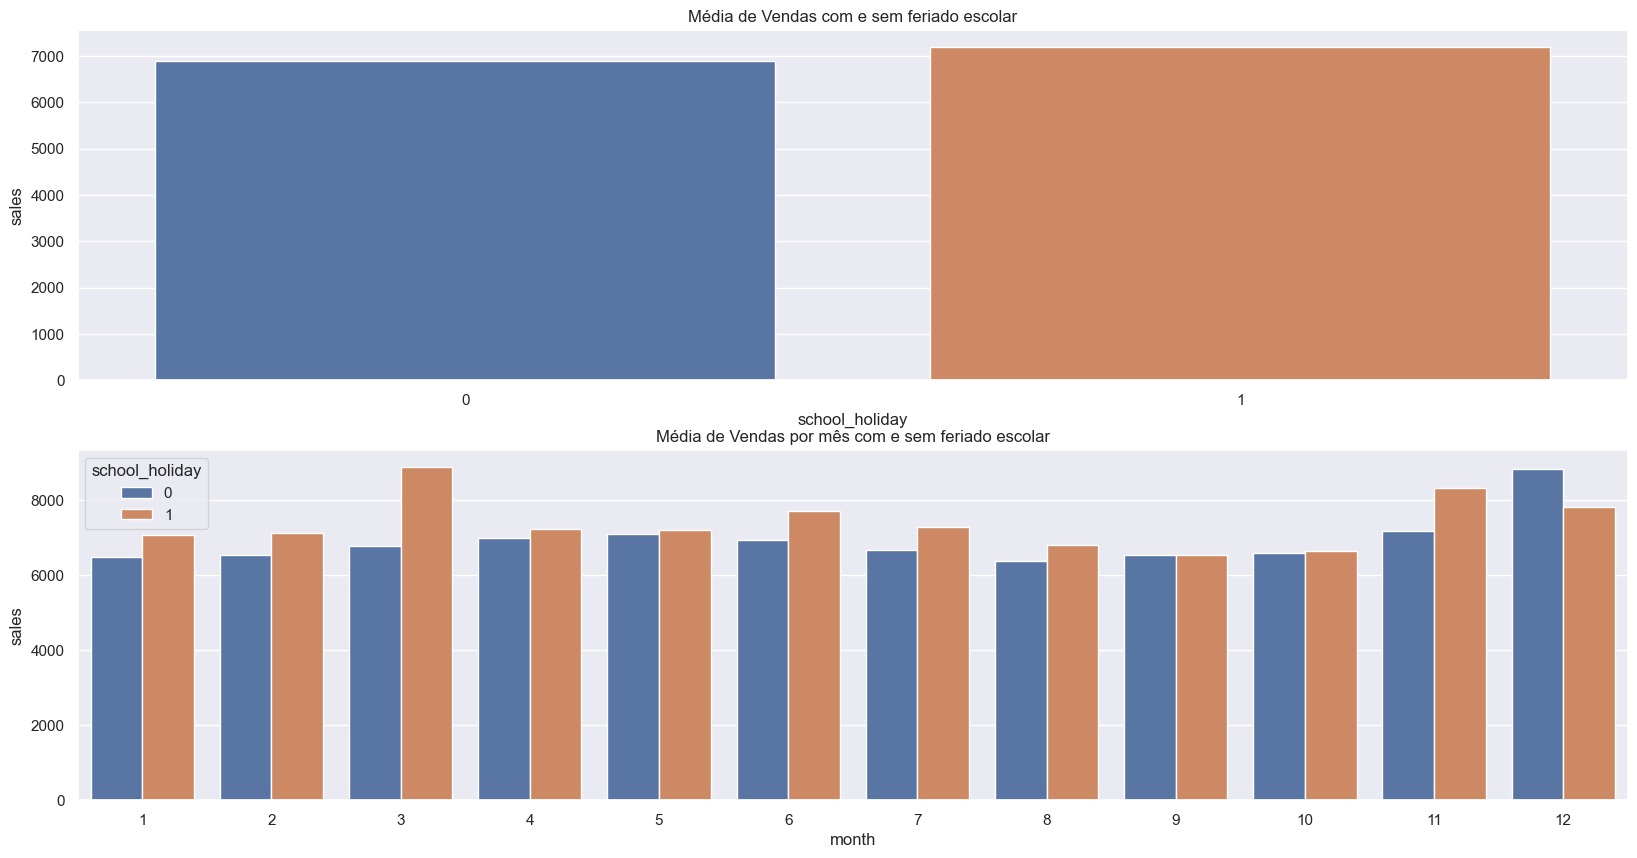

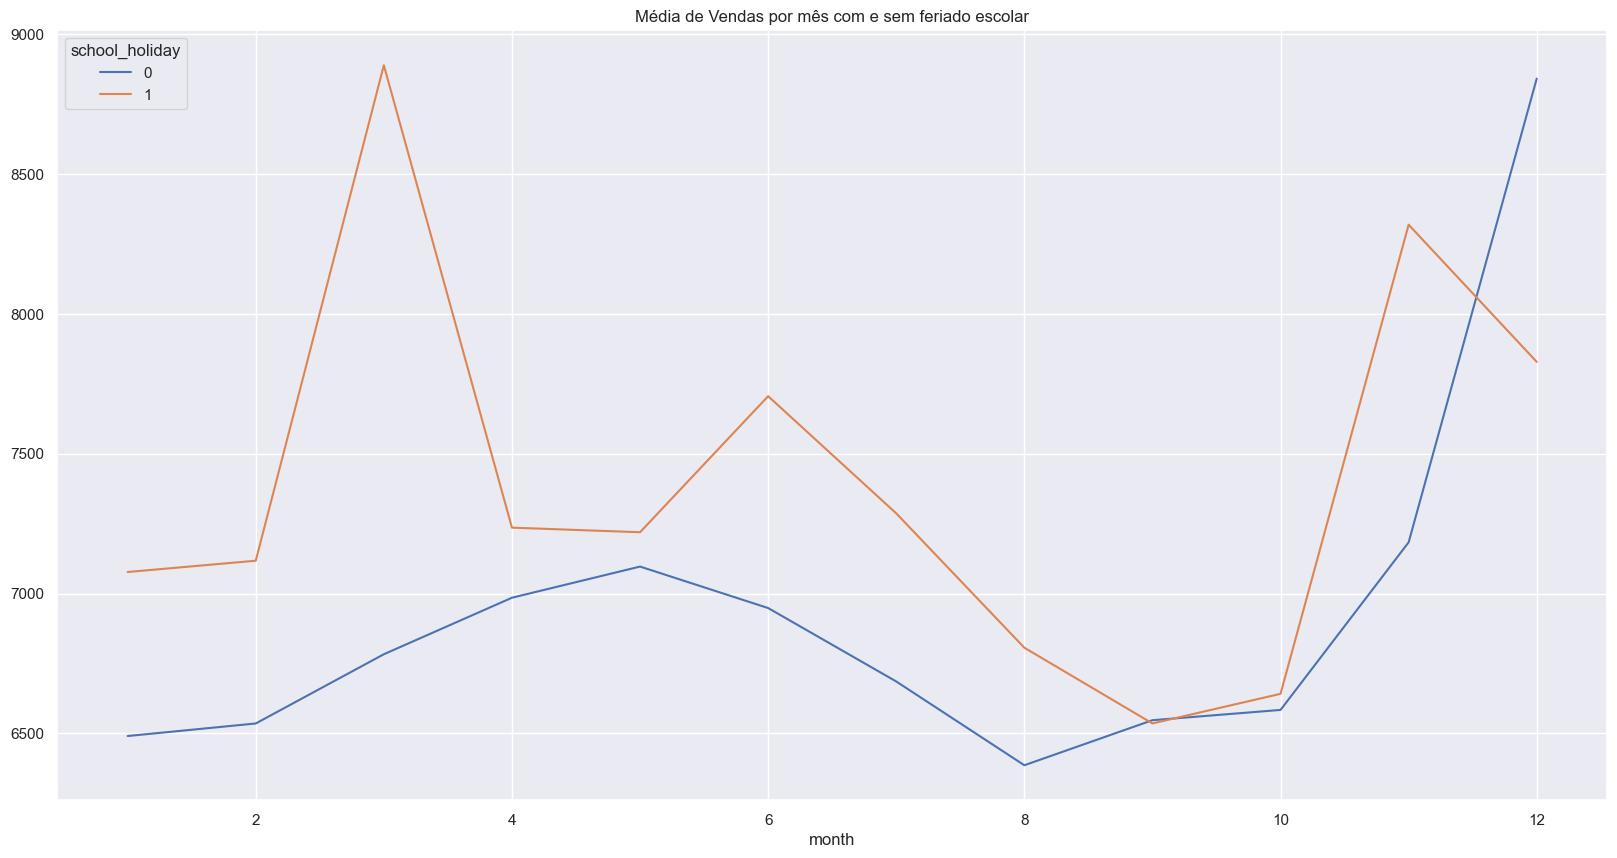

In [55]:
aux = df4[["sales","school_holiday"]].groupby("school_holiday").mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = "school_holiday" , y = "sales" , data = aux).set_title("Média de Vendas com e sem feriado escolar")

aux1 = df4[["sales","school_holiday","month"]].groupby(["month","school_holiday"]).mean().reset_index()

plt.subplot(2,1,2)
sns.barplot(x = "month" , y = "sales" , hue = "school_holiday", data = aux1).set_title("Média de Vendas por mês com e sem feriado escolar")

aux1.pivot_table( index = "month" , columns = "school_holiday"  , values = "sales" ).plot().set_title("Média de Vendas por mês com e sem feriado escolar")

### 4.2.13. Resumo

In [58]:
tab = [["Hipóteses","Conclusão","Relevância"],
       ["H1","Verdadeiro","Alta"],
       ["H2","Falso","Baixa"],
       ["H3","Verdadeiro","Alta"],
       ["H4","Verdadeiro","Baixa"],
       ["H5","---","---"],
       ["H6","Verdadeiro","Média"],
       ["H7","Falso","Média"],
       ["H8","Verdadeiro","Alta"],
       ["H9","Verdadeiro","Média"],
       ["H10","Falso","Baixa"],
       ["H11","Verdadeiro","Baixa"],
       ["H12","Falso","Baixa"]]






print( tabulate(tab, headers = 'firstrow') )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeiro   Alta
H2           Falso        Baixa
H3           Verdadeiro   Alta
H4           Verdadeiro   Baixa
H5           ---          ---
H6           Verdadeiro   Média
H7           Falso        Média
H8           Verdadeiro   Alta
H9           Verdadeiro   Média
H10          Falso        Baixa
H11          Verdadeiro   Baixa
H12          Falso        Baixa


## 4.3. Análise Multivariada

### 4.3.1. Numerical Attributes 

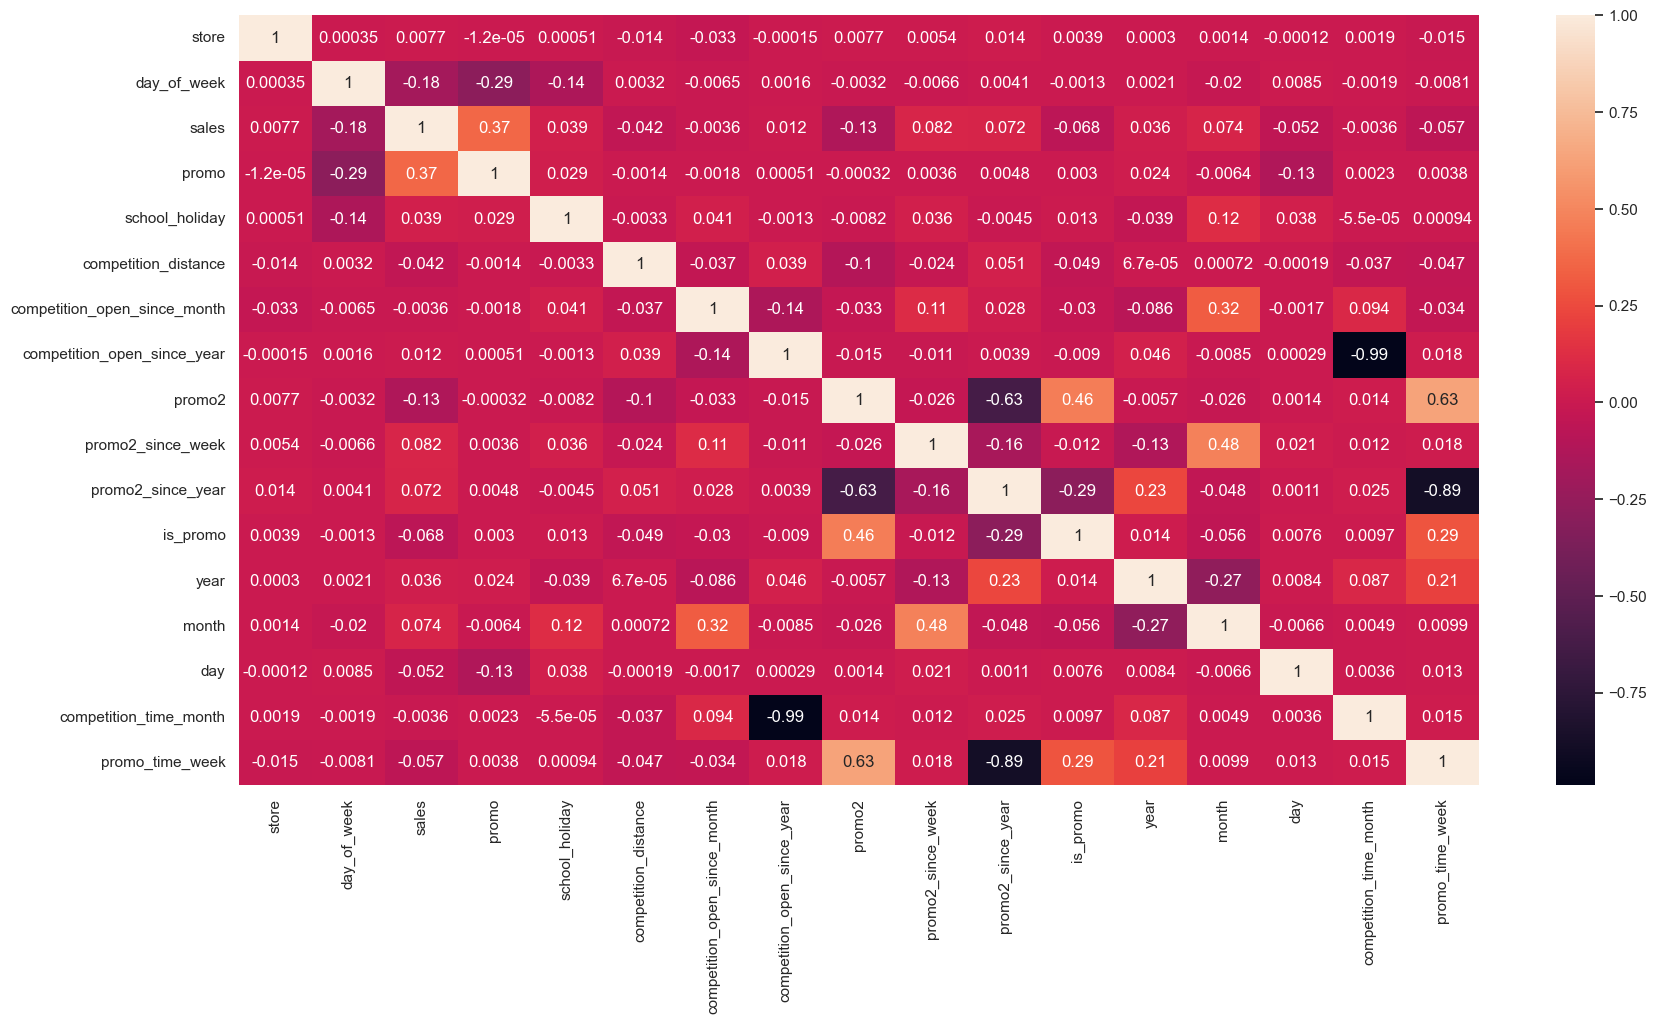

In [29]:
### Correlação entre todas as variáveis - Matriz de correlação multivariada

sns.heatmap( num_attributes_eda.corr(method = 'pearson'), annot = True);

### 4.3.2. Categorical Attributes 

In [36]:
cat_attributes_eda.head()

state_holiday store_type assortment year_week
0   regular_day          c      basic   2015-30
1   regular_day          a      basic   2015-30
2   regular_day          a      basic   2015-30
3   regular_day          c   extended   2015-30
4   regular_day          a      basic   2015-30

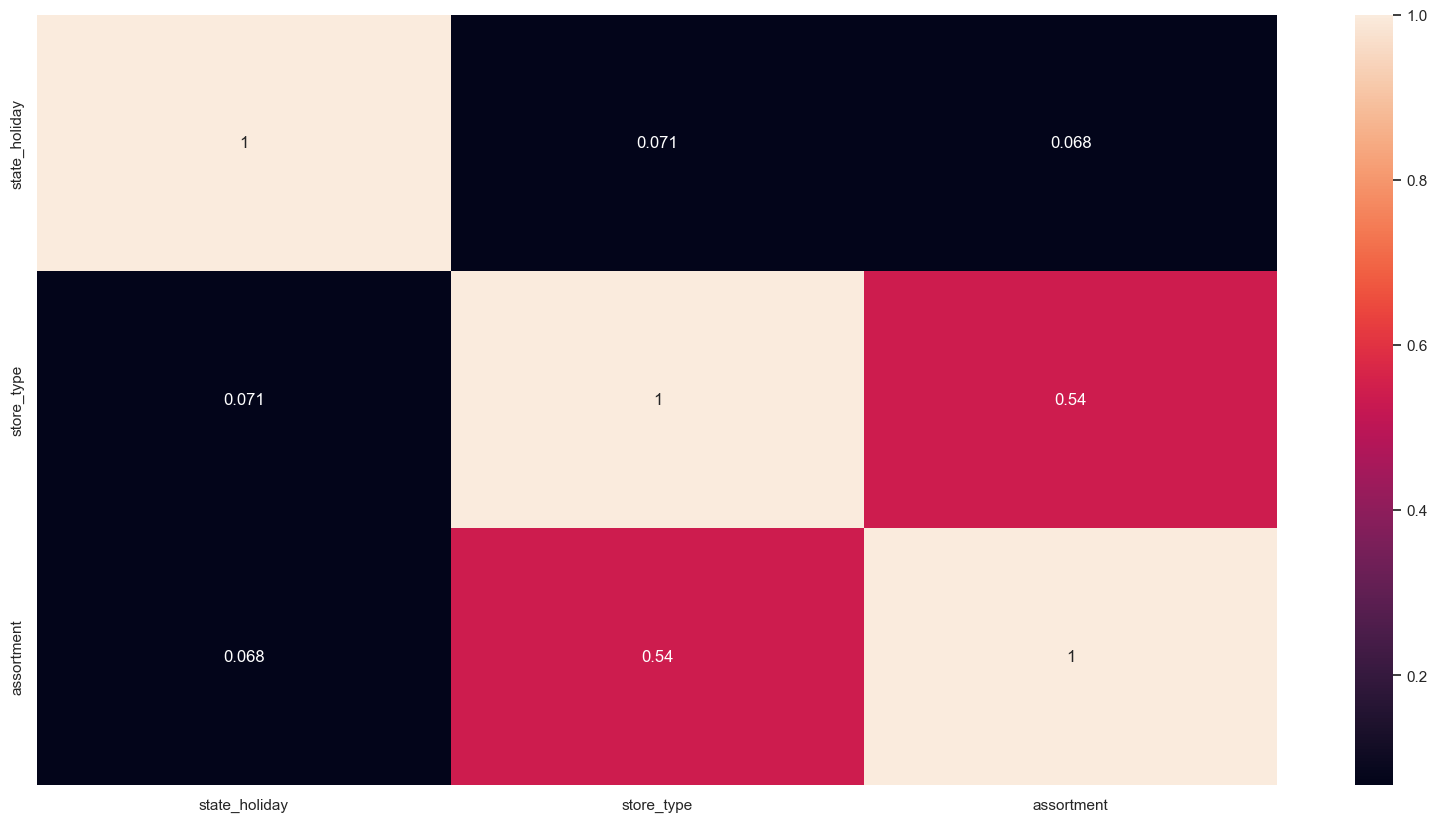

In [40]:
# Calculate cramer V
a1 = cramer_v( cat_attributes_eda['state_holiday'], cat_attributes_eda['state_holiday'] )
a2 = cramer_v( cat_attributes_eda['state_holiday'], cat_attributes_eda['store_type'] )
a3 = cramer_v( cat_attributes_eda['state_holiday'], cat_attributes_eda['assortment'] )

a4 = cramer_v( cat_attributes_eda['store_type'], cat_attributes_eda['state_holiday'] )
a5 = cramer_v( cat_attributes_eda['store_type'], cat_attributes_eda['store_type'] )
a6 = cramer_v( cat_attributes_eda['store_type'], cat_attributes_eda['assortment'] )

a7 = cramer_v( cat_attributes_eda['assortment'], cat_attributes_eda['state_holiday'] )
a8 = cramer_v( cat_attributes_eda['assortment'], cat_attributes_eda['store_type'] )
a9 = cramer_v( cat_attributes_eda['assortment'], cat_attributes_eda['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type':    [a4, a5, a6],
                   'assortment':    [a7, a8, a9] })

d = d.set_index( d.columns )

sns.heatmap( d, annot=True );

# 5.0. PREPARAÇÃO DOS DADOS

In [104]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df5 = df4.copy()

## 5.1. Normalização

In [ ]:
### Avaliar quais variáveis devem ser normalizadas, aquelas que possuem distribuição próxima da normal.

### Optou-se por não normalizar nenhuma variável numérica

## 5.2. Rescaling


In [29]:
## Dataframe apenas com features numéricas para enxergar os attr potenciais para fazer rescaling
a = df5.select_dtypes(include = ['int64','float64'])

### 5.2.1. Análise de Outliers

Avaliando a existência de outliers nos atributos para decidir entre Min-Max e Robust

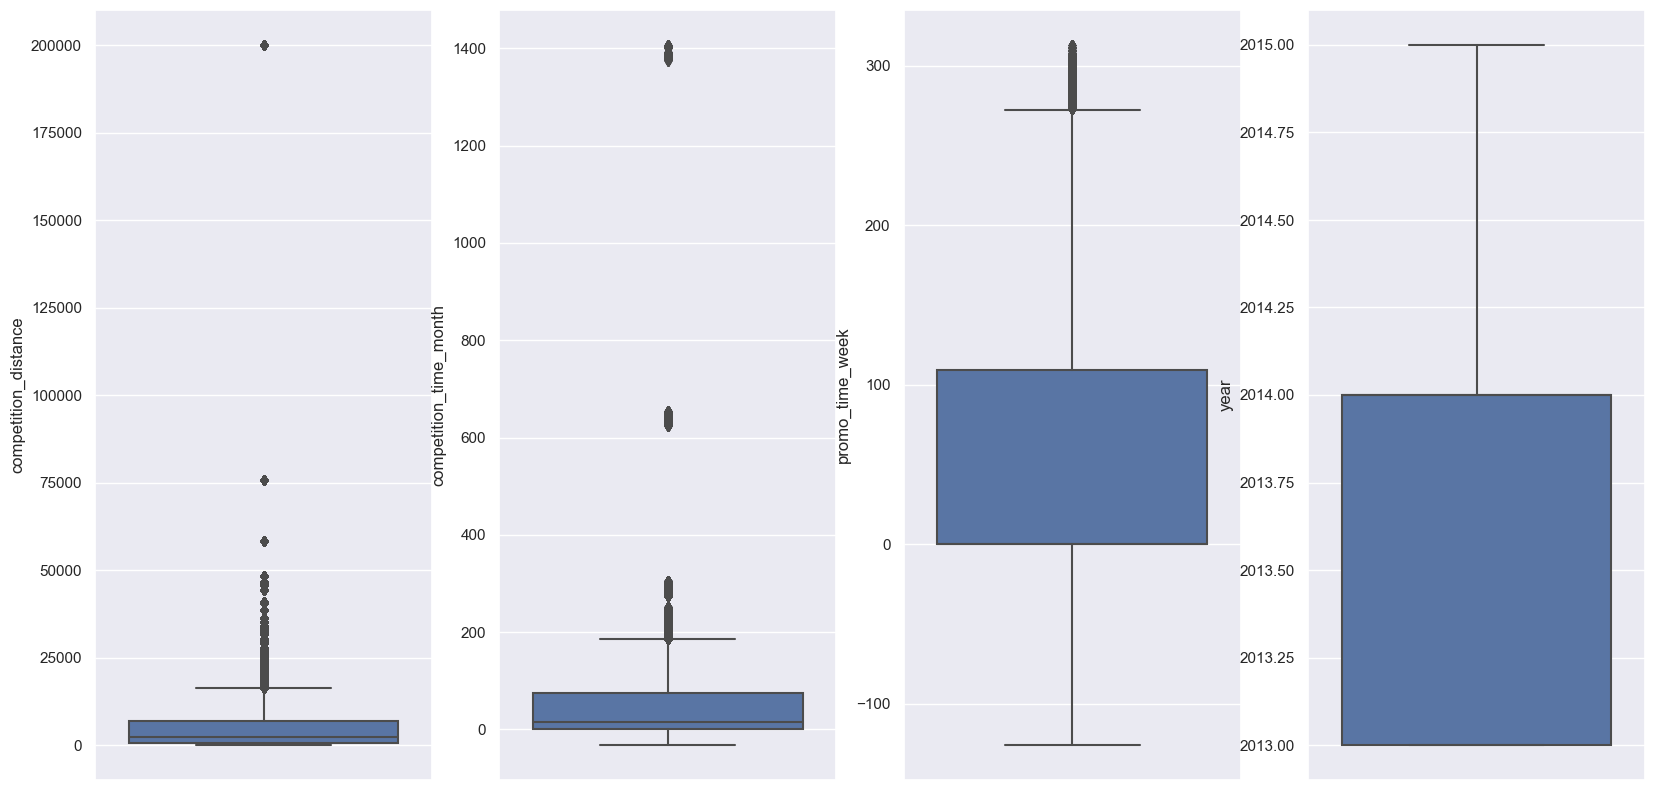

In [39]:
# competition_distance
plt.subplot(1,4, 1)
sns.boxplot(data = df5 , y = "competition_distance" );

# competition_time_month
plt.subplot(1,4,2)
sns.boxplot(data = df5 , y = "competition_time_month" );

# promo_time_week
plt.subplot(1,4,3)
sns.boxplot(data = df5 , y = "promo_time_week" );

# year 
plt.subplot(1,4,4)
sns.boxplot(data = df5 , y = "year" );

**Análise:** 

***competition_distance:*** É verificado a existência de inúmeros outliers, principalmente aqueles os quais colocamos em dados faltantes com um valor alto de distância por entender que não seria um competidor próximo. Decisão usar Robust Scaler.

***competition_time_month:*** É verificado a existência de inúmeros outliers. Decisão usar Robust Scaler.

***promo_time_week:*** É verificado poucos outliers, dessa forma, arriscaremos e será utilizado o MixMaxScaler.

***year:*** Não é verificado outliers. Decisão usar MinMaxScaler.

### 5.2.2. Aplicando o Rescaling

In [105]:
# Instanciando classe para aplicar técnica de Reescala
rs = RobustScaler() 
mms = MinMaxScaler()


# fit - calcula os parâmetros Q1 e Q2 do método de Reescala Robusto
# transform - Aplica a fórmula e de fato gera a escala nova do atributo

# competition_distance
df5["competition_distance"] = rs.fit_transform( df5[["competition_distance"]].values )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5["competition_time_month"] = rs.fit_transform( df5[["competition_time_month"]].values )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5["promo_time_week"] = mms.fit_transform( df5[["promo_time_week"]].values )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

# year
df5["year"] = mms.fit_transform( df5[["year"]].values )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer a reescala nos dados de teste
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

### 5.2.3. Distribuição atributos após Rescaling

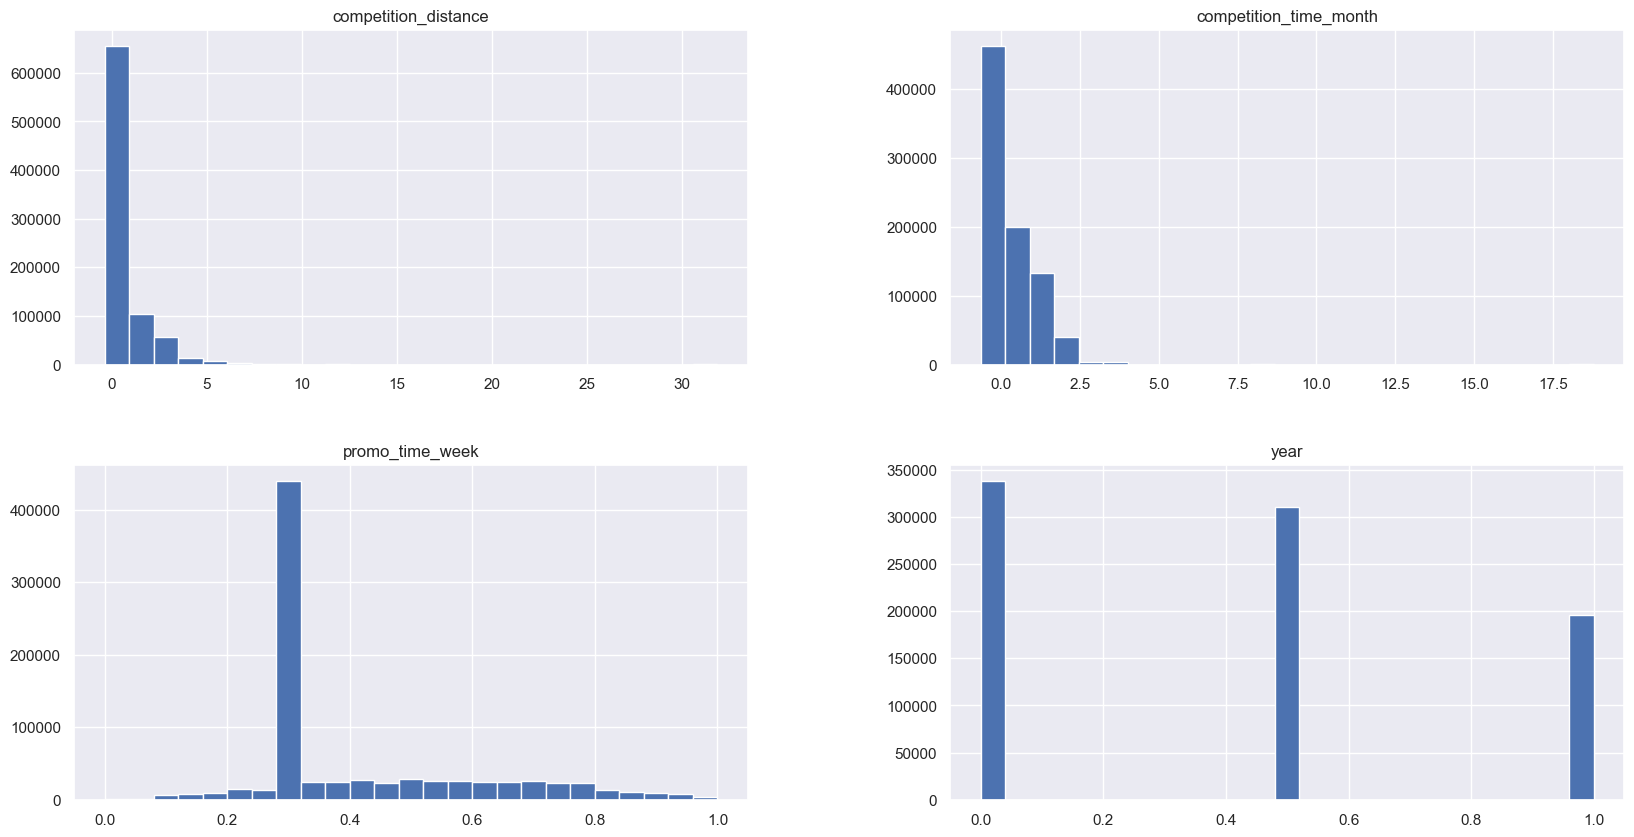

In [48]:
# Dataset com as variáveis com rescaling aplicadas para analisar distribução nova
aux = df5[["competition_distance","competition_time_month","promo_time_week","year"]]

aux.hist( bins = 25 );

## 5.3. Transformação 

### 5.3.1. Encoding

Variáveis categóricas -> Variáveis Numéricas

#### 5.3.1.1. Dataframe antes do Encoding

In [53]:
df5.head(10)

store  day_of_week       date  sales  promo state_holiday  school_holiday store_type assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week
0      1            5 2015-07-31   5263      1   regular_day               1          c      basic                 -0.17                             9                         2008       0                 31               2015         0  1.00      7   31            31   2015-30        2008-09-01                    0.92  2015-07-27             0.29
1      2            5 2015-07-31   6064      1   regular_day               1          a      basic                 -0.28                            11                         2007       1                 13               2010         1  1.00      7   31            31   2015-30        2007-11-01                    1.05  2010-03-22             0.92
2      3            5 2015-07-31   8314      1   regular_day               1          a      basic                  1.90                            12                         2006       1                 14               2011         1  1.00      7   31            31   2015-30        2006-12-01                    1.20  2011-03-28             0.80
3      4            5 2015-07-31  13995      1   regular_day               1          c   extended                 -0.28                             9                         2009       0                 31               2015         0  1.00      7   31            31   2015-30        2009-09-01                    0.74  2015-07-27             0.29
4      5            5 2015-07-31   4822      1   regular_day               1          a      basic                  4.45                             4                         2015       0                 31               2015         0  1.00      7   31            31   2015-30        2015-04-01                   -0.16  2015-07-27             0.29
5      6            5 2015-07-31   5651      1   regular_day               1          a      basic                 -0.33                            12                         2013       0                 31               2015         0  1.00      7   31            31   2015-30        2013-12-01                    0.05  2015-07-27             0.29
6      7            5 2015-07-31  15344      1   regular_day               1          a   extended                  3.50                             4                         2013       0                 31               2015         0  1.00      7   31            31   2015-30        2013-04-01                    0.16  2015-07-27             0.29
7      8            5 2015-07-31   8492      1   regular_day               1          a      basic                  0.84                            10                         2014       0                 31               2015         0  1.00      7   31            31   2015-30        2014-10-01                   -0.08  2015-07-27             0.29
8      9            5 2015-07-31   8565      1   regular_day               1          a   extended                 -0.05                             8                         2000       0                 31               2015         0  1.00      7   31            31   2015-30        2000-08-01                    2.24  2015-07-27             0.29
9     10            5 2015-07-31   7185      1   regular_day               1          a      basic                  0.13                             9                         2009       0                 31               2015         0  1.00      7   31            31   2015-30        2009-09-01                    0.74  2015-07-27             0.29

#### 5.3.1.2. Aplicando Encoding

In [108]:
# state_holiday -> One Hot Encoding 
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

# store_type
le = LabelEncoder()
df5["store_type"] = le.fit_transform( df5["store_type"] )
# Salvando valores parâmetros calculados para dados de treino para posteriormente fazer encoding nos dados de teste
pickle.dump(le, open('parameter/store_type_encoding.pkl', 'wb'))


# assortment
assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
# Troca de valores da coluna utilizando o método .map e o dicionário como referência
df5["assortment"] = df5["assortment"].map(assortment_dict)


**Escolhas:** 

***state_holiday:*** Usar one hot encoding pois não possui muitos níveis esse atributo.

***store_type:*** Usar Label Encoding pois os níveis da variável não possuem relação entre si.

***assortment:*** Usar Ordinal Encoding pois os níveis da variável possuem uma certa relação de grandeza entre si.

#### 5.3.1.1. Dataframe depois do Encoding

In [55]:
df5.head(10)

store  day_of_week       date  sales  promo  school_holiday  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  state_holiday_christmas  state_holiday_easter_holiday  state_holiday_public_holiday  state_holiday_regular_day
0      1            5 2015-07-31   5263      1               1           2           1                 -0.17                             9                         2008       0                 31               2015         0  1.00      7   31            31   2015-30        2008-09-01                    0.92  2015-07-27             0.29                        0                             0                             0                          1
1      2            5 2015-07-31   6064      1               1           0           1                 -0.28                            11                         2007       1                 13               2010         1  1.00      7   31            31   2015-30        2007-11-01                    1.05  2010-03-22             0.92                        0                             0                             0                          1
2      3            5 2015-07-31   8314      1               1           0           1                  1.90                            12                         2006       1                 14               2011         1  1.00      7   31            31   2015-30        2006-12-01                    1.20  2011-03-28             0.80                        0                             0                             0                          1
3      4            5 2015-07-31  13995      1               1           2           2                 -0.28                             9                         2009       0                 31               2015         0  1.00      7   31            31   2015-30        2009-09-01                    0.74  2015-07-27             0.29                        0                             0                             0                          1
4      5            5 2015-07-31   4822      1               1           0           1                  4.45                             4                         2015       0                 31               2015         0  1.00      7   31            31   2015-30        2015-04-01                   -0.16  2015-07-27             0.29                        0                             0                             0                          1
5      6            5 2015-07-31   5651      1               1           0           1                 -0.33                            12                         2013       0                 31               2015         0  1.00      7   31            31   2015-30        2013-12-01                    0.05  2015-07-27             0.29                        0                             0                             0                          1
6      7            5 2015-07-31  15344      1               1           0           2                  3.50                             4                         2013       0                 31               2015         0  1.00      7   31            31   2015-30        2013-04-01                    0.16  2015-07-27             0.29                        0                             0                             0                          1
7      8            5 2015-07-31   8492      1               1           0           1                  0.84                            10                         2014       0                 31               2015         0  1.00      7   31            31   2015-30        2014-10-01                   -0.08  2015-07-27             0.29                        0                             0                    

### 5.3.2. Response Variable Transformation

In [30]:
## Aplicar a Transformação Logarítmica 

df5["sales"] = np.log1p( df5['sales'] )

<AxesSubplot:xlabel='sales', ylabel='Count'>

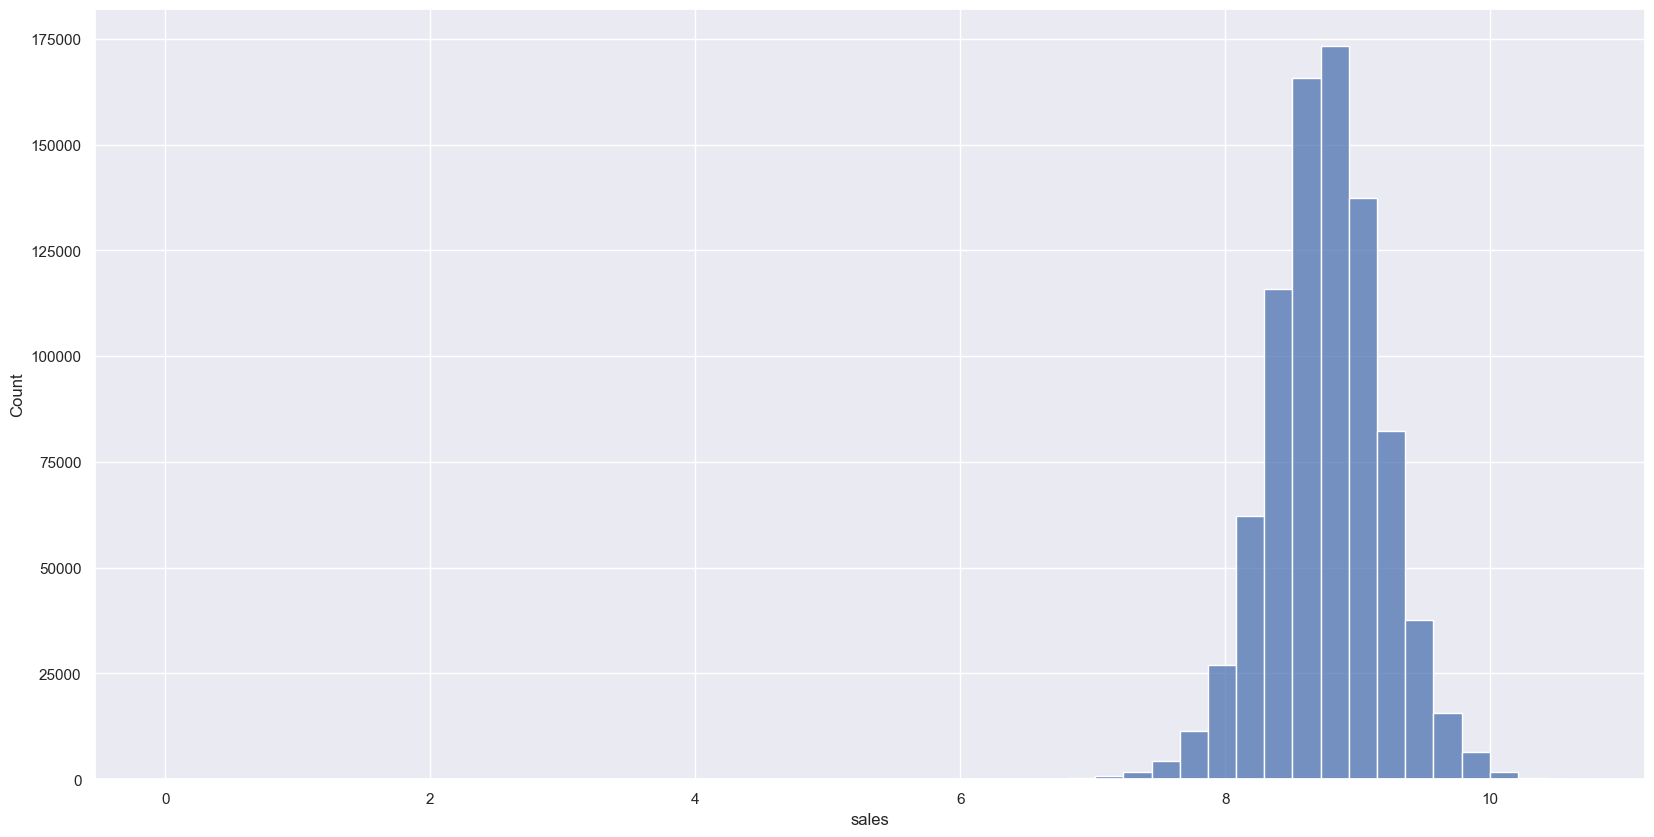

In [57]:
## Distribuição da variável resposta após a aplicação da transformação logarítmica

sns.histplot (df5['sales'], bins = 50)

### 5.3.3. Nature Transformation

#### 5.3.3.1. Dataframe antes da Transformação

In [63]:
df5.head(10)

store  day_of_week       date  sales  promo  school_holiday  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  state_holiday_christmas  state_holiday_easter_holiday  state_holiday_public_holiday  state_holiday_regular_day
0      1            5 2015-07-31   8.57      1               1           2           1                 -0.17                             9                         2008       0                 31               2015         0  1.00      7   31            31   2015-30        2008-09-01                    0.92  2015-07-27             0.29                        0                             0                             0                          1
1      2            5 2015-07-31   8.71      1               1           0           1                 -0.28                            11                         2007       1                 13               2010         1  1.00      7   31            31   2015-30        2007-11-01                    1.05  2010-03-22             0.92                        0                             0                             0                          1
2      3            5 2015-07-31   9.03      1               1           0           1                  1.90                            12                         2006       1                 14               2011         1  1.00      7   31            31   2015-30        2006-12-01                    1.20  2011-03-28             0.80                        0                             0                             0                          1
3      4            5 2015-07-31   9.55      1               1           2           2                 -0.28                             9                         2009       0                 31               2015         0  1.00      7   31            31   2015-30        2009-09-01                    0.74  2015-07-27             0.29                        0                             0                             0                          1
4      5            5 2015-07-31   8.48      1               1           0           1                  4.45                             4                         2015       0                 31               2015         0  1.00      7   31            31   2015-30        2015-04-01                   -0.16  2015-07-27             0.29                        0                             0                             0                          1
5      6            5 2015-07-31   8.64      1               1           0           1                 -0.33                            12                         2013       0                 31               2015         0  1.00      7   31            31   2015-30        2013-12-01                    0.05  2015-07-27             0.29                        0                             0                             0                          1
6      7            5 2015-07-31   9.64      1               1           0           2                  3.50                             4                         2013       0                 31               2015         0  1.00      7   31            31   2015-30        2013-04-01                    0.16  2015-07-27             0.29                        0                             0                             0                          1
7      8            5 2015-07-31   9.05      1               1           0           1                  0.84                            10                         2014       0                 31               2015         0  1.00      7   31            31   2015-30        2014-10-01                   -0.08  2015-07-27             0.29                        0                             0                    

#### 5.3.3.2. Transformação

In [31]:
## FEATURES COM NATUREZA CÍCLICA:

# day_of_week - ciclo de 7 
df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )


# month - ciclo de 12
df5["month_sin"] = df5["month"].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5["month_cos"] = df5["month"].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


# day - ciclo de 31
df5["day_sin"] = df5["day"].apply(lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
df5["day_cos"] = df5["day"].apply(lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )


# week_of_year - ciclo de 52 
df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )


**Escolha:**

Utilizou-se transformação trigonométrica para transformar atributos com informações cíclicas em números

#### 5.3.3.3. Dataframe depois da Transformação

In [65]:
df5.head(10)

store  day_of_week       date  sales  promo  school_holiday  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  state_holiday_christmas  state_holiday_easter_holiday  state_holiday_public_holiday  state_holiday_regular_day  day_of_week_sin  day_of_week_cos  month_sin  month_cos  day_sin  day_cos  week_of_year_sin  week_of_year_cos
0      1            5 2015-07-31   8.57      1               1           2           1                 -0.17                             9                         2008       0                 31               2015         0  1.00      7   31            31   2015-30        2008-09-01                    0.92  2015-07-27             0.29                        0                             0                             0                          1            -0.97            -0.22      -0.50      -0.87    -0.00     1.00             -0.57             -0.82
1      2            5 2015-07-31   8.71      1               1           0           1                 -0.28                            11                         2007       1                 13               2010         1  1.00      7   31            31   2015-30        2007-11-01                    1.05  2010-03-22             0.92                        0                             0                             0                          1            -0.97            -0.22      -0.50      -0.87    -0.00     1.00             -0.57             -0.82
2      3            5 2015-07-31   9.03      1               1           0           1                  1.90                            12                         2006       1                 14               2011         1  1.00      7   31            31   2015-30        2006-12-01                    1.20  2011-03-28             0.80                        0                             0                             0                          1            -0.97            -0.22      -0.50      -0.87    -0.00     1.00             -0.57             -0.82
3      4            5 2015-07-31   9.55      1               1           2           2                 -0.28                             9                         2009       0                 31               2015         0  1.00      7   31            31   2015-30        2009-09-01                    0.74  2015-07-27             0.29                        0                             0                             0                          1            -0.97            -0.22      -0.50      -0.87    -0.00     1.00             -0.57             -0.82
4      5            5 2015-07-31   8.48      1               1           0           1                  4.45                             4                         2015       0                 31               2015         0  1.00      7   31            31   2015-30        2015-04-01                   -0.16  2015-07-27             0.29                        0                             0                             0                          1            -0.97            -0.22      -0.50      -0.87    -0.00     1.00             -0.57             -0.82
5      6            5 2015-07-31   8.64      1               1           0           1                 -0.33                            12                         2013       0                 31               2015         0  1.00      7   31            31   2015-30        2013-12-01                    0.05  2015-07-27             0.29                        0                             0                             0                          1            -0.97            -0.22      -0.50      -0.87    -0.00     1.00             -0.57             -0.82
6      7            5 2015-07-31   9.64      1               1           0           2    

# 6.0. SELEÇÃO DE ATRIBUTOS 

In [32]:
### Cópia do dataframe em início de sessão 
### OBJETIVO: Caso seja realizado alguma instrução errada sob os dados trabalhados, poder ter um ponto de backup.

df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset  

No próximo ciclo CRISP, fazer isso como primeira etapa do passo 5.0. de Preparação dos Dados, para evitar vazamento de dados (Data Leakage) ao realizar transformações e rescala em atributos considerando todos os dados antes de separar o dataset

In [33]:
## Retirar do dataset variáveis que deram origem a features criadas 
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )


In [ ]:
## Pensaria aqui em dropar outras colunas também, em próximo ciclo CRISP

**Modelo de separação em dados de treino e teste:** 

Como os dados estão colocados de forma temporal, e o fenômeno de previsão também leva em consideração saber a previsão dentro de um período temporal, irei dividir os dados de treino e teste de acordo com o período de vendas, e não selecionando dados aleatórios, pois dessa forma, pode inviesar o modelo já que ele terá amostras de dados de datas futuras no treino e datas passadas no teste. 

In [68]:
## Calculando a data limite que dividirá o dataset: últimas 6 semanas de registro de vendas - TESTE
                                                   #registros de vendas antes das últimas 6 semanas - TREINO

df6["date"].max() - datetime.timedelta(days = 6*7)




Timestamp('2015-06-19 00:00:00')

In [34]:
## Filtrando dataset para a divisão como definido em modelo

# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


# Verificando períodos dos registros de venda que ficaram para treino e teste
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )


Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector  

In [36]:
## training dataset final for Boruta
## Excluímos as colunas 'sales' que é a var. resposta que não pode ser usada no treino e ainda foi utilizada no modelo da 
## separação treino e teste. O mesmo com a variável "date" pois foi usada para dividir os dados.
## Boruta aceita apenas Numpy, então por isso, .values
## ravel() coloca a variável resposta em vetor

X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = y_train.values.ravel()

## define RandomForestRegressor
##  n_jobs=-1 usa os core da máquina e fazer processamento em paralelo para ir mais rápido
rf = RandomForestRegressor( n_jobs=-1 )


## define Boruta 
## verbose é pra enxergar a evolução do processo de análise de seleção de features
## random_state é para selecionar aleatoriamente partindo de um mesmo ponto sempre

boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9



## 6.3. Best Features from Boruta  

In [37]:
## vetor True or False com  colunas selecionadas segundo o Boruta 
cols_selected = boruta.support_.tolist()

## Volto a utilizar dados de treino com a estrutura DataFrame
X_train_fs = X_train.drop( ['date','sales'], axis = 1 )

## as colunas mais relevantes segundo boruta
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns

## Colunas não selecionadas pelo boruta
cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [42]:
cols_selected_boruta.tolist()

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [41]:
cols_not_selected_boruta


['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

In [ ]:
## Variáveis apontadas como mais relevantes na EDA e a checagem com Boruta:

## year nao
## assortment sim
## competition_time_month sim
## state_holiday nao
## month sim
## promo sim

## 6.4. Manual Feature Selection  

Seleção Final contemplando as colunas relevantes apontadas pelo Boruta e pela análise exploratória de dados e escolha manual.

In [35]:
cols_selected = ['store',
                 'promo',
                 'store_type',
                 'assortment',
                 'competition_distance',
                 'competition_open_since_month',
                 'competition_open_since_year',
                 'promo2',
                 'promo2_since_week',
                 'promo2_since_year',
                 'competition_time_month',
                 'promo_time_week',
                 'day_of_week_sin',
                 'day_of_week_cos',
                 'month_cos',
                 'month_sin',
                 'day_sin',
                 'day_cos',
                 'week_of_year_cos',
                 'week_of_year_sin']

In [52]:
cols_selected

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'date',
 'sales']

# 7.0. MODELOS DE MACHINE LEARNING 

In [37]:
## Para treinar modelos sem cross validation apenas com uma parte de teste selecionada

## Selecionar apenas as colunas com maior importância sem as colunas data e sales
x_train = X_train[ cols_selected ]
x_test = X_test[ cols_selected ]

In [38]:
### ## Para treinar modelos com cross validation


## Columns to add
feat_to_add = ['date','sales']

#Adicionando colunas resposta('sales') e definição separação('date') para usar na validação cruzada

# Final Features 
cols_selected.extend( feat_to_add )

## Dados de treinamento que sobraram para fazer o teste com os modelos utilizando o CV
training = X_train[ cols_selected ]

## 7.1. Average Model 

In [40]:


# model

aux1 = x_test.copy() ## Cópia do conjunto de dados de teste
aux1['sales'] = y_test.copy() ## Cópia da variável resposta de teste adicionando ao df aux1

# Cálculo da média de vendas por loja apenas com dados de teste
aux2 = aux1[['sales','store']].groupby("store").mean().reset_index().rename( columns = {"sales":"predictions"} ) 
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store') # Juntei a coluna predictions ao dataset de teste


# prediction 
yhat_baseline = aux1['predictions'] # valores preditos

# performance - função para calcular desempenho de modelos

# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

Model Name          MAE    MAPE         RMSE
0  Average Model  1354.800353  0.2064  1835.135542

## 7.2. Linear Regression Model

### 7.2.1. Linear Regression Model - One KFold 

In [41]:
# model - classe de Regressão linear que irá se ajustar baseado nos parâmetros de dados de treino passados
lr = LinearRegression().fit( x_train, y_train ) 

# prediction
yhat_lr = lr.predict( x_test )


# performance 
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )

lr_result

Model Name          MAE      MAPE        RMSE
0  Linear Regression  1861.401851  0.291544  2663.02516

### 7.2.2. Linear Regression Model - Cross Validation 

In [42]:
model = LinearRegression()


lr_result_cv = cross_validation(training, 5, 'Linear Regression', model, verbose = True)
lr_result_cv


KFold Number 1

KFold Number 2

KFold Number 3

KFold Number 4

KFold Number 5


Model Name              MAE CV  \
0  Linear Regression  2077.22 +/- 296.38   

                                   MAPE CV            RMSE CV  
0  497240812105912.0 +/- 266797588747071.2  2945.6 +/- 469.22

## 7.3. Linear Regression Regularized Model  - Lasso 

### 7.3.1. Linear Regression Regularized Model - Lasso - One KFold 

In [43]:
# model - classe de Regressão linear Regularizada Lasso que irá se ajustar baseado nos parâmetros de dados de treino passados
# alpha parâmetro para atenuar os pesos da regressão para quando alguma variável obtiver peso muito alto, cada variável possuir igual importância
## Diminuindo alpha a tendência é melhorar o resultado, mas demora mais o processamento do modelo.

lrr = Lasso( alpha = 0.01 ).fit( x_train, y_train ) 

# prediction
yhat_lrr = lrr.predict( x_test )


# performance 
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )

lrr_result

Model Name          MAE      MAPE         RMSE
0  Linear Regression - Lasso  1891.058775  0.289205  2742.726754

**Reflexão:** Erro de regressão linear é maior que um erro de média, ou seja: 

1. Modelo de Média é melhor que o de Regressão Linear e RLR;
2. Dados possuem comportamento complexo não linear que faz com que modelos lineares não consigam aprender os comportamentos.

### 7.3.2. Linear Regression Regularized Model - Lasso - Cross Validation 

In [44]:
model = Lasso( alpha = 0.01 )


lrr_result_cv = cross_validation(training, 5, 'Linear Regression - Lasso', model, verbose = True)
lrr_result_cv


KFold Number 1

KFold Number 2

KFold Number 3

KFold Number 4

KFold Number 5


Model Name              MAE CV  \
0  Linear Regression - Lasso  2117.84 +/- 342.74   

                                   MAPE CV            RMSE CV  
0  500593108222855.8 +/- 259147353527316.1  3058.34 +/- 505.4

## 7.4. Random Forest Regressor 

### 7.4.1. Random Forest Regressor - One KFold 

In [45]:
# model - classe de RF que irá se ajustar baseado nos parâmetros de dados de treino passados
# n_estimators -> nº de árvores aleatórias que ele vai criar


rf = RandomForestRegressor( n_estimators = 100, n_jobs =-1 , random_state= 42 ).fit( x_train, y_train ) 

# prediction
yhat_rf = rf.predict( x_test )


# performance 
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )

rf_result

Model Name         MAE      MAPE         RMSE
0  Random Forest Regressor  686.463481  0.101064  1026.692596

### 7.4.2. Random Forest Regressor - Cross Validation 

In [46]:
model = RandomForestRegressor( n_estimators = 100, n_jobs =-1 , random_state= 42 )


rf_result_cv = cross_validation(training, 5, 'Random Forest Regressor', model, verbose = True)
rf_result_cv


KFold Number 1

KFold Number 2

KFold Number 3

KFold Number 4

KFold Number 5


Model Name             MAE CV  \
0  Random Forest Regressor  869.31 +/- 255.75   

                                   MAPE CV             RMSE CV  
0  565892498026684.1 +/- 324358099134918.2  1314.48 +/- 391.13

## 7.5. XGBoost Regressor

### 7.5.1. XGBoost Regressor - One KFold 

In [38]:
# model - instanciei objeto da classe de XGB Regressor que irá se ajustar baseado nos parâmetros de dados de treino passados

model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror').fit( x_train, y_train ) 

### Parâmetros opcionais
#n_estimators = 100, # n_estimators -> nº de árvores aleatórias que ele vai criar
#eta = 0.01 , ## Passos de aprendizado
#max_depth = 10, ## Máx. profundidade que a árvore pode chegar
#subsample = 0.7, ## Porcentagem de amostragem para selecionar mais relevantes
#colsample_bytree = 0.9 


# prediction
yhat_xgb = model_xgb.predict( x_test )


# performance 
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )

xgb_result

C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Model Name        MAE      MAPE         RMSE
0  XGBoost Regressor  880.01699  0.131751  1273.739905

### 7.5.2. XGBoost Regressor - Cross Validation

In [39]:
model = xgb.XGBRegressor( objective = 'reg:squarederror')

### Parâmetros opcionais
#n_estimators = 100, # n_estimators -> nº de árvores aleatórias que ele vai criar
#eta = 0.01 , ## Passos de aprendizado
#max_depth = 10, ## Máx. profundidade que a árvore pode chegar
#subsample = 0.7, ## Porcentagem de amostragem para selecionar mais relevantes
#colsample_bytree = 0.9



xgb_result_cv = cross_validation(training, 5, 'XGBoost Regressor', model, verbose = True)
xgb_result_cv


KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Model Name             MAE CV  \
0  XGBoost Regressor  1098.6 +/- 201.79   

                                   MAPE CV             RMSE CV  
0  631780474259057.4 +/- 318991966074892.1  1596.19 +/- 311.81

## 7.6. Compare Model´s Performance

### 7.6.1. Single Performance

In [47]:
models_all = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result], axis = 0)
models_all.sort_values(by = 'RMSE', ascending = True)

Model Name          MAE      MAPE         RMSE
0    Random Forest Regressor   686.463481  0.101064  1026.692596
0          XGBoost Regressor   880.016990  0.131751  1273.739905
0              Average Model  1354.800353  0.206400  1835.135542
0          Linear Regression  1861.401851  0.291544  2663.025160
0  Linear Regression - Lasso  1891.058775  0.289205  2742.726754

**Conclusão:** o fenômeno que estamos modelando possui comportamento complexo, modelos mais simples como os lineares não funcionam bem para
esse tipo de fenômeno. Essa performance não é a real dos modelos, para obter maior consistência nos resultados comparativos deve-se usar a validação cruzada.

### 7.6.2. Real Performance - Cross Validation

In [48]:
models_all_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv], axis = 0)
models_all_cv.sort_values(by = 'RMSE CV', ascending = True)

Model Name              MAE CV  \
0    Random Forest Regressor   869.31 +/- 255.75   
0          XGBoost Regressor   1098.6 +/- 201.79   
0          Linear Regression  2077.22 +/- 296.38   
0  Linear Regression - Lasso  2117.84 +/- 342.74   

                                   MAPE CV             RMSE CV  
0  565892498026684.1 +/- 324358099134918.2  1314.48 +/- 391.13  
0  631780474259057.4 +/- 318991966074892.1  1596.19 +/- 311.81  
0  497240812105912.0 +/- 266797588747071.2   2945.6 +/- 469.22  
0  500593108222855.8 +/- 259147353527316.1   3058.34 +/- 505.4

**Tomada de Decisão:** O modelo escolhido para a próxima etapa de ajuste de parâmetros após a validação cruzada será o 
XGBoost, isso pois esse modelo possui apesar de ficar em segundo em termos de performance dos modelos na etapa de validação, se comparado ao Random Forest Regressor, possui menor tempo de processamento no treinamento, e a diferença de performance não é tão grande relacionado ao primeiro. 

In [ ]:
### Em outro momento, seguir com Random Forest pode ser interessante também.

# 8.0. HYPERPARAMETER FINE TUNING 

## 8.1. Random Search

In [39]:
## Valores possíveis de teste para os parâmetros do modelo XGBoost
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]}


# Quantidade iterações (experimentos com valores distintos para testar desempenho)
MAX_EVAL = 10

In [40]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    
    ## Escolher um valor aleatório por iteração para cada parâmetro e armazenar em novo dicionário hp
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    
    ## Display do experimento com valores escolhidos
    
    print(f"\nIteração Nº: {i + 1}")
    
    print( hp )
    
    
    ## Modelo
    model = xgb.XGBRegressor( objective = 'reg:squarederror',
                              n_estimators = hp['n_estimators'], # n_estimators -> nº de árvores aleatórias que ele vai criar
                              eta = hp['eta'] , ## Passos de aprendizado
                              max_depth = hp['max_depth'], ## Máx. profundidade que a árvore pode chegar
                              subsample = hp['subsample'], ## Porcentagem de amostragem para selecionar mais relevantes
                              colsample_bytree = hp['colsample_bytree'],
                              min_child_weight = hp['min_child_weight'])


    # Performance
    result = cross_validation(training, 5, 'XGBoost Regressor', model, verbose = True)
    final_result = pd.concat([ final_result , result ])

    
    
## DataFrame com resultados de desempenho modelos com valores de parâmetros alterados
final_result


Iteração Nº: 0
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 1
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 2
{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 15}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 3
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 4
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 5
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 3}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 6
{'n_estimators': 3000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 7
{'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 8
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 15}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



Iteração Nº: 9
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number 1


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 2


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 3


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 4


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFold Number 5


C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Model Name              MAE CV                                   MAPE CV             RMSE CV
0  XGBoost Regressor  1227.52 +/- 156.47  577420143608886.8 +/- 301439463695141.56  1786.55 +/- 210.77
0  XGBoost Regressor  1648.28 +/- 188.33  489407786055460.3 +/- 269895133695514.25  2384.11 +/- 254.65
0  XGBoost Regressor  1060.83 +/- 138.28   618513914411846.5 +/- 321731722155223.0  1531.48 +/- 189.17
0  XGBoost Regressor  1285.83 +/- 152.08   556030157180490.3 +/- 289222231827041.9  1866.82 +/- 207.03
0  XGBoost Regressor   901.41 +/- 151.84   678322823438433.9 +/- 349082232489261.5  1301.62 +/- 226.39
0  XGBoost Regressor   1295.7 +/- 150.85   553480185533491.7 +/- 290849366080746.0  1877.02 +/- 201.84
0  XGBoost Regressor   941.85 +/- 139.06   648079148347980.6 +/- 337744856862806.5   1353.5 +/- 197.85
0  XGBoost Regressor    919.77 +/- 124.4  645851468968150.9 +/- 336218641788979.94  1333.59 +/- 203.38
0  XGBoost Regressor  1300.25 +/- 157.07  559582103059504.94 +/- 291793271407549.4   1894.71 +/- 207.8
0  XGBoost Regressor  1693.78 +/- 190.27  470789016621912.6 +/- 256642421594128.44   2436.75 +/- 259.3

## 8.2. Final Model

In [41]:
## Valores selecionados para cada parâmetro do modelo de acordo com o método Random Search

param_tuned = {'n_estimators': 1500,
               'eta': 0.03,
               'max_depth': 9,
               'subsample': 0.1,
               'colsample_bytree': 0.9,
               'min_child_weight': 8}      

In [42]:
## Desempenho do Modelo Final sob os dados de teste 

model_xgb = xgb.XGBRegressor( objective = 'reg:squarederror',
                          n_estimators = param_tuned['n_estimators'], # n_estimators -> nº de árvores aleatórias que ele vai criar
                          eta = param_tuned['eta'] , ## Passos de aprendizado
                          max_depth = param_tuned['max_depth'], ## Máx. profundidade que a árvore pode chegar
                          subsample = param_tuned['subsample'], ## Porcentagem de amostragem para selecionar mais relevantes
                          colsample_bytree = param_tuned['colsample_bytree'],
                          min_child_weight = param_tuned['min_child_weight']).fit( x_train, y_train ) 


## Predição
yhat_xgb = model_xgb.predict( x_test )


# Performance
# np.expm1() aplica-se exponencial nas variáveis respostas de vendas pois tinhamos transformado elas com log para treinar o modelo
xgb_final_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )

xgb_final_result 

C:\Users\alanc\anaconda3\envs\prediction_sales\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Model Name    MAE  MAPE   RMSE
0  XGBoost Regressor 684.45  0.10 996.69

In [44]:
## Armazenar modelo treinado após o ajuste de parâmetros
pickle.dump(model_xgb, open('C:/Users/alanc/Documents/repos/ds_em_producao/prediction_sales/model/model_xgb_rossmann.pkl', 'wb'))

In [51]:
## MPE (erro percentual médio)

mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb ) )
mpe

0.0031495113812973494

**Análise:** O MPE positivo significa que o modelo em média está subestimando o valor real da predição, ou seja, se o valor real é X
o modelo possui tendência a predizer um valor < X.

### 8.2.1. Final Model Result Analysis

Avaliar se o erro encontrado é baixo ou alto em comparação com os valores a serem preditos

In [45]:
np.expm1( y_test ).min()

569.0000000000002

In [46]:
np.expm1( y_test ).max()

41550.99999999998

In [47]:
np.expm1( y_test ).max() - np.expm1( y_test ).min()

40981.99999999998

In [48]:
## Percentual de Erro médio sobre a média da variável resposta
684.45 / np.expm1( y_test ).mean()

0.09784618907058441

**Reflexão:** 684,45 de erro médio absoluto é baixo em relação ao range das vendas reais, em comparação com a média dos valores 
reais de vendas, o erro representa 10%.

# 9.0. TRADUÇÃO E INTERPRETAÇÃO DO ERRO 

In [54]:
## Dados de teste com variáveis selecionadas para o modelo
df9 = X_test[ cols_selected ]

# rescale - voltando a variável resposta para a escala original 
# Valor real da variável resposta
df9['sales'] = np.expm1( df9['sales'] )
# Valor predito da variável resposta pelo modelo final
df9['predictions'] = np.expm1( yhat_xgb )

C:\Users\alanc\AppData\Local\Temp\ipykernel_10712\589395144.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
C:\Users\alanc\AppData\Local\Temp\ipykernel_10712\589395144.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb )


In [58]:
df9.head(20)

store  promo  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  competition_time_month  promo_time_week  day_of_week_sin  day_of_week_cos  month_cos  month_sin  day_sin  day_cos  week_of_year_cos  week_of_year_sin       date    sales  predictions
0       1      1           2           1                 -0.17                             9                         2008       0                 31               2015                    0.92             0.29            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31  5263.00      5297.65
1       2      1           0           1                 -0.28                            11                         2007       1                 13               2010                    1.05             0.92            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31  6064.00      5831.36
2       3      1           0           1                  1.90                            12                         2006       1                 14               2011                    1.20             0.80            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31  8314.00      9760.40
3       4      1           2           2                 -0.28                             9                         2009       0                 31               2015                    0.74             0.29            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31 13995.00     11390.77
4       5      1           0           1                  4.45                             4                         2015       0                 31               2015                   -0.16             0.29            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31  4822.00      6067.16
5       6      1           0           1                 -0.33                            12                         2013       0                 31               2015                    0.05             0.29            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31  5651.00      5925.46
6       7      1           0           2                  3.50                             4                         2013       0                 31               2015                    0.16             0.29            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31 15344.00     11902.57
7       8      1           0           1                  0.84                            10                         2014       0                 31               2015                   -0.08             0.29            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31  8492.00      7057.71
8       9      1           0           2                 -0.05                             8                         2000       0                 31               2015                    2.24             0.29            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31  8565.00      9016.74
9      10      1           0           1                  0.13                             9                         2009       0                 31               2015                    0.74             0.29            -0.97            -0.22      -0.87      -0.50    -0.00     1.00             -0.82             -0.57 2015-07-31  7185.00      6497.05
10     11      1           0           2                 -0.22                            11                         2011       1   

## 9.1. Business Performance

In [68]:
## SOMA DE VENDAS REAIS E PREDIÇÕES POR LOJA

## soma das predições de vendas feitas pelo modelo para as últimas 6 semanas por loja
sum_of_pred = df9[['store','predictions']].groupby("store").sum().reset_index().rename( columns = {'predictions': "sum_predictions"} )

## Calculando MAE e MAPE por loja 
df9_mae = df9[['store','sales','predictions']].groupby("store").apply(lambda x: mean_absolute_error( x['sales'] , x['predictions'] )).reset_index().rename( columns = {0: "MAE"} )
df9_mape = df9[['store','sales','predictions']].groupby("store").apply(lambda x: mean_absolute_percentage_error( x['sales'] , x['predictions'] )).reset_index().rename( columns = {0: "MAPE"} )

## MERGE

## Unindo calculos MAE e MAPE para cada loja
df9_metrics = df9_mae.merge( df9_mape, how = "inner", on = "store" )
## Unindo calculos métricas com soma das previsões de venda por loja
df9_p_store = sum_of_pred.merge( df9_metrics, how = "inner", on = "store" )

## CENÁRIOS

# Pior cenário
df9_p_store["worst_scenario"] = df9_p_store["sum_predictions"] - df9_p_store["MAE"]
# Melhor cenário
df9_p_store["best_scenario"] = df9_p_store["sum_predictions"] + df9_p_store["MAE"]

## Definir ordens colunas 
df9_p_store = df9_p_store[['store','sum_predictions','worst_scenario','best_scenario','MAE','MAPE']] 

In [70]:
### Lojas em que é mais difícil prever as vendas -> MAPE maior

df9_p_store.sort_values(by = 'MAPE', ascending = False).head(10)

store  sum_predictions  worst_scenario  best_scenario     MAE  MAPE
291     292        104878.41       101533.01      108223.82 3345.41  0.56
908     909        233806.98       226124.14      241489.83 7682.85  0.51
594     595        342343.66       337293.13      347394.18 5050.52  0.35
285     286        168048.19       167165.38      168930.99  882.81  0.32
1038   1039        343292.66       340862.60      345722.71 2430.05  0.32
875     876        198702.72       194789.24      202616.20 3913.48  0.30
721     722        345881.84       344058.90      347704.79 1822.95  0.24
169     170        185866.58       184916.27      186816.89  950.31  0.24
273     274        198996.14       197716.07      200276.21 1280.07  0.22
533     534        279729.75       278338.87      281120.63 1390.88  0.22

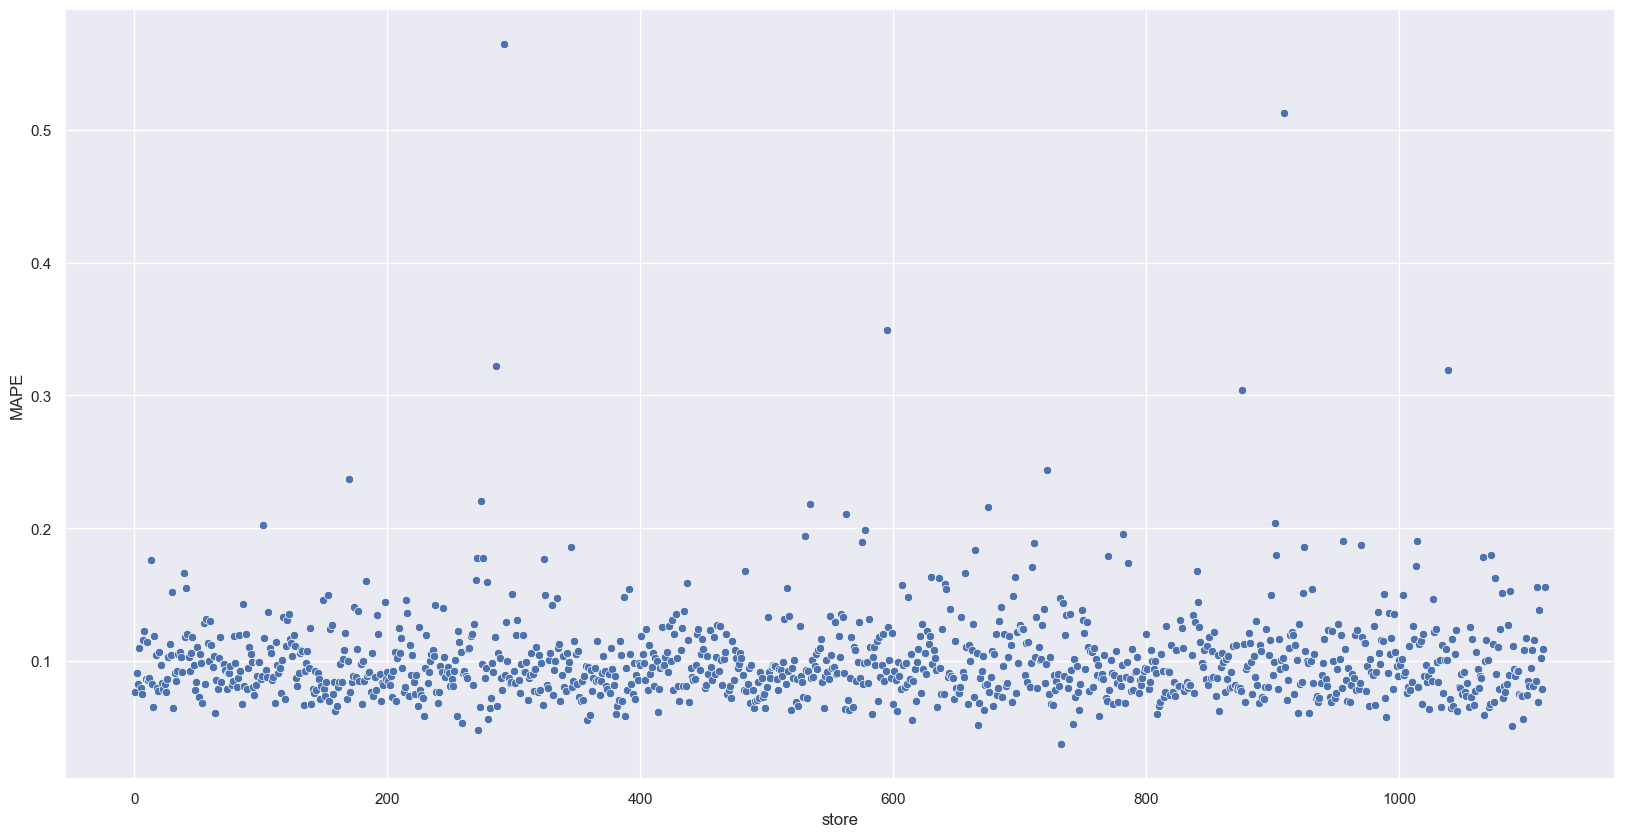

In [72]:
## Gráfico de dispersão para analisar lojas mais difíceis de realizar predição

sns.scatterplot(data = df9_p_store, x = 'store', y = 'MAPE');

**Análises:** 

- Maioria das lojas possui erro médio abaixo de 20% de erro do modelo sob a média de vendas real diária ao longo de 6 semanas.

- Existem de 10 a 12 lojas com erro médio abaixo de 40% e acima de 20% de erro do modelo sob a média de vendas real diária ao longo de 6 semanas.

- Existem 2 lojas com erro médio acima de 50% de erro do modelo sob a média de vendas real diária ao longo de 6 semanas.


## 9.2. Total Performance

In [84]:
## Somatório predições de vendas, melhor cenário e pior cenário para todas as lojas nas próximas 6 semanas

df9_total_pred = df9_p_store[['sum_predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum( x ), axis = 0).reset_index().rename(columns = {'index':'Conditions', 0: 'Sales' })
#df9_p_store[['sum_predictions','worst_scenario','best_scenario']].sum().reset_index().rename(columns = {'index':'Conditions', 0: 'Sales' })
## Ajuste valores ficarem mais visíveis
df9_total_pred['Sales'] = df9_total_pred['Sales'].map( 'R${:,.2f}'.format ) 
df9_total_pred

Conditions             Sales
0  sum_predictions  R$282,860,864.00
1   worst_scenario  R$282,093,965.75
2    best_scenario  R$283,627,733.95

## 9.3. Machine Learning Performance

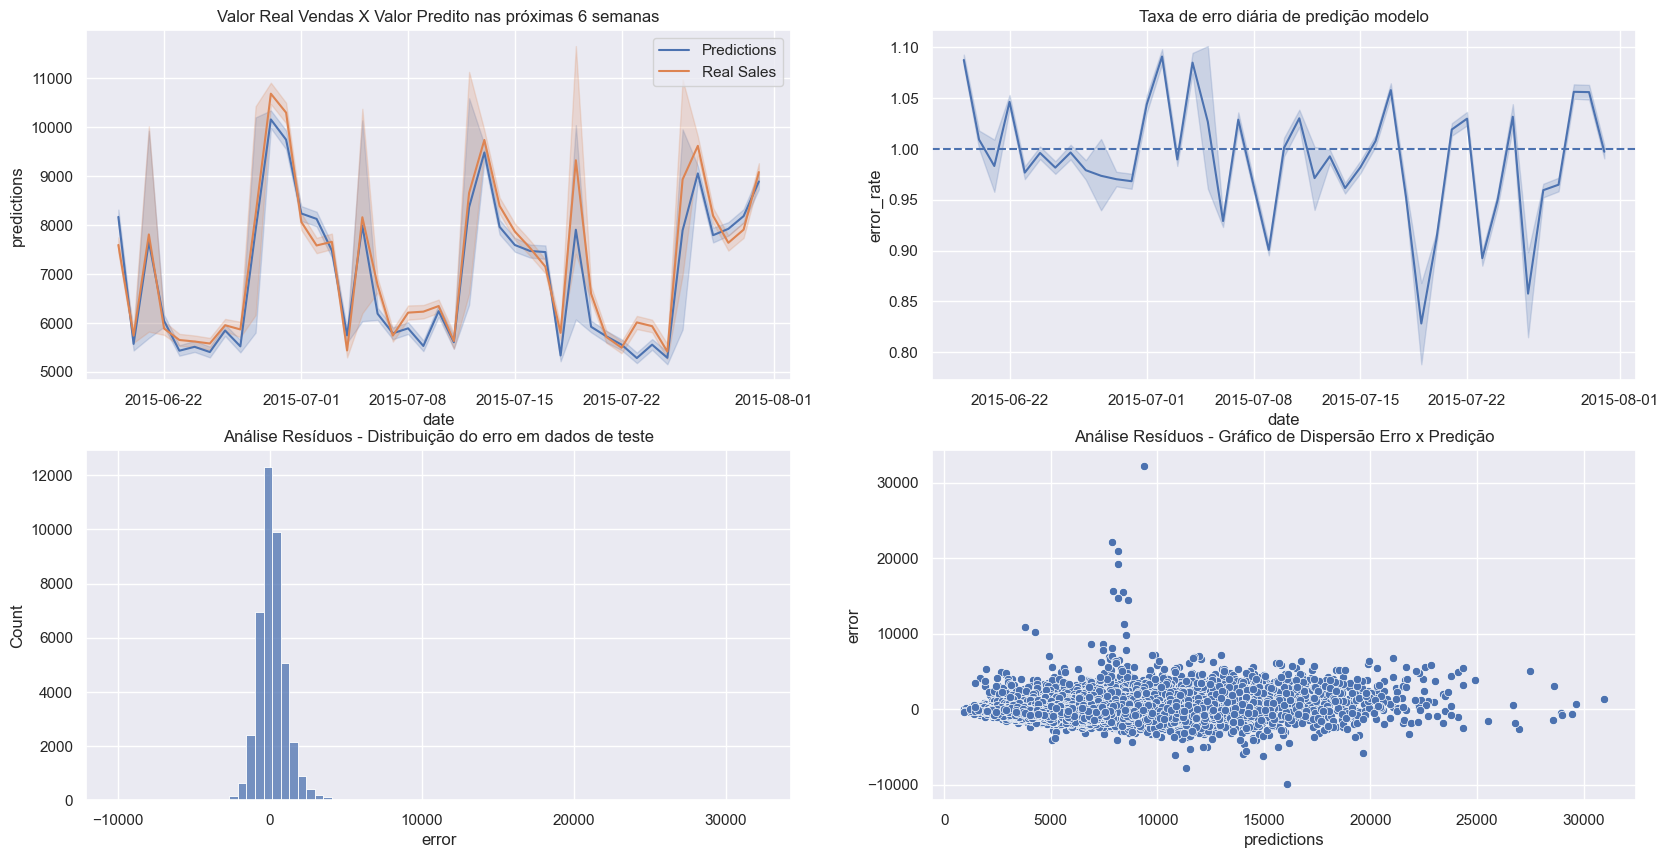

In [95]:
### VENDAS REAIS E PREDITAS DIÁRIAS AO LONGO DAS 6 SEMANAS DE ANÁLISE(dados de teste)

## Erro diário de predição de vendas para cada loja da rede ao longo das próximas 6 semanas
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']


## DASHBOARD 

## Valor predito x Valor real
plt.subplot( 2,2,1 )
sns.lineplot(x = 'date', y = 'predictions', data = df9, label = 'Predictions')
sns.lineplot(x = 'date', y = 'sales', data = df9, label = 'Real Sales').set_title("Valor Real Vendas X Valor Predito nas próximas 6 semanas");

## Taxa de erro modelo (df9['predictions'] / df9['sales'])
plt.subplot( 2,2,2 )
sns.lineplot(x = 'date', y = 'error_rate', data = df9).set_title("Taxa de erro diária de predição modelo");
plt.axhline(1, linestyle = '--');

## Distribuição do erro  - Análise de Resíduos
plt.subplot( 2,2,3 )
sns.histplot(df9['error'], bins = 75).set_title("Análise Resíduos - Distribuição do erro em dados de teste");

## Gráfico de dispersão  - Análise de Resíduos
plt.subplot( 2,2,4 )
sns.scatterplot(x = 'predictions', y = 'error', data = df9).set_title("Análise Resíduos - Gráfico de Dispersão Erro x Predição");


**Conclusões:** 

- Pelos gráficos se confirma o que a métrica MPE indicou, que o modelo em média subestima os valores preditos em relação ao valor real da variável resposta. 

- A distribuição normal do erro nos dados de teste indica que o modelo performou bem

- Os maiores erros ou dificuldades de predição do modelo ocorrem quando o valor real de vendas está entre 5000 e 10000.

# 10.0. DEPLOY MODEL TO PRODUCTION 

## 10.1. Rossmann Class 

In [ ]:
## DATA CLEANING + FEATURE ENGINEERING + DATA FILTERING + DATA PREPARATION + FEATURE SELECTION

class Rossmann( object ):
    def __init__( self ):
        self.competition_distance_scaler   = pickle.load(open('parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open('parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open('parameter/year_scaler.pkl', 'rb'))
        self.store_type_encoding           = pickle.load(open('parameter/store_type_encoding.pkl', 'rb'))


    def data_cleaning(self, df1):
       
        ## 1.1. Rename Columns ---------------------------------------------------------------------

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        ## Utiliza função lambda para encapsular a função que transforma para snake_case os atributos
        snakecase = lambda x: inflection.underscore( x )

        ## Map - Mapeia cada valor dentro da estrutura de dado passada e aplica a função snakecase
        cols_new = list( map( snakecase, cols_old ) )

        ## rename 
        df1.columns = cols_new

        ## 1.3. Data Types ---------------------------------------------------------------------

        ## Arrumar para a coluna date ficar com o tipo de dado correto
        df1['date'] = pd.to_datetime( df1['date'] )


        ## 1.5. Fillout NA ---------------------------------------------------------------------

        #competition_distance    

        # Assumptions: o valor NA ocorre quando a loja em questão não possui competidor próximo ou esse é tão longe que não é 
        # considerado competidor próximo

        # Action: substituir os NA´s por um valor maior que o valor máximo existente para outras lojas

        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x)

        #competition_open_since_month   

        # Assumptions: se a loja não possui competidor próximo, até faz sentido essa coluna ser 0 ou NA, porque não existe data de 
        # abertura se não existe loja, mas a questão é que existe mais faltante nessa coluna que na coluna de distância de competidor
        # próximo. 

        # Action: substituir os NA´s pelo valor do mês da data de venda do histórico de vendas da loja. (sem muita lógica)

        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                        else x['competition_open_since_month'], axis = 1)

        #competition_open_since_year     

        # Assumptions: se a loja não possui competidor próximo, até faz sentido essa coluna ser 0 ou NA, porque não existe data de 
        # abertura se não existe loja, mas a questão é que existe mais faltante nessa coluna que na coluna de distância de competidor
        # próximo. 

        # Action: substituir os NA´s pelo valor do ano da data de venda do histórico de vendas da loja. (sem muita lógica)


        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) 
                                                        else x['competition_open_since_year'], axis = 1)

        #promo2_since_week               

        # Assumptions: os NA´s ocorrem em lojas que não participam da promo2, pois não existe semana de início da promo2 se a loja
        # decidiu não participar. 

        # Action: substituir os NA´s pelo valor da semana da data de venda do histórico de vendas da loja. (sem muita lógica)

        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                                        else x['promo2_since_week'], axis = 1)

        #promo2_since_year               

        # Assumptions: os NA´s ocorrem em lojas que não participam da promo2, pois não existe ano de início da promo2 se a loja
        # decidiu não participar. 

        # Action: substituir os NA´s pelo valor do ano da data de venda do histórico de vendas da loja. (sem muita lógica)

        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                                        else x['promo2_since_year'], axis = 1)

        #promo_interval

        # Assumptions: épocas de promoção 2 são conjuntos de meses que caracterizam o início de promoções 2. O NA nessa coluna 
        # caracteriza que a loja referida não realizou promoções em nenhum mês do ano da referente data. 

        # Action: substituir os NA´s por 0 pois significa que não tem época de promoção naquele ano. 
        # Criar coluna extra ('is_promo') para indicar se mês de venda da loja vigente é o mês de promo2 consecutiva. 

        month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)

        #month_map é a abreviação do mês de mensuração de venda
        df1['month_map'] = df1['date'].dt.month.map( month_map )

        # atributo que diz se o mês de venda é o mês em que se realiza promoção periodicamente
        df1['is_promo'] = df1[['month_map','promo_interval']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if 
                                                                    x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1)


        ## 1.6. Change Types ---------------------------------------------------------------------


        ### Mudar nº de mês, ano e semana de float64 para int64

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

        return df1
    
    
    def feature_engineering(self, df2):
        
        ## FEATURE ENGINEERING + DATA FILTERING
        
        ## 2.4. Feature Engineering

        ### 2.4.1. Da variável 'date'

        # year - extrair apenas o ano de vendas daquela loja

        df2['year'] = df2['date'].dt.year

        # month - extrair apenas o mês de vendas daquela loja

        df2['month'] = df2['date'].dt.month

        # day - extrair apenas o dia de vendas daquela loja

        df2['day'] = df2['date'].dt.day

        # week of year - extrair apenas a semana de vendas do ano daquela loja

        df2['week_of_year'] = df2['date'].dt.isocalendar().week
        # (year-week) - Formatar a data para em string aparecer o ano e a semana do ano das vendas daquela loja

        df2['year_week'] = df2['date'].dt.strftime("%Y-%W")


        ### 2.4.2. Das variáveis 'competition_open_since_month' e 'competition_open_since_year'

        # competition since  
        df2['competition_since'] = df2[['competition_open_since_year','competition_open_since_month']].apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'] , day = 1 ), axis = 1)

        # competition time month - Calculo de período entre datas
        df2['competition_time_month'] =( (df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days ).astype( 'int64' )

        ### 2.4.3. Das variáveis ''promo2_since_week'' e 'promo2_since_year'

        # promo since 
        df2['promo_since'] =  df2['promo2_since_year'].astype( str ) + "-" + df2['promo2_since_week'].astype( str )

        # datetime
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7) )


        # promo time week - - Calculo de período entre datas
        df2['promo_time_week'] =( (df2['date'] - df2['promo_since']) / 7 ).apply(lambda x: x.days ).astype( 'int64' )

        ### 2.4.4. Da variável 'assortment'
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        ### 2.4.5. Da variável 'state_holiday'       
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # 3.0. FILTRAGEM DE VARIÁVEIS

        ## 3.1. Filtragem das Linhas

        df2 = df2[ df3['open'] != 0  ]

        ## 3.2. Seleção das Colunas

        ## COLUNAS EXCLUÍDAS:
        cols_drop = ['customers','open','promo_interval','month_map']
        df2 = df2.drop( cols_drop, axis = 1 )
                
        return df2 
    
    def data_preparation(self, df5):
        
        
        ## 5.2. Rescaling

        # competition_distance
        df5["competition_distance"] = self.competition_distance_scaler.transform( df5[["competition_distance"]].values )

        # competition_time_month
        df5["competition_time_month"] = self.competion_time_month_scaler.transform( df5[["competition_time_month"]].values )

        # promo_time_week
        df5["promo_time_week"] = self.promo_time_week_scaler.transform( df5[["promo_time_week"]].values )
        
        # year
        df5["year"] = self.year_scaler.transform( df5[["year"]].values )
        
        ## 5.3. Transformação 

        ### 5.3.1. Encoding

        # state_holiday -> One Hot Encoding 
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        # store_type - Label Encoder
        df5["store_type"] = self.store_type_encoding.transform( df5["store_type"] )
              
        # assortment
        assortment_dict = {'basic': 1, 'extended': 2, 'extra': 3}
        # Troca de valores da coluna utilizando o método .map e o dicionário como referência
        df5["assortment"] = df5["assortment"].map(assortment_dict)


        ### 5.3.3. Nature Transformation

        ## FEATURES COM NATUREZA CÍCLICA:

        # day_of_week - ciclo de 7 
        df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )


        # month - ciclo de 12
        df5["month_sin"] = df5["month"].apply(lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5["month_cos"] = df5["month"].apply(lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )


        # day - ciclo de 31
        df5["day_sin"] = df5["day"].apply(lambda x: np.sin( x * ( 2. * np.pi/31 ) ) )
        df5["day_cos"] = df5["day"].apply(lambda x: np.cos( x * ( 2. * np.pi/31 ) ) )


        # week_of_year - ciclo de 52 
        df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

        # Feature Selection with Boruta and EDA
        cols_selected = ['store', 'promo', 'store_type','assortment', 'competition_distance', 'competition_open_since_month',
        'competition_open_since_year', 'promo2', 'promo2_since_week','promo2_since_year', 'competition_time_month',
        'promo_time_week','day_of_week_sin','day_of_week_cos','month_cos','month_sin','day_sin','day_cos','week_of_year_cos',
        'week_of_year_sin']
        
        
        return df5[cols_selected]

In [ ]:
        ### 5.3.2. Response Variable Transformation

        ## Aplicar a Transformação Logarítmica 

        df5["sales"] = np.log1p( df5['sales'] )

## 10.2. API Handler 

In [ ]:
## Importando classe Rossmann do arquivo Rossmann.py da pasta rossmann
#from nome_pasta.nome_arquivo import class_in_arquivo
from rossman.Rossmann import Rossmann

# loading model 
model = pickle.load(open('C:/Users/alanc/Documents/repos/ds_em_producao/prediction_sales/model/model_xgb_rossmann.pkl', 'rb'))


# instaciando objeto da classe Flask que será a API
app = Flask( __name__ )

# criando endpoint com método POST (envia algum dado para poder receber)
## método GET (pede algum dado para poder receber)
@app.route('/rossmann/predict', methods = ['POST'])

def rossmann_predict():
    test_json = request.get_json() ## Classe request com método get_json() para puxar o dado enviado para a API

    if test_json: # Para checar se há dado 
        if isinstace(test_json, dict): #unique example/observations/sample in dict
            test_raw = pd.DataFrame(test_json, index = [0])
            
        else: #multiple example/observations/sample in dict (dict aninhado)
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys() )
            
        ## Intanciando objeto da classe Rossmann 
        pipeline = Rossmann()
        
        # data cleaning - começo a usar os métodos da classe Rossmann criada
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering 
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation 
        df3 = pipeline.data_preparation( df2 )
            
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response ## Dado resposta para a entidade que solitou algo via dado 
            
if __name__ == '__main__':
    app.run( '0.0.0.0' ) ## dizer para endpoint rodar no localhost (rodando na máquina)
    

## 10.3. API Tester 